#IMPORTS

In [ ]:
import numpy as np
import pandas as pd
import math
from dataclasses import dataclass, field
from typing import Dict, Any, List, Tuple

import yfinance as yf

import datetime as dt
import matplotlib.pyplot as plt

# DATA DOWNLOAD

In [ ]:
# Define el símbolo del activo y el rango de fechas
ticker = "BTC-USD"
start_date = "2010-01-01"
end_date = dt.date.today().strftime('%Y-%m-%d')

# Descarga los datos
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)

# Si las columnas son MultiIndex, las aplanamos
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Selecciona solo las columnas deseadas y en el orden estándar
save_data = data[["Close", "High", "Low", "Open", "Volume"]].copy()

# Elimina el nombre del eje columnas ("Price" u otro)
save_data.columns.name = None

# Asegúrate de que el índice sea tipo datetime y tenga nombre "Date"
save_data.index = pd.to_datetime(save_data.index)
save_data.index.name = "Date"

data=save_data.copy()

## Data Sanity Check

In [ ]:
def inspect_and_sanitize_ohlcv(df: pd.DataFrame, expected_freq: str = "D") -> pd.DataFrame:
    """
    Inspección y normalización suave del OHLCV (BTC 24/7):
      - Ordena por índice y lo convierte a DatetimeIndex si no lo es.
      - Verifica columnas requeridas y tipo float.
      - Detecta duplicados de índice.
      - Reporta huecos (faltantes) con respecto a expected_freq.
      - No hace "imputación" agresiva: deja NaN si faltan datos reales.
    """
    req_cols = ["Open", "High", "Low", "Close", "Volume"]
    # Asegurar columnas
    missing = [c for c in req_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas requeridas: {missing}")

    # Índice de tiempo
    out = df.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index, utc=False)

    # Ordenar y eliminar duplicados exactos de filas
    out = out.sort_index()
    if out.index.duplicated().any():
        # En cripto es raro, pero puede ocurrir por merges/descargas. Promediamos duplicados.
        out = out.groupby(out.index).mean(numeric_only=True)

    # Tipos numéricos
    for c in req_cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    # Informe de huecos (en BTC diario suele NO haber huecos)
    full_range = pd.date_range(out.index.min(), out.index.max(), freq=expected_freq)
    missing_days = full_range.difference(out.index)
    print(f"[INFO] Rango temporal: {out.index.min().date()} → {out.index.max().date()}  "
          f"({len(out)} filas). Freq esperada: {expected_freq}")
    print(f"[INFO] Días faltantes vs rejilla {expected_freq}: {len(missing_days)}")
    if len(missing_days) <= 10:
        # Mostrar algunos para inspección visual
        print(f"[INFO] Ejemplo de faltantes: {missing_days[:5]}")
    else:
        print(f"[INFO] (demasiados para listar)")

    # NaNs por columna
    na_report = out[req_cols].isna().sum()
    print("[INFO] NaNs por columna:")
    print(na_report.to_string())

    return out

data = inspect_and_sanitize_ohlcv(data, expected_freq="D")

[INFO] Rango temporal: 2014-09-17 → 2025-09-04  (4006 filas). Freq esperada: D
[INFO] Días faltantes vs rejilla D: 0
[INFO] Ejemplo de faltantes: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
[INFO] NaNs por columna:
Open      0
High      0
Low       0
Close     0
Volume    0


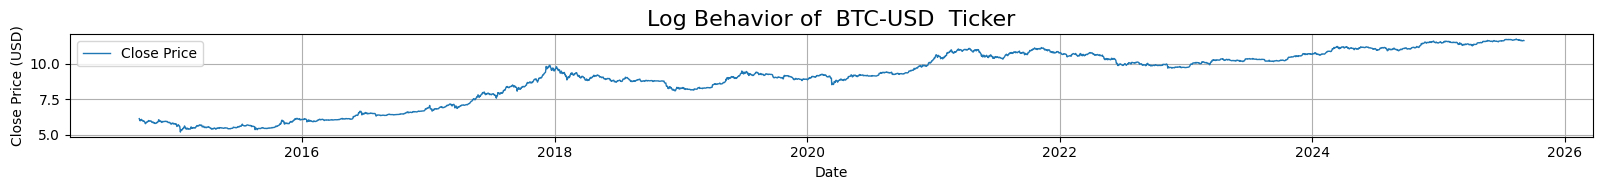

In [ ]:
# === Plot Data ===
plt.figure(figsize=(16, 2))
plt.plot(data.index, np.log(data['Close']), label='Close Price', linewidth=1)
#plt.plot(vix_df.index, np.log(vix_df['Close']), label='Close Price', linewidth=1)

# === Labels and Details ===
plt.title(f'Log Behavior of  {ticker}  Ticker', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# HELPERS GLOBALES

In [ ]:
# ============================================================
# HELPERS ÚNICOS — comunes para todos los feature-sets
# ============================================================
import numpy as np
import pandas as pd
import math

# ------------------ utilidades básicas ----------------------
def _safe_div(a, b, eps: float = 1e-12):
    return a / (b + eps)

def _rolling_apply(series: pd.Series, window: int, func, min_periods: int | None = None, **kwargs) -> pd.Series:
    """
    Aplica 'func' sobre cada ventana (np.ndarray -> float).
    - min_periods default = window (evita fugas).
    - reenvía **kwargs a 'func' (p.ej., max_pairs=...).
    """
    if min_periods is None:
        min_periods = window
    return series.rolling(window=window, min_periods=min_periods).apply(
        lambda a: func(np.asarray(a, dtype=float), **kwargs),
        raw=True
    )

def _ols_slope_only(y_window: np.ndarray):
    """Pendiente OLS (b) en la ventana. Diagnóstico de tendencia local."""
    y = np.asarray(y_window, dtype=float)
    W = len(y)
    if W < 3 or np.allclose(y, y[0]): return np.nan
    x = np.arange(W, dtype=float)
    x_mean = x.mean(); y_mean = y.mean()
    Sxx = np.sum((x - x_mean) ** 2)
    if Sxx <= 0: return np.nan
    Sxy = np.sum((x - x_mean) * (y - y_mean))
    return float(Sxy / Sxx)

def _ols_r2_window(y_window: np.ndarray) -> float:
    """R^2 de una recta (y ~ a + b t) en la ventana."""
    y = np.asarray(y_window, dtype=float)
    W = len(y)
    if W < 3 or np.allclose(y, y[0]): return np.nan
    x = np.arange(W, dtype=float)
    X = np.vstack([np.ones(W), x]).T
    try:
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        y_hat = X @ beta
        ss_res = np.sum((y - y_hat)**2)
        ss_tot = np.sum((y - y.mean())**2)
        return float(1 - _safe_div(ss_res, ss_tot))
    except np.linalg.LinAlgError:
        return np.nan

def _poly2_curvature_window(y_window: np.ndarray) -> float:
    """Curvatura (coef c) de y ~ a + b t + c t^2 en la ventana."""
    y = np.asarray(y_window, dtype=float)
    W = len(y)
    if W < 5 or np.allclose(y, y[0]): return np.nan
    t = np.arange(W, dtype=float)
    X = np.vstack([np.ones(W), t, t*t]).T
    try:
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        return float(beta[2])
    except np.linalg.LinAlgError:
        return np.nan

def _last_value_percentile_window(arr: np.ndarray) -> float:
    """Percentil del último valor dentro de su propia ventana (solo pasado)."""
    x = np.asarray(arr, dtype=float); W = len(x)
    if W < 3 or not np.isfinite(x[-1]): return np.nan
    rank = np.sum(x <= x[-1])
    return float(rank / (W + 1e-12))

def _flip_rate_window(y_window: np.ndarray) -> float:
    """Frecuencia de cambios de signo en la ventana (0..1)."""
    y = np.asarray(y_window, dtype=float)
    if len(y) < 5: return np.nan
    s = np.sign(y)
    flips = np.sum(s[1:] * s[:-1] < 0)
    return float(flips / (len(y) - 1))

def _bars_since_last_true(cond: pd.Series) -> pd.Series:
    """Barras desde el último True (acumulador reseteable)."""
    idx = pd.Series(np.where(cond, np.arange(len(cond)), np.nan), index=cond.index)
    last = idx.ffill()
    return pd.Series(np.arange(len(cond)), index=cond.index) - last

# ---------------------- OHLCV básicos -----------------------
def _atr(df: pd.DataFrame, window: int) -> pd.Series:
    """ATR simple (media móvil del True Range)."""
    high = df["High"].astype(float)
    low  = df["Low"].astype(float)
    close = df["Close"].astype(float)
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low),
        (high - prev_close).abs(),
        (low  - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def _rolling_vwap(df: pd.DataFrame, window: int) -> pd.Series:
    """VWAP rolling usando Typical Price."""
    tp = (df["High"].astype(float) + df["Low"].astype(float) + df["Close"].astype(float)) / 3.0
    vol = df["Volume"].astype(float)
    num = (tp * vol).rolling(window).sum()
    den = vol.rolling(window).sum()
    return _safe_div(num, den)

def _bollinger_bands(close: pd.Series, window: int, k: float):
    ma = close.rolling(window).mean()
    sd = close.rolling(window).std(ddof=1)
    upper = ma + k * sd
    lower = ma - k * sd
    width = (upper - lower)
    return ma, upper, lower, width

def _keltner_channels(df: pd.DataFrame, window: int, mult: float):
    ma = df["Close"].astype(float).rolling(window).mean()
    atrW = _atr(df, window)
    upper = ma + mult * atrW
    lower = ma - mult * atrW
    width = (upper - lower)
    return ma, upper, lower, width

# ------------------ estructura temporal ---------------------
def _variance_ratio_windowed(returns_window, m: int):
    """Variance Ratio de Lo–MacKinlay en una ventana."""
    x = np.asarray(returns_window, dtype=float)
    if len(x) < m + 5: return np.nan
    var1 = np.var(x, ddof=1)
    if not np.isfinite(var1) or var1 <= 0: return np.nan
    agg = pd.Series(x).rolling(m).sum().dropna().values
    if len(agg) < 5: return np.nan
    varm = np.var(agg, ddof=1)
    return float(varm / (m * var1))

def _hurst_rs_windowed(returns_window):
    """Hurst R/S (barato y robusto)."""
    x = np.asarray(returns_window, dtype=float); n = len(x)
    if n < 32: return np.nan
    x = x - np.mean(x)
    y = np.cumsum(x)
    R = np.max(y) - np.min(y)
    S = np.std(x, ddof=1)
    if S <= 0: return np.nan
    return float(np.log((R/S)+1e-12)/np.log(n))

def _katz_fd_window(y_window: np.ndarray) -> float:
    """Fractal Dimension (Katz) proxy. ~1: lineal; ~2: errático."""
    y = np.asarray(y_window, dtype=float); n = len(y)
    if n < 5: return np.nan
    L = np.sum(np.abs(np.diff(y)));
    if L <= 0: return np.nan
    d = np.max(np.abs(y - y[0]));
    if d <= 0: return np.nan
    return float(np.log10(n) / (np.log10(n) + np.log10(d / (L + 1e-12) + 1e-12)))

# ------------------ entropías sencillas ---------------------
def _perm_entropy_window(x_window: np.ndarray, m=4, tau=1, normalize=True):
    """Permutation Entropy (Bandt-Pompe) en una ventana."""
    x = np.asarray(x_window, dtype=float); n = len(x)
    L = n - (m-1)*tau
    if m<2 or L<=1: return np.nan
    patterns = {}
    for i in range(L):
        w = x[i:(i+(m-1)*tau+1):tau]
        ranks = tuple(np.argsort(np.argsort(w)))
        patterns[ranks] = patterns.get(ranks,0)+1
    counts = np.array(list(patterns.values()), dtype=float)
    p = counts / counts.sum()
    H = -np.sum(p*np.log(p+1e-12))
    if not normalize: return float(H)
    Hmax = math.lgamma(m+1)  # log(m!)
    return float(H/(Hmax+1e-12))

# ------------------ volatilidad realizada -------------------
def _rv_close_to_close(r: pd.Series, window: int) -> pd.Series:
    return r.rolling(window).std(ddof=1)

def _rv_parkinson(high: pd.Series, low: pd.Series, window: int) -> pd.Series:
    hl = np.log(high.astype(float) / low.astype(float))
    rv = (hl ** 2).rolling(window).mean() / (4.0 * np.log(2.0))
    return np.sqrt(rv)

def _rv_garman_klass(open_: pd.Series, high: pd.Series, low: pd.Series, close: pd.Series, window: int) -> pd.Series:
    log_hl = np.log(high.astype(float) / low.astype(float))
    log_co = np.log(close.astype(float) / open_.astype(float))
    rv = 0.5 * (log_hl ** 2) - (2.0 * np.log(2.0) - 1.0) * (log_co ** 2)
    rv = rv.rolling(window).mean().clip(lower=0.0)
    return np.sqrt(rv)

def _rv_rogers_satchell(open_: pd.Series, high: pd.Series, low: pd.Series, close: pd.Series, window: int) -> pd.Series:
    h_c = np.log(high.astype(float) / close.astype(float))
    h_o = np.log(high.astype(float) / open_.astype(float))
    l_c = np.log(low.astype(float)  / close.astype(float))
    l_o = np.log(low.astype(float)  / open_.astype(float))
    rs = (h_c * h_o + l_c * l_o).rolling(window).mean().clip(lower=0.0)
    return np.sqrt(rs)

def _rv_bipower(r: pd.Series, window: int) -> pd.Series:
    mu1 = np.sqrt(2.0 / np.pi)
    bv = (1.0 / (mu1**2)) * (r.abs() * r.shift(1).abs()).rolling(window).sum()
    return np.sqrt(bv / window)

def _realized_quarticity(r: pd.Series, window: int) -> pd.Series:
    rq = (r ** 4).rolling(window).mean()
    return (window / 3.0) * rq  # var-like

def _ewma_vol(r: pd.Series, lam: float) -> pd.Series:
    """EWMA estilo RiskMetrics: devuelve σ_t (shifted) para anti-fuga."""
    r2 = r.fillna(0.0) ** 2
    var = pd.Series(np.nan, index=r.index, dtype=float)
    s2 = 0.0; started = False
    for i, val in enumerate(r2):
        if not started:
            s2 = val; started = True
        else:
            s2 = lam * s2 + (1.0 - lam) * val
        var.iloc[i] = s2
    return np.sqrt(var).shift(1)

# ------------------ otras utilidades ------------------------
def _efficiency_ratio_window(y_window: np.ndarray) -> float:
    """
    Kaufman Efficiency Ratio: |y_t - y_0| / sum(|Δy|).
    ~1: movimiento lineal; ~0: ruido zig-zag.
    """
    y = np.asarray(y_window, dtype=float)
    if len(y) < 3: return np.nan
    num = abs(y[-1] - y[0])
    den = np.sum(np.abs(np.diff(y)))
    if den <= 0: return np.nan
    return float(num / den)

def _beta_y_on_x_window(y_window: np.ndarray, x_window: np.ndarray) -> float:
    """Beta de y sobre x (OLS) en la ventana."""
    y = np.asarray(y_window, dtype=float)
    x = np.asarray(x_window, dtype=float)
    if len(y) != len(x) or len(y) < 3: return np.nan
    x_mean = x.mean(); y_mean = y.mean()
    Sxx = np.sum((x - x_mean)**2)
    if Sxx <= 0: return np.nan
    Sxy = np.sum((x - x_mean)*(y - y_mean))
    return float(Sxy / Sxx)

def _hurst_absr_window(x_window: np.ndarray) -> float:
    """Hurst R/S aplicado a |r|."""
    x = np.asarray(x_window, dtype=float)
    if len(x) < 32: return np.nan
    x = x - np.mean(x)
    y = np.cumsum(x)
    R = np.max(y) - np.min(y)
    S = np.std(x, ddof=1)
    if S <= 0: return np.nan
    return float(np.log((R/S)+1e-12)/np.log(len(x)))

# ----------- helpers extra para este bloque -----------------
def _acf_window(y_window: np.ndarray, lag: int) -> float:
    y = np.asarray(y_window, dtype=float); n = len(y)
    if n <= lag + 2: return np.nan
    y = y - y.mean()
    denom = np.dot(y, y)
    if denom <= 0: return np.nan
    num = np.dot(y[lag:], y[:-lag])
    return float(num / denom)

def _pacf_yw_window(y_window: np.ndarray, lag: int) -> float:
    """PACF por Durbin–Levinson para lag específico (pequeño)."""
    y = np.asarray(y_window, dtype=float); n = len(y)
    if n < lag + 5 or lag < 1: return np.nan
    y = y - y.mean()
    ac = [1.0]
    denom = np.dot(y, y)
    if denom <= 0: return np.nan
    for k in range(1, lag+1):
        ac.append(np.dot(y[k:], y[:-k]) / denom)
    phi = np.zeros((lag+1,), dtype=float); v = ac[0]
    for k in range(1, lag+1):
        if k == 1:
            phi[1] = ac[1]; v *= (1 - phi[1]**2)
        else:
            num = ac[k] - np.sum(phi[1:k] * ac[1:k][::-1])
            den = v
            if abs(den) < 1e-12: return np.nan
            phi_k = num / den
            phi[1:k] = phi[1:k] - phi_k * phi[1:k][::-1]
            phi[k] = phi_k; v *= (1 - phi_k**2)
    return float(phi[lag])

def _ar1_phi_window(y_window: np.ndarray) -> float:
    y = np.asarray(y_window, dtype=float)
    if len(y) < 20: return np.nan
    x = y[:-1]; z = y[1:]
    if np.std(x) == 0: return np.nan
    x_mean = x.mean(); z_mean = z.mean()
    Sxx = np.sum((x - x_mean)**2)
    Sxy = np.sum((x - x_mean)*(z - z_mean))
    if Sxx <= 0: return np.nan
    return float(Sxy / Sxx)

def _ar_p_yw_coeffs(y_window: np.ndarray, p: int):
    y = np.asarray(y_window, dtype=float); n = len(y)
    if n < p + 10 or p < 1: return [np.nan] * p
    y = y - y.mean()
    gamma = np.array([np.dot(y[k:], y[:-k]) if k>0 else np.dot(y,y) for k in range(p+1)], dtype=float)
    if gamma[0] <= 0: return [np.nan]*p
    r = gamma[1:] / (gamma[0] + 1e-12)
    R = np.empty((p, p), dtype=float)
    for i in range(p):
        for j in range(p):
            R[i, j] = gamma[abs(i-j)] / (gamma[0] + 1e-12)
    try:
        phi = np.linalg.solve(R, r)
        return [float(v) for v in phi]
    except np.linalg.LinAlgError:
        return [np.nan]*p

def _binary_indicator_quantile(series: pd.Series, window: int, q: float) -> pd.Series:
    """Indicador 1[r_t <= Q_t(q)] donde Q_t(q) es el cuantil rolling (solo pasado)."""
    thresh = series.rolling(window).quantile(q)
    return (series <= thresh).astype(float)

def _cond_corr_window(y_window: np.ndarray, lag: int, sign: int) -> float:
    y = np.asarray(y_window, dtype=float); n = len(y)
    if n <= lag + 5: return np.nan
    a = y[lag:]; b = y[:-lag]
    mask = np.sign(b) == sign
    if np.sum(mask) < 8: return np.nan
    a = a[mask]; b = b[mask]
    if np.std(a)==0 or np.std(b)==0: return np.nan
    return float(np.corrcoef(a, b)[0,1])

def _spearman_lag_window(y_window: np.ndarray, lag: int) -> float:
    y = np.asarray(y_window, dtype=float); n = len(y)
    if n <= lag + 5: return np.nan
    a = y[lag:]; b = y[:-lag]
    ra = np.argsort(np.argsort(a)); rb = np.argsort(np.argsort(b))
    return float(np.corrcoef(ra, rb)[0,1])

def _kendall_tau_lag_window(y_window: np.ndarray, lag: int, max_pairs=4000) -> float:
    y = np.asarray(y_window, dtype=float); n = len(y)
    if n <= lag + 5: return np.nan
    a = y[lag:]; b = y[:-lag]; m = len(a)
    if m*(m-1)//2 > max_pairs:
        rng = np.random.default_rng(123)
        idx = rng.choice(m, size=min(2*int(np.sqrt(max_pairs))+2, m), replace=False)
        a = a[idx]; b = b[idx]; m = len(a)
    C = D = 0
    for i in range(m-1):
        s = np.sign(a[i+1:] - a[i]) * np.sign(b[i+1:] - b[i])
        C += np.sum(s > 0); D += np.sum(s < 0)
    den = C + D
    return np.nan if den == 0 else float((C - D) / (den + 1e-12))

def _get_num_bins(N, corr=None):
    if corr is None:
        z = np.cbrt(8 + 324*N + 12*np.sqrt(36*N + 729*N**2))
        b = np.round(z/6 + 2/(3*z) + 1/3)
    else:
        b = np.round(np.sqrt(0.5) * np.sqrt(1 + np.sqrt(1 + 24*N/(1 - min(corr**2,0.99) + 1e-12))))
    return int(max(2, b))

def _shannon_H(counts):
    p = counts.astype(float); s = p.sum()
    if s <= 0: return 0.0
    p = p / s; p = p[p > 0]
    return float(-np.sum(p * np.log(p)))

def _mutual_info_norm(x, y):
    x = np.asarray(x); y = np.asarray(y); n = len(x)
    if n < 10 or np.all(x == x[0]) or np.all(y == y[0]): return np.nan
    corr = np.corrcoef(x, y)[0,1] if np.std(x)>0 and np.std(y)>0 else 0.0
    bins = _get_num_bins(n, corr=corr)
    cXY, _, _ = np.histogram2d(x, y, bins=bins)
    iXY = _shannon_H(cXY.sum(axis=1)) + _shannon_H(cXY.sum(axis=0)) - _shannon_H(cXY)
    hX = _shannon_H(np.histogram(x, bins=bins)[0])
    hY = _shannon_H(np.histogram(y, bins=bins)[0])
    denom = max(min(hX, hY), 1e-12)
    return float(iXY / denom)

def _conditional_mi_norm(x, y, z, bins=None):
    x = np.asarray(x); y = np.asarray(y); z = np.asarray(z); n = len(x)
    if n < 30: return np.nan
    if bins is None: bins = _get_num_bins(n)
    def digitize(v):
        v = np.asarray(v, dtype=float)
        edges = np.linspace(np.nanmin(v), np.nanmax(v) + 1e-12, bins+1)
        return np.clip(np.digitize(v, edges) - 1, 0, bins-1)
    X = digitize(x); Y = digitize(y); Z = digitize(z)
    def H_joint(*vs):
        if len(vs) == 2:
            c = np.zeros((bins, bins), dtype=float)
            for a,b in zip(vs[0], vs[1]): c[a,b]+=1
            return _shannon_H(c)
        elif len(vs) == 3:
            c = np.zeros((bins, bins, bins), dtype=float)
            for a,b,c3 in zip(vs[0], vs[1], vs[2]): c[a,b,c3]+=1
            return _shannon_H(c)
        else:
            raise ValueError
    HXZ = H_joint(X,Z); HYZ = H_joint(Y,Z); HXYZ = H_joint(X,Y,Z)
    HZ = _shannon_H(np.bincount(Z, minlength=bins))
    cmi = HXZ + HYZ - HXYZ - HZ
    HX = _shannon_H(np.bincount(X, minlength=bins))
    HY = _shannon_H(np.bincount(Y, minlength=bins))
    Hcond_XZ = max(HXZ - HZ, 0.0); Hcond_YZ = max(HYZ - HZ, 0.0)
    denom = max(min(Hcond_XZ, Hcond_YZ), 1e-12)
    return float(max(cmi, 0.0) / denom)

def _transfer_entropy_window(y_window: np.ndarray, lag: int, bins: int = 3) -> float:
    x = np.asarray(y_window, dtype=float); n = len(x)
    if n < lag + 5: return np.nan
    x_t   = x[lag+1:]; x_tm1 = x[lag:-1]; y_tl  = x[:-lag-1]
    m = len(x_t)
    if m < 20: return np.nan
    edges = np.linspace(np.nanmin(x), np.nanmax(x)+1e-12, bins+1)
    def dig(v): return np.clip(np.digitize(v, edges)-1, 0, bins-1)
    Xt = dig(x_t); Xtm1 = dig(x_tm1); Ytl = dig(y_tl)
    eps = 1.0
    P_xt_x1y = np.zeros((bins, bins, bins)) + eps
    P_x1y    = np.zeros((bins, bins)) + eps*bins
    P_xt_x1  = np.zeros((bins, bins)) + eps
    P_x1     = np.zeros((bins,)) + eps*bins
    for a,b,c in zip(Xt, Xtm1, Ytl):
        P_xt_x1y[a,b,c]+=1; P_x1y[b,c]+=1; P_xt_x1[a,b]+=1; P_x1[b]+=1
    te = 0.0
    for a in range(bins):
        for b in range(bins):
            for c in range(bins):
                p_x1y = P_x1y[b,c]; p_x1  = P_x1[b]
                p_xt_x1y = P_xt_x1y[a,b,c]/p_x1y
                p_xt_x1  = P_xt_x1[a,b]/p_x1
                p_joint  = P_xt_x1y[a,b,c] / (m + eps*bins*bins)
                te += p_joint * np.log((p_xt_x1y + 1e-12)/(p_xt_x1 + 1e-12))
    return float(max(te, 0.0))

def _approx_sample_entropy_window(x_window: np.ndarray, m=2, r_mult=0.2) -> float:
    x = np.asarray(x_window, dtype=float); n = len(x)
    if n < m+5: return np.nan
    sd = np.std(x, ddof=1);
    if not np.isfinite(sd) or sd == 0: return np.nan
    r = r_mult * sd
    def count_matches(mdim):
        cnt = 0
        for i in range(n - mdim):
            for j in range(i+1, n - mdim + 1):
                if np.max(np.abs(x[i:i+mdim] - x[j:j+mdim])) <= r:
                    cnt += 1
        return cnt
    Cm = count_matches(m); Cm1 = count_matches(m+1)
    if Cm <= 0 or Cm1 <= 0: return np.nan
    return float(-np.log((Cm1 + 1e-12)/(Cm + 1e-12)))

def _lz_complexity_signs_window(x_window: np.ndarray) -> float:
    x = np.asarray(x_window, dtype=float)
    if len(x) < 16: return np.nan
    s = (x > 0).astype(int).tolist(); n = len(s)
    i = 0; c = 1; l = 1; k = 1; k_max = 1
    while True:
        if i + k > n - 1:
            c += 1; break
        if s[i + k - 1 - l + 1:i + k] == s[i:i + k - l]:
            k += 1; k_max = max(k_max, k)
        else:
            l += 1
            if l == k:
                c += 1; i += k
                if i + 1 > n - 1: break
                l = 1; k = 1; k_max = 1
    return float(c * math.log2(n) / n)

def _spectral_entropy_window(x_window: np.ndarray) -> float:
    x = np.asarray(x_window, dtype=float); n = len(x)
    if n < 16 or np.allclose(x, x[0]): return np.nan
    x = x - np.mean(x)
    p = np.abs(np.fft.rfft(x))**2
    if p.sum() <= 0: return np.nan
    p = p / p.sum()
    H = -np.sum(p * np.log(p + 1e-12))
    Hmax = math.log(len(p))
    return float(H / (Hmax + 1e-12))

def _spectral_peak_ratio_window(x_window: np.ndarray, target_frac=None, tol=0.1):
    x = np.asarray(x_window, dtype=float); n = len(x)
    if n < 32 or np.allclose(x, x[0]): return np.nan
    x = x - np.mean(x)
    P = np.abs(np.fft.rfft(x))**2
    freqs = np.fft.rfftfreq(n, d=1.0); total = P.sum()
    if total <= 0: return np.nan
    if target_frac is None:
        return float(P.max()/total)
    mask = (freqs >= (1-tol)*target_frac) & (freqs <= (1+tol)*target_frac)
    if not np.any(mask): return np.nan
    return float(P[mask].sum()/total)

def _haar_ratio_window(x_window: np.ndarray, s_short=8, s_long=32):
    x = np.asarray(x_window, dtype=float); n = len(x)
    if n < max(s_short, s_long) + 4: return np.nan
    def energy_detail(s):
        d = x[s:] - x[:-s]
        return np.mean(d**2)
    eS = energy_detail(s_short); eL = energy_detail(s_long)
    return float(_safe_div(eS, eL))

def _rqa_window(x_window: np.ndarray, m=3, tau=1, eps_quantile=0.1, lmin=2, max_points=200):
    x = np.asarray(x_window, dtype=float); n = len(x)
    if n < (m-1)*tau + 10: return (np.nan, np.nan)
    idx = np.arange(0, n - (m-1)*tau)
    if len(idx) > max_points:
        step = int(np.ceil(len(idx)/max_points)); idx = idx[::step]
    X = np.vstack([x[i:i + m*tau:tau] for i in idx])
    D = np.sqrt(((X[:,None,:] - X[None,:,:])**2).sum(axis=2))
    tri = D[np.triu_indices_from(D, k=1)]
    if len(tri) < 10: return (np.nan, np.nan)
    eps = np.quantile(tri, eps_quantile)
    R = (D <= eps).astype(int); np.fill_diagonal(R, 0)
    RR = R.sum() / (R.shape[0]*R.shape[1] + 1e-12)
    det_points = 0; total_points = R.sum(); nR = R.shape[0]
    for k in range(-nR+1, nR):
        diag = np.diag(R, k=k)
        if diag.size < lmin: continue
        run = 0
        for v in diag:
            if v == 1: run += 1
            else:
                if run >= lmin: det_points += run
                run = 0
        if run >= lmin: det_points += run
    DET = _safe_div(det_points, total_points) if total_points>0 else np.nan
    return (float(RR), float(DET))

def _ordinal_patterns(x_window: np.ndarray, m=3, tau=1):
    x = np.asarray(x_window, dtype=float); n = len(x); L = n - (m-1)*tau
    if L <= 1: return []
    pats = []
    for i in range(L):
        w = x[i:(i+(m-1)*tau+1):tau]
        pats.append(tuple(np.argsort(np.argsort(w))))
    return pats

def _ordinal_transition_stats(x_window: np.ndarray, m=3, tau=1):
    pats = _ordinal_patterns(x_window, m=m, tau=tau)
    if len(pats) < 3: return (np.nan, np.nan)
    from itertools import permutations
    all_motifs = list(permutations(range(m)))
    motif_index = {mot: i for i, mot in enumerate(all_motifs)}
    counts = np.zeros(len(all_motifs), dtype=int)
    for p in pats: counts[motif_index[p]] += 1
    forbidden = np.sum(counts == 0) / len(all_motifs)
    T = np.zeros((len(all_motifs), len(all_motifs)), dtype=float)
    for a, b in zip(pats[:-1], pats[1:]): T[motif_index[a], motif_index[b]] += 1
    if T.sum() == 0: return (np.nan, np.nan)
    row_sums = T.sum(axis=1, keepdims=True) + 1e-12
    P = T / row_sums
    p_repeat = np.trace(P) / P.shape[0]
    return (float(p_repeat), float(forbidden))

def _markov_3state_stats(x_window: np.ndarray):
    x = np.asarray(x_window, dtype=float); n = len(x)
    if n < 20: return (np.nan, np.nan, np.nan)
    q1 = np.quantile(x, 1/3); q2 = np.quantile(x, 2/3)
    s = np.digitize(x, [q1, q2])  # {0,1,2}
    T = np.zeros((3,3), dtype=float)
    for a,b in zip(s[:-1], s[1:]): T[a,b]+=1
    row = T.sum(axis=1, keepdims=True); P = np.divide(T, row + 1e-12)
    p_same = float(np.trace(P) / 3.0)
    try:
        ev = np.linalg.eigvals(P); ev = np.sort(np.abs(ev)); sec_eig = float(ev[-2].real)
    except np.linalg.LinAlgError:
        sec_eig = np.nan
    U = np.array([1/3,1/3,1/3], dtype=float)
    KL = 0.0; cnt=0
    for i in range(3):
        p = P[i];
        if np.all(p==0): continue
        KL += np.sum(p * np.log((p+1e-12)/(U+1e-12))); cnt+=1
    kl_avg = float(KL/max(cnt,1))
    return (p_same, sec_eig, kl_avg)

def _max_crosscorr_and_lag(x_window: np.ndarray, y_window: np.ndarray, max_lag: int = 10):
    x = np.asarray(x_window, dtype=float); y = np.asarray(y_window, dtype=float)
    n = len(x)
    if n < max_lag + 5: return (np.nan, np.nan)
    best = 0.0; best_lag = 0
    for h in range(-max_lag, max_lag+1):
        if h < 0:
            a = x[-h:]; b = y[:len(a)]
        elif h > 0:
            a = x[:-h]; b = y[h:]
        else:
            a = x; b = y
        if len(a) < 8: continue
        if np.std(a)==0 or np.std(b)==0: continue
        c = np.corrcoef(a, b)[0,1]
        if np.abs(c) > np.abs(best):
            best = c; best_lag = h
    return (float(best), float(best_lag))

def _dcca_coeff_window(x_window: np.ndarray, y_window: np.ndarray, scale: int = 16):
    x = np.asarray(x_window, dtype=float); y = np.asarray(y_window, dtype=float)
    n = len(x)
    if n < 3*scale: return np.nan
    nb = n // scale
    xs = x[:nb*scale].reshape(nb, scale)
    ys = y[:nb*scale].reshape(nb, scale)
    def detrend(a):
        t = np.arange(len(a))
        A = np.vstack([np.ones_like(t), t]).T
        beta, *_ = np.linalg.lstsq(A, a, rcond=None)
        return a - (beta[0] + beta[1]*t)
    rx = np.apply_along_axis(detrend, 1, xs)
    ry = np.apply_along_axis(detrend, 1, ys)
    cx = rx.mean(axis=1); cy = ry.mean(axis=1)
    if np.std(cx)==0 or np.std(cy)==0: return np.nan
    return float(np.corrcoef(cx, cy)[0,1])


# ============================================================
# HELPERS EXTRA — osciladores, “squeeze”, distribución, volumen
# ============================================================

# ---------- Osciladores / ratios de rango ----------
def _rsi_simple(r: pd.Series, window: int) -> pd.Series:
    """
    RSI simple (rolling mean de ganancias y pérdidas).
    Evita look-ahead: todo dentro del rolling.
    """
    up = r.clip(lower=0.0)
    dn = (-r).clip(lower=0.0)
    roll_up = up.rolling(window).mean()
    roll_dn = dn.rolling(window).mean()
    rs = roll_up / (roll_dn + 1e-12)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def _stoch_k(close: pd.Series, high: pd.Series, low: pd.Series, k: int) -> pd.Series:
    LL = low.rolling(k).min()
    HH = high.rolling(k).max()
    return 100.0 * (close - LL) / (HH - LL + 1e-12)

def _williams_r(close: pd.Series, high: pd.Series, low: pd.Series, k: int) -> pd.Series:
    LL = low.rolling(k).min()
    HH = high.rolling(k).max()
    return -100.0 * (HH - close) / (HH - LL + 1e-12)

def _ibs(open_: pd.Series, high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    return (close - low) / (high - low + 1e-12)

# ---------- Squeeze / compresión ----------
def _ttm_squeeze(close: pd.Series, df: pd.DataFrame, bb_w: int, bb_k: float, kc_w: int, kc_mult: float):
    """
    TTM Squeeze: 'on' si ancho Bollinger < ancho Keltner.
    Devuelve (bb_width, kc_width, is_squeeze)
    """
    maB, upB, loB, widthB = _bollinger_bands(close, bb_w, bb_k)
    maK, upK, loK, widthK = _keltner_channels(df, kc_w, kc_mult)
    is_squeeze = (widthB < widthK).astype(float)
    return widthB, widthK, is_squeeze

def _nrn_indicator(high: pd.Series, low: pd.Series, n: int) -> pd.Series:
    """NR-n: rango de hoy ≤ min rango de últimos n días previos."""
    rng = high - low
    prev_min = rng.shift(1).rolling(n).min()
    return (rng <= prev_min).astype(float)

def _inside_day_indicator(high: pd.Series, low: pd.Series) -> pd.Series:
    """Inside day: H_t ≤ H_{t-1} y L_t ≥ L_{t-1}."""
    return ((high <= high.shift(1)) & (low >= low.shift(1))).astype(float)

# ---------- Distribución / drawdowns ----------
def _rolling_skew(r: pd.Series, w: int) -> pd.Series:
    return r.rolling(w).skew()

def _rolling_kurt(r: pd.Series, w: int) -> pd.Series:
    return r.rolling(w).kurt()  # Fisher por defecto

def _tail_ratio(r: pd.Series, w: int, q_hi=0.95, q_lo=0.05) -> pd.Series:
    hi = r.rolling(w).quantile(q_hi)
    lo = r.rolling(w).quantile(q_lo)
    return (hi / (np.abs(lo) + 1e-12))

def _ulcer_index(px: pd.Series, w: int) -> pd.Series:
    """
    Ulcer Index: sqrt( mean( drawdown%^2 ) ) en la ventana.
    drawdown% = 100*(P_t / max(P) - 1)
    """
    roll_max = px.rolling(w).max()
    dd_pct = 100.0 * (px / (roll_max + 1e-12) - 1.0)
    return np.sqrt((dd_pct**2).rolling(w).mean())

def _max_drawdown_window(arr: np.ndarray) -> float:
    """
    Máx. drawdown (%) en la ventana (precio o equity).
    """
    x = np.asarray(arr, dtype=float)
    if len(x) < 8 or not np.all(np.isfinite(x)): return np.nan
    roll_max = np.maximum.accumulate(x)
    dd = (x / (roll_max + 1e-12)) - 1.0
    return float(np.min(dd))

def _gain_to_pain_ratio(r_window: np.ndarray) -> float:
    """GPR = sum(positivos) / sum(|negativos|) en la ventana."""
    x = np.asarray(r_window, dtype=float)
    pos = x[x > 0].sum()
    neg = (-x[x < 0]).sum()
    if neg <= 0: return np.nan
    return float(pos / (neg + 1e-12))

def _sign_entropy_window(r_window: np.ndarray) -> float:
    """Entropía binaria de la señal de retornos (p de positivos)."""
    x = np.asarray(r_window, dtype=float)
    if len(x) < 8: return np.nan
    p = (x > 0).mean()
    if p <= 0 or p >= 1: return 0.0
    return float(-(p*np.log(p) + (1-p)*np.log(1-p)))

# ---------- Volumen / flujo ----------
def _obv_series(close: pd.Series, volume: pd.Series) -> pd.Series:
    sgn = np.sign(close.diff().fillna(0.0))
    return (sgn * volume).fillna(0.0).cumsum()

def _adl_series(df: pd.DataFrame) -> pd.Series:
    high, low, close, vol = df["High"], df["Low"], df["Close"], df["Volume"]
    clv = _safe_div((close - low) - (high - close), (high - low).replace(0, np.nan))
    mfv = clv * vol
    return mfv.fillna(0.0).cumsum()

def _vpt_series(close: pd.Series, volume: pd.Series) -> pd.Series:
    ret = close.pct_change().fillna(0.0)
    return (volume * ret).cumsum()

def _rolling_zscore(x: pd.Series, w: int) -> pd.Series:
    mu = x.rolling(w).mean()
    sd = x.rolling(w).std(ddof=1)
    return (x - mu) / (sd + 1e-12)

def _rolling_zscore_mad(x: pd.Series, w: int) -> pd.Series:
    med = x.rolling(w).median()
    mad = (x.rolling(w).apply(lambda a: np.median(np.abs(a - np.median(a))), raw=True))
    scale = 1.4826 * (mad + 1e-12)  # ≈ std si normal
    return (x - med) / scale

def _rolling_percentile_rank(x: pd.Series, w: int) -> pd.Series:
    # usa el helper genérico del proyecto: último valor vs su ventana
    return x.rolling(w).apply(_last_value_percentile_window, raw=True)

def _rolling_entropy_shannon(x: pd.Series, w: int) -> pd.Series:
    def _entropy(arr):
        a = np.asarray(arr, dtype=float)
        a = a[np.isfinite(a)]
        if a.size == 0:
            return np.nan
        s = np.sum(a)
        if s <= 0:
            return np.nan
        p = a / s
        p = p[p > 0]
        return float(-np.sum(p * np.log(p)))
    return x.rolling(w).apply(_entropy, raw=True)

def _rolling_hhi(x: pd.Series, w: int) -> pd.Series:
    def _hhi(arr):
        a = np.asarray(arr, dtype=float)
        a = a[np.isfinite(a)]
        if a.size == 0:
            return np.nan
        s = np.sum(a)
        if s <= 0:
            return np.nan
        p = a / s
        return float(np.sum(p * p))  # Herfindahl-Hirschman
    return x.rolling(w).apply(_hhi, raw=True)

def _rolling_std_diff_log(x: pd.Series, w: int) -> pd.Series:
    # std de la diferencia del log (vol-of-vol del volumen)
    lx = np.log(x.replace(0, np.nan))
    return lx.diff().rolling(w).std(ddof=1)

def _dollar_volume(close: pd.Series, vol: pd.Series) -> pd.Series:
    return (close.astype(float) * vol.astype(float))

# ============================================================
# HELPERS EXTRA — entropía normalizada (bins fijos, robust option)
#  · Normaliza por log(K) ⇒ H_norm ∈ [0,1]
#  · Estandarización por ventana (media/σ o mediana/MAD)
#  · Recorte a ±clamp_std para estabilidad de histogramas
# ============================================================
import numpy as np
import pandas as pd

def _entropy_norm_window(x_window: np.ndarray, bins: int = 9, clamp_std: float = 4.0, robust: bool = True) -> float:
    """
    Entropía de Shannon normalizada (H/log K) en una ventana:
    1) Estandariza por ventana (z o z_robust con MAD)
    2) Recorta a ±clamp_std
    3) Histograma con K bins fijos → H = -∑ p log p
    4) Devuelve H / log(K) ∈ [0,1]
    """
    x = np.asarray(x_window, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n <= 3 or bins < 2:
        return np.nan

    if robust:
        med = np.median(x)
        mad = np.median(np.abs(x - med)) + 1e-12
        scale = 1.4826 * mad
        z = (x - med) / (scale + 1e-12)
    else:
        mu = x.mean()
        sd = x.std(ddof=1) + 1e-12
        z = (x - mu) / sd

    z = np.clip(z, -clamp_std, clamp_std)

    # Bins equiespaciados en [-clamp_std, clamp_std]
    edges = np.linspace(-clamp_std, clamp_std, num=bins+1, dtype=float)
    counts, _ = np.histogram(z, bins=edges)
    s = counts.sum()
    if s <= 0:
        return np.nan

    p = counts.astype(float) / float(s)
    p = p[p > 0]
    H = -np.sum(p * np.log(p))
    H_norm = H / np.log(bins)
    return float(H_norm)

def _rolling_entropy_norm(series: pd.Series, window: int, bins: int = 9,
                          clamp_std: float = 4.0, robust: bool = True) -> pd.Series:
    """
    Entropía normalizada (H/log K) calculada rolling sobre 'series'.
    """
    return series.rolling(window, min_periods=window).apply(
        lambda arr: _entropy_norm_window(arr, bins=bins, clamp_std=clamp_std, robust=robust),
        raw=True
    )

# ============================================================
# HELPERS (mínimos, evitar duplicación)
#  Requiere que en tu bloque de helpers ya existan:
#   - _safe_div(a,b), _atr(df,W), _ols_slope_only(arr)
#   - _rsi_simple(r, W)      (si no lo tienes, te lo dejé en 'oscillators')
#   - _rolling_zscore(x, W)  (ya lo dejamos en 'volume_activity')
#   - _rolling_percentile_rank(x, W) (también en 'volume_activity')
# ============================================================

def _fisher_from_unit(x01: pd.Series, clip: float = 0.999) -> pd.Series:
    """
    Fisher transform para osciladores en [0,1].
    Mapea 0..1 -> (-clip, clip) -> 0.5*ln((1+v)/(1-v)).
    """
    v = (x01 * 2.0) - 1.0                      # 0..1 -> -1..1
    v = v.clip(lower=-clip, upper=clip)
    return 0.5 * np.log((1.0 + v) / (1.0 - v + 1e-12))

def _mfi_series(df: pd.DataFrame, window: int, use_dollar_volume: bool = False) -> pd.Series:
    """
    MFI clásico (0..100) sobre ventana 'window'.
    - TP = (H+L+C)/3
    - MF = TP * (Vol ó Dollar-Volume) con signo por ΔTP
    """
    h, l, c, v = df["High"].astype(float), df["Low"].astype(float), df["Close"].astype(float), df["Volume"].astype(float)
    tp = (h + l + c) / 3.0
    d_tp = tp.diff()
    flow = (tp * (c * v if use_dollar_volume else v))
    pos_mf = (flow * (d_tp > 0).astype(float)).rolling(window).sum()
    neg_mf = (flow * (d_tp < 0).astype(float)).rolling(window).sum().abs()
    return 100.0 * pos_mf / (pos_mf + neg_mf + 1e-12)

def _run_length_true(bool_series: pd.Series) -> pd.Series:
    """
    Longitud de la racha 'True' vigente en cada barra (0 si es False).
    O(n), determinista.
    """
    b = bool_series.astype(bool).to_numpy()
    out = np.zeros(len(b), dtype=float)
    cnt = 0
    for i, flag in enumerate(b):
        if flag:
            cnt += 1
        else:
            cnt = 0
        out[i] = cnt
    return pd.Series(out, index=bool_series.index, dtype=float)

# ============================================================
# HELPERS — price-action shape (ligeros, sin duplicar existentes)
# Requiere que ya tengas: _safe_div, _atr, _ols_slope_only, _rolling_apply
# ============================================================

def _count_sign_changes_window(arr: np.ndarray) -> float:
    """
    Cuenta cambios de signo en una secuencia (ignora ceros).
    Útil como medida de 'rugosidad' local.
    """
    x = np.asarray(arr, dtype=float)
    if x.size < 3 or not np.any(np.isfinite(x)):
        return np.nan
    s = np.sign(x)
    # ignora ceros repitiendo último signo no nulo
    last = 0.0
    changes = 0
    for si in s:
        if si == 0.0 or not np.isfinite(si):
            continue
        if last == 0.0:
            last = si
        elif si != last:
            changes += 1
            last = si
    return float(changes)

def _count_thr_sign_changes_window(arr: np.ndarray, thr: float = 0.5) -> float:
    """
    Cambios de signo 'relevantes' en arr, donde |arr| >= thr (p. ej., ΔClose/ATR >= 0.5).
    Pensado para usar sobre ΔClose normalizado por ATR.
    """
    x = np.asarray(arr, dtype=float)
    if x.size < 3 or not np.any(np.isfinite(x)):
        return np.nan
    # filtra amplitudes pequeñas
    m = np.where(np.abs(x) >= thr, np.sign(x), 0.0)
    last = 0.0
    changes = 0
    for si in m:
        if si == 0.0 or not np.isfinite(si):
            continue
        if last == 0.0:
            last = si
        elif si != last:
            changes += 1
            last = si
    return float(changes)

# ============================================================
# HELPERS — Fractional Differencing (FFD) fixed-width (LdP)
# ============================================================

def _ffd_weights(d: float, thresh: float = 1e-4, max_k: int = 5000) -> np.ndarray:
    """
    Coeficientes de diferenciación fraccionaria (serie infinita truncada)
    usando la recursión de binomio generalizado.
    Trunca cuando |w_k| < thresh o cuando k alcanza max_k.
    Devuelve un vector w (longitud W_eff) tal que:
      x_t^d ≈ sum_{k=0..W_eff-1} w_k * x_{t-k}
    """
    if d <= 0:
        return np.array([1.0], dtype=float)
    w = [1.0]
    k = 1
    while k < max_k:
        w_k = -w[-1] * (d - (k - 1)) / k
        if abs(w_k) < thresh:
            break
        w.append(w_k)
        k += 1
    return np.asarray(w, dtype=float)

def _ffd_series_fixed_width(x: pd.Series, d: float, thresh: float = 1e-4, max_k: int = 5000) -> (pd.Series, int):
    """
    Aplica FFD 'fixed-width' (ventana causal) a una serie x.
    Usa rolling.apply con ventana = W_eff (= len(w)).
    Devuelve (serie_ffd, W_eff).
    """
    x = x.astype(float)
    w = _ffd_weights(d=d, thresh=thresh, max_k=max_k)     # w[0] multipl. x_t, w[1] x_{t-1}, ...
    W = int(len(w))
    if W <= 1:
        return x.copy(), W
    # rolling.apply entrega ventana en orden [t-W+1, ..., t] (pasado -> presente)
    # Nuestros pesos 'w' están alineados como [x_t, x_{t-1}, ...]; necesitamos invertirlos:
    w_rev = w[::-1].copy()

    def _dot_last(arr: np.ndarray, wvec: np.ndarray) -> float:
        # arr es la ventana [t-W+1 ... t]; w_rev alinea w_0 con arr[-1]
        if not np.all(np.isfinite(arr)):
            return np.nan
        return float(np.dot(wvec, arr))

    ffd = x.rolling(window=W, min_periods=W).apply(lambda a: _dot_last(a, w_rev), raw=True)
    return ffd, W

def _d_tag(d: float) -> str:
    """Etiqueta compacta para d (e.g., 0.35 -> 'd035')."""
    return f"d{int(round(d * 100)):03d}"

def _tau_tag(thresh: float) -> str:
    """Etiqueta compacta para tau en notación científica (1e-04 -> 'tau1e-04')."""
    s = f"{thresh:.0e}"
    return f"tau{s.replace('+', '')}"

def _theil_sen_slope_window(y_window: np.ndarray, max_pairs: int = 2000, rng_seed: int = 123) -> float:
    """
    Pendiente Theil–Sen (mediana de pendientes entre pares) en una ventana.
    - Robusta a outliers.
    - Si #pares = n*(n-1)/2 > max_pairs, muestrea pares aleatorios para acotar coste.
    """
    y = np.asarray(y_window, dtype=float)
    n = len(y)
    if n < 3 or not np.any(np.isfinite(y)) or np.allclose(y, y[0]):
        return np.nan
    x = np.arange(n, dtype=float)

    total_pairs = n*(n-1)//2
    pairs = []

    if total_pairs <= max_pairs:
        # todos los pares (i<j)
        for i in range(n-1):
            yi = y[i]
            if not np.isfinite(yi):
                continue
            for j in range(i+1, n):
                yj = y[j]
                if not np.isfinite(yj):
                    continue
                denom = (j - i)
                if denom == 0:
                    continue
                pairs.append((yi, yj, denom))
    else:
        # muestreo aleatorio de pares
        rng = np.random.default_rng(rng_seed)
        for _ in range(max_pairs):
            i = int(rng.integers(0, n-1))
            j = int(rng.integers(i+1, n))
            yi, yj = y[i], y[j]
            if not (np.isfinite(yi) and np.isfinite(yj)):
                continue
            denom = (j - i)
            if denom == 0:
                continue
            pairs.append((yi, yj, denom))

    if not pairs:
        return np.nan

    slopes = [(yj - yi) / denom for (yi, yj, denom) in pairs]
    if len(slopes) == 0:
        return np.nan
    return float(np.median(slopes))




# FEATURES MANIFEST

In [ ]:
# ------------------------------------------------------------
# 3) Feature Registry (manifest) — “qué existe” y con qué parámetros (1D)
#    No ejecuta features aquí; sólo describe el catálogo y su configuración 1D.
# ------------------------------------------------------------
@dataclass
class FeatureSetSpec:
    key: str                     # identificador corto, p. ej. "trend_basic"
    description: str             # propósito económico/estadístico
    builder_func_name: str       # nombre de la función que lo calcula (lo implementaremos en sesiones siguientes)
    params_1d: Dict[str, Any]    # parámetros por defecto para 1D BTC
    cost: str                    # 'low' | 'medium' | 'high'
    dependencies: List[str] = field(default_factory=list)  # ej. ['ATR', 'VWAP']
    notes: str = ""

# Presets 1D coherentes con lo que ya discutimos
REGISTRY_1D: Dict[str, FeatureSetSpec] = {
    "trend_basic": FeatureSetSpec(
        key="trend_basic",
        description="Momentum puro y robustez básica (pendientes OLS, filtros de ruido) para el estado de la tendencia.",
        builder_func_name="build_trend_quality_features",
        params_1d=dict(windows=(30, 90, 120), momentum_horizons=(7, 14, 21, 30)),
        cost="low",
        dependencies=["ATR", "OLS_slope"],
        notes="Entrada natural para estrategias momentum; alineado a 1w/2w/3w/1m."
    ),
    "trend_plus": FeatureSetSpec(
        key="trend_plus",
        description="Calidad avanzada del trend: Theil-Sen, Kendall/Spearman, convexidad, Donchian, run-lengths, stacking MAs.",
        builder_func_name="build_trend_quality_features_plus",
        params_1d=dict(windows=(30, 90, 120), ma_list=(7, 21, 50, 100, 200), subwindow_k=4, extension_k=(1.0, 2.0)),
        cost="medium",
        dependencies=["ATR", "VWAP", "OLS_slope"],
        notes="Robustez y geometría del camino; útil para separar ‘trend real’ de zig-zag."
    ),
    "diag_failure": FeatureSetSpec(
        key="diag_failure",
        description="Diagnósticos de fallo del momentum: VR, Hurst, ACF-, stretches (Bollinger/Keltner), jumps, absorciones.",
        builder_func_name="build_momentum_failure_diagnostics_features",
        params_1d=dict(
            windows=(60, 120, 240),
            vr_ms=(2, 5, 10, 20),
            acf_lags=(1, 2, 5, 7, 14, 21),
            bb_k=2.0,
            keltner_mult=1.5,
            entropy_m=4,
            entropy_tau=7,
            extension_sigmas=(1.0, 2.0),
            jump_window=20,
            pivot_lookback=20
        ),
        cost="medium",
        dependencies=["ATR", "VWAP", "OLS_slope"],
        notes="Cuando VR<1 y el precio está extendido, el meta-modelo tiende a rechazar operaciones."
    ),
    "vol_regime": FeatureSetSpec(
        key="vol_regime",
        description="Volatilidad y regímenes (CC, PK, GK, RS, BV, RQ), HAR, EWMA, regímenes L/M/H, colas y jumps.",
        builder_func_name="build_volatility_and_regime_features",
        params_1d=dict(
            windows=(30, 120, 240),
            acf_lags=(1, 2, 5, 7, 14, 21),
            har_components=(7, 14, 30),
            ewma_lambda=0.94,
            exceedance_ks=(2.0, 3.0),
            regime_percentiles=(0.33, 0.66),
            sweet_spot=(0.40, 0.60),
            jump_window=20,
            seasonality_enable=True
        ),
        cost="medium",
        dependencies=["ATR", "VWAP"],
        notes="Momentum suele ser no-monótono con la vol; este bloque ayuda al router de regímenes."
    ),
    "temporal_dep": FeatureSetSpec(
        key="temporal_dep",
        description="Dependencia serial lineal y no lineal: ACF/PACF/AR, QAF, MI/CMI, TE, espectral y RQA.",
        builder_func_name="build_temporal_dependency_features",
        params_1d=dict(
            windows=(90, 180, 360),
            acf_lags=(1, 2, 5, 7, 14, 21, 30),
            pacf_lags=(1, 2, 3),
            ar_p=3,
            qaf_quantiles=(0.1, 0.5, 0.9),
            mi_lags=(1, 2, 5, 7, 14, 21, 30),
            te_bins=3,
            spectral_targets={'weekly': 1/7, 'monthly': 1/30},
            wavelet_scales=(7, 30),
            rqa_params=(3, 1, 0.1, 2),
            leadlag_max_lag=21
        ),
        cost="high",
        dependencies=["OLS_slope"],
        notes="Bloque potente pero caro; conviene activarlo selectivamente tras Cluster MDA."
    ),
        "oscillators": FeatureSetSpec(
        key="oscillators",
        description="RSI/Stoch/Williams/CMO/IBS: osciladores y posición en rango.",
        builder_func_name="build_oscillator_features",
        params_1d=dict(rsi_windows=(7,14,21), stoch_k=(14,), stoch_d=3, willr_k=(14,), cmo_windows=(14,), ibs_enable=True),
        cost="low",
        dependencies=[],
        notes="Señales de sobre-extensión y pérdida de momentum; baratos y efectivos."
    ),
    "squeeze_breakout": FeatureSetSpec(
        key="squeeze_breakout",
        description="Compresión/Breakout: NR-n, inside day, TTM Squeeze, anchuras BB/KC.",
        builder_func_name="build_range_breakout_squeeze_features",
        params_1d=dict(windows=(90,180,360), bb_w=20, bb_k=2.0, kc_w=20, kc_mult=1.5, nr_list=(4,7,14)),
        cost="low",
        dependencies=[],
        notes="Detecta fases de compresión y su duración."
    ),
    "dist_shape": FeatureSetSpec(
        key="dist_shape",
        description="Forma de la distribución y riesgo de cola: skew/kurt, tail ratio, ulcer, MDD, GPR, p_up, entropía del signo, med_mean_diff, percentile_asymmetry_ratio y d_range (+ medias cortas opcionales).",
        builder_func_name="build_distributional_shape_features",
        params_1d=dict(
            windows=(90,120,360),
            percasym_q_low=0.05,
            percasym_q_high=0.95,
            med_mean_min_window=30,
            range_mean_windows=(7,14,30)
        ),
        cost="low",
        dependencies=[],
        notes="Incluye métricas robustas de asimetría (mediana y cuantiles) y rango intradía. Rolling; sin look-ahead."
    ),
    "candle_anatomy": FeatureSetSpec(
        key="candle_anatomy",
        description="Anatomía de velas en continuo: marubozu, hammer/star, body/range, persistencias.",
        builder_func_name="build_candle_anatomy_features",
        params_1d=dict(windows=(20,60,120)),
        cost="low",
        dependencies=[],
        notes="Complementa diagnóstico de fallo con señales micro de absorción/exhaustión."
    ),
    "volume_flow": FeatureSetSpec(
        key="volume_flow",
        description="Flujo de volumen y divergencias: OBV/ADL/VPT, CMF, MFI-proxy, corr precio–flujo.",
        builder_func_name="build_volume_flow_features",
        params_1d=dict(windows=(20,60,120), cmf_windows=(20,60), mfi_windows=(14,)),
        cost="low",
        dependencies=[],
        notes="La participación valida o desmiente el movimiento de precio."
    ),
    "extrema_distance": FeatureSetSpec(
        key="extrema_distance",
        description=("Distancias del cierre a extremos recientes (Low/High) en múltiples escalas: "
                    "%, log, ATR; posición en rango; versiones robustas por cuantiles; "
                    "y buffers a breakout/breakdown. Útiles para momentum/meta-labeling."),
        builder_func_name="build_extrema_distance_features",
        params_1d=dict(
            windows=(7,30,120,365),
            use_quantile=True,
            q_low=0.05,
            q_high=0.95,
            include_position=True,
            include_buffers=True
        ),
        cost="low",
        dependencies=[],
        notes=("Rolling puro (incluye t) para decidir en t+1. "
              "Las variantes log y ATR estabilizan escala; cuantiles reducen sensibilidad a outliers.")
    ),
    "time_position": FeatureSetSpec(
        key="time_position",
        description=("Edad desde últimos extremos (máx/mín) en múltiples ventanas, "
                    "racha de retornos (longitud, energía, media, std, Sharpe intra-racha) "
                    "y estacionalidad cíclica (día de semana/mes) con flag de fin de semana."),
        builder_func_name="build_time_position_features",
        params_1d=dict(
            windows=(7,30,120,365),
            normalize_age=True,
            log1p_age=True,
            include_streak=True,
            include_cycle=True,
            include_weekend=True
        ),
        cost="low",
        dependencies=[],
        notes=("Rolling incluye t (decisión en t+1). W_eff=max(windows)=365. "
              "Racha O(n), determinista. Estacionalidad en sin/cos para evitar ordinalidad espuria.")
    ),
    "volume_activity": FeatureSetSpec(
        key="volume_activity",
        description=("Actividad y sorpresa de volumen y dollar-volume: log-change, relativos (media/mediana), "
                    "z-scores (std/MAD), percentiles, entropía/HHI, vol-of-vol(ΔlogV), "
                    "y fricción (Amihud-like) + DV/ATR."),
        builder_func_name="build_volume_activity_features",
        params_1d=dict(
            act_windows=(7,14,30,120),
            z_windows=(30,120,365),
            perc_windows=(7,30,120,365),
            entropy_windows=(7,14,30,120),
            volofvol_windows=(30,120),
            include_dollar_volume=True,
            include_robust=True,
            include_percentiles=True,
            include_entropy=True,
            include_hhi=True,
            include_volofvol=True,
            include_illiq=True,
            include_turnover_atr=True
        ),
        cost="low",
        dependencies=["ATR"],
        notes=("Rolling incluye t (decisión en t+1). W_eff=max(ventanas)=365. "
              "DV=Close×Volume. Amihud=mean(|r|/DV). DV/ATR aproxima 'turnover' relativo a rango de precio.")
    ),
    "info_entropy": FeatureSetSpec(
        key="info_entropy",
        description=("Entropía normalizada (H/logK) de retornos y derivados: r1, |r1|, r1^2 "
                    "y (opcional) rango intradía; contrastes multi-escala (ratio/delta) "
                    "y pendiente de H para detectar transiciones de régimen."),
        builder_func_name="build_information_entropy_features",
        params_1d=dict(
            ent_windows=(14,30,120,365),
            bins=9,
            clamp_std=4.0,
            robust=True,
            include_range_entropy=True,
            contrast_pairs=((14,120),(30,365)),
            slope_window=60,
            include_slopes=True
        ),
        cost="low",
        dependencies=[],
        notes=("Rolling incluye t (decisión en t+1). Estandarización por ventana (MAD si robust=True) y "
              "recorte ±clamp_std antes de histogramar. H_norm ∈ [0,1].")
    ),
    "indicator_enhanced": FeatureSetSpec(
        key="indicator_enhanced",
        description=("Derivados informativos de RSI/MFI/ROC/ATR: RSI (z, percentil, Fisher, StochRSI, run-length, "
                    "divergencia vs precio), MFI y DV-MFI (nivel, z/percentil, divergencia), "
                    "ROC log (normalizado por ATR/σ, percentil, slope) y ATR (z, slope, ATR/Close, ATR/σ_cc)."),
        builder_func_name="build_indicator_enhanced_features",
        params_1d=dict(
            rsi_windows=(14,30),
            rsi_norm_windows=(60,180),
            stochrsi_windows=(60,),
            rsi_zone_hi=60.0, rsi_zone_lo=40.0,
            fisher_clip=0.999,
            rsi_div_slope_window=60,
            mfi_windows=(14,30,120),
            mfi_norm_windows=(120,),
            mfi_use_dollar_volume=True,
            mfi_div_slope_window=60,
            roc_horizons=(7,14,30),
            roc_norm_sigma_window=30,
            roc_norm_atr_window=30,
            roc_percentile_window=180,
            roc_slope_window=60,
            atr_windows=(14,30),
            atr_z_windows=(30,120),
            atr_slope_window=60,
            atr_ccvol_window=30
        ),
        cost="low",
        dependencies=["ATR"],
        notes=("Todo rolling incluye t (decisión en t+1). Columnas únicas (no duplica indicadores crudos de otros sets). "
              "W_eff ≈ 365 por las ventanas más largas.")
    ),
    "price_action_shape": FeatureSetSpec(
        key="price_action_shape",
        description=("Geometría local del precio (micro/mini): coeficientes relativos a Close_t (log y ATR), "
                    "descriptores de forma (slope/R²/MDD/up-ratio/HH-HL/sign-changes/turnings ATR), "
                    "y room-to-move local (Donchian local en ATR) con anatomía agregada."),
        builder_func_name="build_price_action_shape_features",
        params_1d=dict(
            windows=(8,12),
            k_refs=(1,2,3),
            turning_thr_atr=0.5,
            include_prev_ohlc_logs=True,
            include_prev_ohlc_atr=True,
            include_shape_descriptors=True,
            include_room_local=True,
            include_body_marubozu=True
        ),
        cost="low",
        dependencies=["ATR"],
        notes=("Rolling incluye t (decisión en t+1). W_eff=max(windows)=12 (más ATR_N). "
              "Bloque compacto y ortogonal a régimen/volumen; pensado para meta-labeling con RF.")
    ),
    "fracdiff_core": FeatureSetSpec(
        key="fracdiff_core",
        description=("Diferenciación fraccionaria (FFD) de log(Close) y opcional log(DollarVolume), "
                    "con derivados informativos: z-score, energía |ffd| (mean/std), percentil, "
                    "slope OLS y normalización por σ_cc."),
        builder_func_name="build_fracdiff_core_features",
        params_1d=dict(
            d_list=(0.35,0.45),
            thresh=1e-4,
            max_k=5000,
            z_windows=(60,120),
            absmean_windows=(30,),
            norm_sigma_window=30,
            percentile_window=180,
            slope_window=60,
            include_log_dv=False
        ),
        cost="low",
        dependencies=[],
        notes=("FFD fixed-width truncada por |w_k|<tau; W_eff depende de (d,tau). "
              "Usa log(Close) (y opcional log(DV)). Rolling incluye t; decisión en t+1. "
              "Para sizing del buffer, considera N ≥ 2×max(W_eff, otras ventanas).")
    ),

}

print("[INFO] Feature Registry 1D cargado con claves:", list(REGISTRY_1D.keys()))


[INFO] Feature Registry 1D cargado con claves: ['trend_basic', 'trend_plus', 'diag_failure', 'vol_regime', 'temporal_dep', 'oscillators', 'squeeze_breakout', 'dist_shape', 'candle_anatomy', 'volume_flow', 'extrema_distance', 'time_position', 'volume_activity', 'info_entropy', 'indicator_enhanced', 'price_action_shape', 'fracdiff_core']


# FEATURES FUNCTIONS

## Build_trend_quality_features

In [ ]:
def build_trend_quality_features(
    data: pd.DataFrame,
    windows=(90, 180, 360),
    momentum_horizons=(7, 14, 21, 30)
) -> pd.DataFrame:
    """
    Trend 'básico' (LdP-style): momentum puro y calidad mínima del tramo.
    - Slopes OLS en distintos W (dirección).
    - R^2 de la recta (calidad/linealidad del tramo).
    - Sharpe rolling de retornos (señal/ruido).
    - Momentum multi-horizonte (retornos acumulados en H).
    - Z-score de (Close-SMA)/ATR (extensión direccional sin ver el futuro).
    """
    df = data.copy()
    close = df["Close"].astype(float)
    log_close = np.log(close.replace(0, np.nan))
    r1 = log_close.diff()

    feats = {}

    # Slopes y R^2
    for W in windows:
        feats[f"trend_slope_close_w{W}"] = _rolling_apply(close, W, _ols_slope_only)
        feats[f"trend_r2_close_w{W}"]    = _rolling_apply(close, W, _ols_r2_window)
        # Sharpe (media/σ) de r1
        mu = r1.rolling(W).mean()
        sd = r1.rolling(W).std(ddof=1)
        feats[f"sharpe_r1_w{W}"] = _safe_div(mu, sd)

        # Extensión en ATR vs SMA
        smaW = close.rolling(W).mean()
        atrW = _atr(df, W)
        feats[f"z_close_minus_sma_over_atr_w{W}"] = _safe_div((close - smaW), atrW)

    # Momentum H: log(C_t/C_{t-H})
    for H in momentum_horizons:
        feats[f"momentum_logret_H{H}"] = log_close - log_close.shift(H)

    out = pd.DataFrame(feats, index=df.index).replace([np.inf,-np.inf], np.nan)
    return out


## Build_trend_quality_features_plus

In [ ]:
def build_trend_quality_features_plus(
    data: pd.DataFrame,
    windows=(90, 180, 360),
    ma_list=(7, 21, 50, 100, 200),
    subwindow_k: int = 4,
    extension_k=(1.0, 2.0)
) -> pd.DataFrame:
    """
    Trend PLUS: robustez y geometría.
    - Theil–Sen slope (robusto a outliers), Spearman/Kendall corr con t.
    - Convexidad (curvatura) del camino.
    - Donchian width y posición relativa dentro del canal.
    - Run-lengths por encima/abajo de SMA/VWAP (extensión + persistencia).
    - Efficiency Ratio (Kaufman).
    - Stacking de MAs (cuántas están ordenadas).
    """
    df = data.copy()
    close  = df["Close"].astype(float)
    open_  = df["Open"].astype(float)
    high   = df["High"].astype(float)
    low    = df["Low"].astype(float)
    volume = df["Volume"].astype(float)

    feats = {}

    # Theil–Sen, convexidad y eficiencia
    for W in windows:
        feats[f"theilsen_slope_close_w{W}"] = _rolling_apply(close, W, _theil_sen_slope_window, max_pairs=800)
        feats[f"convexity_close_poly2_w{W}"] = _rolling_apply(close, W, _poly2_curvature_window)
        feats[f"efficiency_ratio_close_w{W}"] = _rolling_apply(close, W, _efficiency_ratio_window)

        # Donchian channel y posición relativa
        donch_high = high.rolling(W).max()
        donch_low  = low.rolling(W).min()
        donch_mid  = (donch_high + donch_low) / 2
        width = (donch_high - donch_low).replace(0, np.nan)
        feats[f"donch_width_w{W}"] = width
        feats[f"donch_pos_rel_w{W}"] = _safe_div(close - donch_mid, width)

        # Run-lengths por extensión vs SMA/VWAP
        atrW = _atr(df, W)
        smaW = close.rolling(W).mean()
        vwapW = _rolling_vwap(df, W)
        z_sma = _safe_div(close - smaW, atrW)
        z_vwap = _safe_div(close - vwapW, atrW)
        for ksig in extension_k:
            cond_sma = (z_sma > ksig)
            cond_vwap = (z_vwap > ksig)
            feats[f"runlen_ext_gt_{ksig}atr_vsSMA_w{W}"]  = _bars_since_last_true(cond_sma).clip(upper=W)
            feats[f"runlen_ext_gt_{ksig}atr_vsVWAP_w{W}"] = _bars_since_last_true(cond_vwap).clip(upper=W)

        # Percentil de cierre en la ventana
        feats[f"close_percentile_w{W}"] = close.rolling(W).apply(_last_value_percentile_window, raw=True)

    # Stacking de MAs: conteos de orden (MA corta > media > larga)
    mas = {m: close.rolling(m).mean() for m in ma_list}
    # pares ordenados (corta > larga)
    for i in range(len(ma_list)):
        for j in range(i+1, len(ma_list)):
            mi, mj = ma_list[i], ma_list[j]
            feats[f"ma_order_{mi}_gt_{mj}"] = (mas[mi] > mas[mj]).astype(float).rolling(mj).mean()

    out = pd.DataFrame(feats, index=df.index).replace([np.inf,-np.inf], np.nan)
    return out


## Build_momentum_failure_diagnostics_features

In [ ]:
def build_momentum_failure_diagnostics_features(
    data: pd.DataFrame,
    windows=(90, 180, 360),
    vr_ms=(2, 5, 10, 20),
    acf_lags=(1, 2, 5, 7, 14, 21),
    bb_k: float = 2.0,
    keltner_mult: float = 1.5,
    entropy_m: int = 4,
    entropy_tau: int = 7,
    extension_sigmas=(1.0, 2.0),
    jump_window: int = 20,
    pivot_lookback: int = 20
) -> pd.DataFrame:
    """
    Diagnósticos de fallo del momentum:
    - Mean-reversion/aleatoriedad: VR(m), Hurst, ACF-, flip-rate, entropía, FD.
    - Overstretch: z-scores y permanencia, Bollinger/Keltner (toques, reingresos, ancho).
    - Volatilidad/jumps/leverage: vol-of-vol, jump share, quarticity, leverage.
    - Volumen/participación: divergencias, up/down-vol, breadth, VWAP con vol débil.
    - Microestructura: mechas, CLV, absorción; pivots; MAE/MFE intrabar.
    - Interacciones condicionadas.
    """
    df = data.copy()
    open_  = df["Open"].astype(float)
    high   = df["High"].astype(float)
    low    = df["Low"].astype(float)
    close  = df["Close"].astype(float)
    volume = df["Volume"].astype(float)

    log_close = np.log(close.replace(0, np.nan))
    r1 = log_close.diff()
    dlogV = np.log(volume.replace(0, np.nan)).diff()

    feats = {}

    # A) Reversión / aleatoriedad
    for W in windows:
        for m in vr_ms:
            feats[f"vr_m{m}_w{W}"] = _rolling_apply(r1, W, _variance_ratio_windowed, m=m)
        feats[f"hurst_rs_w{W}"] = _rolling_apply(r1, W, _hurst_rs_windowed)
        for h in acf_lags:
            feats[f"acf_r_lag{h}_w{W}"] = r1.rolling(W).corr(r1.shift(h))
            feats[f"acf_r_lag{h}_neg_w{W}"] = (feats[f"acf_r_lag{h}_w{W}"] < 0).astype(float)
        feats[f"flip_rate_r_w{W}"] = _rolling_apply(r1, W, _flip_rate_window)
        pe = _rolling_apply(r1, W, _perm_entropy_window, m=entropy_m, tau=entropy_tau, normalize=True)
        feats[f"perm_entropy_m{entropy_m}_tau{entropy_tau}_w{W}"] = pe
        feats[f"perm_entropy_slope_w{W}"] = _rolling_apply(pe, W, _ols_slope_only)
        feats[f"katz_fd_log_w{W}"] = _rolling_apply(log_close, W, _katz_fd_window)

    # B) Overstretch / exhaustion
    for W in windows:
        atrW = _atr(df, W)
        smaW = close.rolling(W).mean()
        vwapW = _rolling_vwap(df, W)
        z_sma_atr  = _safe_div(close - smaW, atrW)
        z_vwap_atr = _safe_div(close - vwapW, atrW)
        feats[f"z_sma_atr_w{W}"]  = z_sma_atr
        feats[f"z_vwap_atr_w{W}"] = z_vwap_atr
        for ksig in extension_sigmas:
            ext_cond_sma  = (z_sma_atr > ksig)
            ext_cond_vwap = (z_vwap_atr > ksig)
            feats[f"runlen_ext_gt_{ksig}atr_vsSMA_w{W}"]  = _bars_since_last_true(ext_cond_sma).clip(upper=W)
            feats[f"runlen_ext_gt_{ksig}atr_vsVWAP_w{W}"] = _bars_since_last_true(ext_cond_vwap).clip(upper=W)
            feats[f"pct_ext_gt_{ksig}atr_vsSMA_w{W}"]  = ext_cond_sma.rolling(W).mean()
            feats[f"pct_ext_gt_{ksig}atr_vsVWAP_w{W}"] = ext_cond_vwap.rolling(W).mean()

        maB, upB, loB, widthB = _bollinger_bands(close, W, bb_k)
        feats[f"bb_width_w{W}"] = widthB
        feats[f"bb_width_percentile_w{W}"] = widthB.rolling(W).apply(_last_value_percentile_window, raw=True)
        touch_upper = (close > upB).astype(float)
        feats[f"bb_touch_upper_frac_w{W}"] = touch_upper.rolling(W).mean()
        reentry_upper = ((close <= upB) & (close.shift(1) > upB.shift(1))).astype(float)
        feats[f"bb_reentry_upper_rate_w{W}"] = reentry_upper.rolling(W).mean()

        maK, upK, loK, widthK = _keltner_channels(df, W, keltner_mult)
        feats[f"keltner_width_w{W}"] = widthK
        feats[f"keltner_width_percentile_w{W}"] = widthK.rolling(W).apply(_last_value_percentile_window, raw=True)

        feats[f"close_percentile_w{W}"] = close.rolling(W).apply(_last_value_percentile_window, raw=True)

        prev_close = close.shift(1)
        tr = pd.concat([
            (high - low),
            (high - prev_close).abs(),
            (low  - prev_close).abs()
        ], axis=1).max(axis=1)
        feats[f"range_per_vol_w{W}"] = _safe_div(tr, volume.rolling(W).mean())

    # C) Volatilidad, jumps y leverage
    for W in windows:
        rv = r1.rolling(W).std()
        feats[f"realized_vol_w{W}"] = rv
        feats[f"vol_of_vol_w{W}"] = rv.rolling(W).std()

        J = min(jump_window, max(10, W // 2))
        mu1 = np.sqrt(2.0 / np.pi)
        RV = (r1**2).rolling(J).sum()
        BV = (1.0 / (mu1**2)) * (r1.abs() * r1.shift(1).abs()).rolling(J).sum()
        JV = (RV - BV).clip(lower=0.0)
        feats[f"jump_variation_share_w{W}"] = _safe_div(JV, RV)

        feats[f"leverage_corr_w{W}"] = r1.shift(1).rolling(W).corr(r1.abs())

        quart = (r1**4).rolling(W).mean()
        feats[f"realized_quarticity_w{W}"] = quart
        feats[f"tail_heaviness_ratio_w{W}"] = _safe_div(quart, (rv**4))

    # D) Volumen / participación
    for W in windows:
        feats[f"corr_dlogC_dlogV_w{W}"] = r1.rolling(W).corr(dlogV)

        is_near_high = (close >= (high.rolling(W).max() * 0.995))
        weak_vol = (dlogV.rolling(W).mean() < 0)
        feats[f"near_high_no_vol_frac_w{W}"] = (is_near_high & weak_vol).rolling(W).mean()

        up_bar = (close > open_).astype(float)
        down_bar = (close < open_).astype(float)
        up_vol = (volume * up_bar).rolling(W).sum()
        down_vol = (volume * down_bar).rolling(W).sum()
        feats[f"up_down_vol_ratio_w{W}"] = _safe_div(up_vol, down_vol)

        TR = (high - low)
        tr_p75 = TR.rolling(W).quantile(0.75)
        vol_p75 = volume.rolling(W).quantile(0.75)
        strong = ((TR > tr_p75) & (volume > vol_p75)).astype(float)
        feats[f"breadth_strong_TR_and_VOL_w{W}"] = strong.rolling(W).mean()

        vwapW = _rolling_vwap(df, W)
        feats[f"pct_above_vwap_weak_vol_w{W}"] = ((close > vwapW) & (volume < volume.rolling(W).mean())).rolling(W).mean()

    # E) Microestructura OHLC
    for W in windows:
        rng = (high - low).replace(0, np.nan)
        upper_wick = (high - np.maximum(open_, close))
        lower_wick = (np.minimum(open_, close) - low)
        upper_ratio = _safe_div(upper_wick, rng)
        feats[f"upper_wick_ratio_mean_w{W}"] = upper_ratio.rolling(W).mean()
        feats[f"upper_wick_ratio_p90_w{W}"]  = upper_ratio.rolling(W).quantile(0.90)
        clv = _safe_div((close - low) - (high - close), rng)
        feats[f"clv_mean_w{W}"] = clv.rolling(W).mean()
        range_slope = _rolling_apply(high - low, W, _ols_slope_only)
        feats[f"range_slope_w{W}"] = range_slope
        feats[f"clv_x_neg_rangeSlope_w{W}"] = feats[f"clv_mean_w{W}"] * (-range_slope)

        body = (close - open_).abs()
        body_p25 = body.rolling(W).quantile(0.25)
        wick_sum = upper_wick + lower_wick
        wick_p75 = wick_sum.rolling(W).quantile(0.75)
        absorption = ((body <= body_p25) & (wick_sum >= wick_p75)).astype(float)
        feats[f"absorption_frac_w{W}"] = absorption.rolling(W).mean()

    # F) Pivots y MAE/MFE proxies
    Lp = max(5, pivot_lookback)
    past_max_high = high.shift(1).rolling(Lp).max()
    past_min_low  = low.shift(1).rolling(Lp).min()
    is_pivot_high = (high >= past_max_high).astype(float)
    is_pivot_low  = (low  <= past_min_low).astype(float)
    feats[f"bars_since_past_pivot_high_L{Lp}"] = _bars_since_last_true(is_pivot_high).clip(lower=0)
    feats[f"bars_since_past_pivot_low_L{Lp}"]  = _bars_since_last_true(is_pivot_low).clip(lower=0)

    atr20 = _atr(df, 20)
    feats[f"dist_to_past_maxHigh_in_ATR_L{Lp}"] = _safe_div(high - past_max_high, atr20)
    feats[f"dist_to_past_minLow_in_ATR_L{Lp}"]  = _safe_div(low  - past_min_low,  atr20)

    atrWmin = _atr(df, min(windows))
    mae_intra = _safe_div(open_ - low,  atrWmin).clip(lower=0)
    mfe_intra = _safe_div(high - open_, atrWmin).clip(lower=0)
    for W in windows:
        feats[f"mae_intra_mean_w{W}"] = mae_intra.rolling(W).mean()
        feats[f"mfe_intra_mean_w{W}"] = mfe_intra.rolling(W).mean()
        feats[f"mae_mfe_ratio_w{W}"]  = _safe_div(feats[f"mae_intra_mean_w{W}"], feats[f"mfe_intra_mean_w{W}"])

    # G) Interacciones condicionadas
    for W in windows:
        vr_mean = pd.concat([feats[f"vr_m{m}_w{W}"] for m in vr_ms], axis=1).mean(axis=1)
        z_sma = feats[f"z_sma_atr_w{W}"]
        feats[f"vr_mean_x_zsma_pos_w{W}"] = vr_mean * (z_sma.clip(lower=0))
        hurst = feats[f"hurst_rs_w{W}"]
        feats[f"(1-H)_x_zsma_pos_w{W}"] = (1 - hurst.clip(upper=1)) * (z_sma.clip(lower=0))
        breadth = feats[f"breadth_strong_TR_and_VOL_w{W}"]
        volofvol = feats[f"vol_of_vol_w{W}"]
        feats[f"volofvol_x_weakbreadth_w{W}"] = volofvol * (1 - breadth.clip(0,1))

    out = pd.DataFrame(feats, index=df.index)
    out = out.replace([np.inf, -np.inf], np.nan)
    return out


## Build_volatility_and_regime_features

In [ ]:
def build_volatility_and_regime_features(
    data: pd.DataFrame,
    windows=(90, 180, 360),
    acf_lags=(1, 2, 5, 7, 14, 21),
    har_components=(7, 14, 30),
    ewma_lambda=0.94,
    exceedance_ks=(2.0, 3.0),
    regime_percentiles=(0.33, 0.66),
    sweet_spot=(0.40, 0.60),
    jump_window=20,
    seasonality_enable=True
) -> pd.DataFrame:
    """
    Volatilidad & regímenes:
    - Estimadores: CC, Parkinson, GK, RS, BV, RQ; HAR; EWMA; ratios.
    - Clustering (ACF |r| y r^2), CUSUM en log-σ, vol-of-vol, drawdown/runup.
    - Jumps/colas: jump share, exceedances, peak shock, tail-heaviness.
    - Regímenes L/M/H por percentiles + run-length y distancia al 'sweet spot'.
    - Acoplamiento con volumen y estacionalidad (opcional).
    """
    df = data.copy()
    open_  = df["Open"].astype(float)
    high   = df["High"].astype(float)
    low    = df["Low"].astype(float)
    close  = df["Close"].astype(float)
    volume = df["Volume"].astype(float)

    log_close = np.log(close.replace(0, np.nan))
    r1 = log_close.diff()
    abs_r = r1.abs()
    r2 = r1 * r1
    dlogV = np.log(volume.replace(0, np.nan)).diff()

    feats = {}

    # A) Estimadores de σ y derivados
    for W in windows:
        cc = _rv_close_to_close(r1, W);                  feats[f"rv_cc_w{W}"] = cc
        pk = _rv_parkinson(high, low, W);                feats[f"rv_pk_w{W}"] = pk
        gk = _rv_garman_klass(open_, high, low, close, W); feats[f"rv_gk_w{W}"] = gk
        rs = _rv_rogers_satchell(open_, high, low, close, W); feats[f"rv_rs_w{W}"] = rs
        bv = _rv_bipower(r1, W);                         feats[f"rv_bv_w{W}"] = bv
        rq = _realized_quarticity(r1, W);                feats[f"rq_varlike_w{W}"] = rq

        feats[f"rv_rs_over_gk_w{W}"] = _safe_div(rs, gk)
        feats[f"rv_cc_over_pk_w{W}"] = _safe_div(cc, pk)

        feats[f"rv_cc_slope_w{W}"]     = _rolling_apply(cc, W, _ols_slope_only)
        feats[f"rv_cc_curvature_w{W}"] = _rolling_apply(cc, W, _poly2_curvature_window)

        down = (r1.clip(upper=0))**2
        up   = (r1.clip(lower=0))**2
        feats[f"semi_down_w{W}"] = down.rolling(W).mean()
        feats[f"semi_up_w{W}"]   = up.rolling(W).mean()
        feats[f"semi_up_over_down_w{W}"] = _safe_div(feats[f"semi_up_w{W}"], feats[f"semi_down_w{W}"])

        for h in acf_lags:
            feats[f"acf_absr_lag{h}_w{W}"] = abs_r.rolling(W).corr(abs_r.shift(h))
            feats[f"acf_r2_lag{h}_w{W}"]   = r2.rolling(W).corr(r2.shift(h))

        log_sigma = np.log(cc.replace(0, np.nan))
        def _cusum_abs(yw):
            y = np.asarray(yw, dtype=float)
            if len(y) < 5 or np.any(~np.isfinite(y)): return np.nan
            dy = np.diff(y); c = np.cumsum(dy)
            return float(np.mean(np.abs(c)))
        feats[f"cusum_abs_log_sigma_w{W}"] = log_sigma.rolling(W).apply(_cusum_abs, raw=True)

        feats[f"vol_of_vol_w{W}"] = cc.rolling(W).std()
        atrW = _atr(df, W)
        feats[f"rv_cc_over_atr_w{W}"]   = _safe_div(cc, atrW)
        feats[f"rv_cc_over_range_w{W}"] = _safe_div(cc, (high - low).rolling(W).mean())

        sig = cc
        max_sig = sig.rolling(W).max()
        min_sig = sig.rolling(W).min()
        feats[f"sigma_drawdown_from_max_w{W}"] = _safe_div(sig - max_sig, max_sig).clip(upper=0)
        feats[f"sigma_runup_from_min_w{W}"]    = _safe_div(sig - min_sig, min_sig).clip(lower=0)

    feats[f"ewma_vol_lambda_{ewma_lambda}"] = _ewma_vol(r1, ewma_lambda)

    hs, hm, hl = har_components
    feats[f"har_short_w{hs}"] = _rv_close_to_close(r1, hs)
    feats[f"har_mid_w{hm}"]   = _rv_close_to_close(r1, hm)
    feats[f"har_long_w{hl}"]  = _rv_close_to_close(r1, hl)

    # D) Jumps y colas
    for W in windows:
        J = min(jump_window, max(10, W // 2))
        mu1 = np.sqrt(2.0 / np.pi)
        RV = (r1**2).rolling(J).sum()
        BV = (1.0 / (mu1**2)) * (r1.abs() * r1.shift(1).abs()).rolling(J).sum()
        JV = (RV - BV).clip(lower=0.0)
        feats[f"jump_variation_share_w{W}"] = _safe_div(JV, RV)

        sigma = _rv_close_to_close(r1, W).replace(0, np.nan)
        for k in exceedance_ks:
            exc = (abs_r > (k * sigma)).astype(float)
            feats[f"exceed_count_k{k}_w{W}"] = exc.rolling(W).sum()

        peak = abs_r.rolling(W).max()
        feats[f"peak_shock_over_sigma_w{W}"] = _safe_div(peak, sigma)

        rqW = _realized_quarticity(r1, W)
        feats[f"tail_heaviness_ratio_w{W}"] = _safe_div(rqW, (sigma**4))

    # E) Regímenes
    for W in windows:
        sigma = _rv_close_to_close(r1, W)
        feats[f"sigma_percentile_w{W}"] = sigma.rolling(W).apply(_last_value_percentile_window, raw=True)
        pL, pH = regime_percentiles
        pct = feats[f"sigma_percentile_w{W}"]
        is_low  = (pct <= pL).astype(float)
        is_high = (pct >= pH).astype(float)
        is_med  = ((pct > pL) & (pct < pH)).astype(float)
        feats[f"regime_low_w{W}"]  = is_low
        feats[f"regime_med_w{W}"]  = is_med
        feats[f"regime_high_w{W}"] = is_high
        feats[f"runlen_regime_low_w{W}"]  = _bars_since_last_true(is_low.astype(bool)).clip(upper=W)
        feats[f"runlen_regime_med_w{W}"]  = _bars_since_last_true(is_med.astype(bool)).clip(upper=W)
        feats[f"runlen_regime_high_w{W}"] = _bars_since_last_true(is_high.astype(bool)).clip(upper=W)

        a, b = sweet_spot
        dist = np.where(pct < a, a - pct, np.where(pct > b, pct - b, 0.0))
        feats[f"dist_to_sweetspot_w{W}"] = pd.Series(dist, index=sigma.index)

        slope_sigma = _rolling_apply(sigma, W, _ols_slope_only)
        crossed_up = ((pct.shift(1) < 0.5) & (pct >= 0.75)).astype(float)
        feats[f"sigma_slope_if_crossed_50to75_w{W}"] = slope_sigma * crossed_up

    # F) Volumen–Volatilidad y breadth
    for W in windows:
        sigma = _rv_close_to_close(r1, W)
        feats[f"corr_absr_dlogV_w{W}"] = abs_r.rolling(W).corr(dlogV)
        feats[f"beta_absr_on_dlogV_w{W}"] = pd.Series(
            [
                np.nan if i < W-1 else _beta_y_on_x_window(abs_r.iloc[i-W+1:i+1].values,
                                                           dlogV.iloc[i-W+1:i+1].values)
                for i in range(len(df))
            ], index=df.index
        )
        feats[f"rv_energy_per_vol_w{W}"] = _safe_div((r1**2).rolling(W).sum(), volume.rolling(W).sum())
        mean_dv = dlogV.rolling(W).mean()
        feats[f"sigma_slope_x_vol_weak_w{W}"] = _rolling_apply(sigma, W, _ols_slope_only) * (mean_dv < 0).astype(float)
        TR = (high - low)
        tr_p75  = TR.rolling(W).quantile(0.75)
        vol_p75 = volume.rolling(W).quantile(0.75)
        strong = ((TR > tr_p75) & (volume > vol_p75)).astype(float)
        feats[f"breadth_strong_TR_and_VOL_w{W}"] = strong.rolling(W).mean()

    # G) Estacionalidad (si hay índice datetime)
    if seasonality_enable and isinstance(df.index, pd.DatetimeIndex):
        try:
            W0 = min(windows)
            sigma0 = _rv_close_to_close(r1, W0)
            hours = df.index.hour
            sigma_by_hour = sigma0.groupby(hours).apply(lambda s: s.shift(1).expanding().mean())
            sigma_by_hour.index = df.index
            feats["sigma_over_hour_mean"] = _safe_div(sigma0, sigma_by_hour)
            dows = df.index.dayofweek
            sigma_by_dow = sigma0.groupby(dows).apply(lambda s: s.shift(1).expanding().mean())
            sigma_by_dow.index = df.index
            feats["sigma_over_dow_mean"] = _safe_div(sigma0, sigma_by_dow)
        except Exception:
            feats["sigma_over_hour_mean"] = pd.Series(np.nan, index=df.index)
            feats["sigma_over_dow_mean"]  = pd.Series(np.nan, index=df.index)

    # H) Compuestos
    for W in windows:
        sigma = _rv_close_to_close(r1, W)
        volofvol = sigma.rolling(W).std()
        smaW = close.rolling(W).mean()
        atrW = _atr(df, W)
        z_sma_atr = _safe_div(close - smaW, atrW)
        feats[f"volofvol_x_zsma_pos_w{W}"] = volofvol * z_sma_atr.clip(lower=0)
        breadth = feats[f"breadth_strong_TR_and_VOL_w{W}"]
        sigma_slope = _rolling_apply(sigma, W, _ols_slope_only)
        feats[f"sigma_slope_x_weak_breadth_w{W}"] = sigma_slope * (1 - breadth.clip(0, 1))

    out = pd.DataFrame(feats, index=df.index).replace([np.inf,-np.inf], np.nan)
    return out


## Build_temporal_dependency_features

Excluye “memoria fraccional” como pediste. Incluye ACF/PACF/AR, QAF y condicionales, MI/CMI/TE (binning), entropías (PE, Sample Entropy aprox, LZ), espectral (entropía & picos + ratio Haar), RQA simplificada, patrones ordinales y Markov 3 estados, y lead–lag + DCCA ligera.

In [ ]:
# ---------------- constructor principal ---------------------
def build_temporal_dependency_features(
    data: pd.DataFrame,
    windows=(90, 180, 360),
    acf_lags=(1,2,5,10),
    pacf_lags=(1,2,3),
    ar_p=3,
    qaf_quantiles=(0.1, 0.5, 0.9),
    mi_lags=(1,2,5,10),
    te_bins=3,
    spectral_targets=None,      # p.ej., {'weekly':1/7, 'monthly':1/30} en 1D
    wavelet_scales=(7, 30),
    rqa_params=(3,1,0.1,2),
    leadlag_max_lag=21
) -> pd.DataFrame:
    """
    Dependencia temporal — lineal y no lineal (sin memoria fraccional).
    - ACF/PACF/AR, QAF y condicionales por signo.
    - MI/CMI/TE (binning), entropías (PE, SampleEntropy aprox, LZ).
    - Espectral (entropía, picos; ratio Haar multi-escala).
    - RQA (RR, DET), patrones ordinales (repeat/forbidden).
    - Markov 3 estados; lead–lag con volumen; DCCA ligera.
    """
    df = data.copy()
    close  = df["Close"].astype(float)
    volume = df["Volume"].astype(float)

    log_close = np.log(close.replace(0, np.nan))
    r1 = log_close.diff()
    abs_r = r1.abs()
    dlogV = np.log(volume.replace(0, np.nan)).diff()

    feats = {}

    # A) Lineal: ACF/PACF/AR
    for W in windows:
        for h in acf_lags:
            feats[f"acf_r_lag{h}_w{W}"] = _rolling_apply(r1, W, _acf_window, lag=h)
        for k in pacf_lags:
            feats[f"pacf_r_lag{k}_w{W}"] = _rolling_apply(r1, W, _pacf_yw_window, lag=k)
        feats[f"ar1_phi_r_w{W}"] = _rolling_apply(r1, W, _ar1_phi_window)
        if ar_p and ar_p > 1:
            def _ar_p_summary(yw, p=ar_p):
                coeffs = _ar_p_yw_coeffs(yw, p)
                if all([np.isnan(c) for c in coeffs]): return np.nan
                return float(coeffs[0])
            def _ar_p_l1(yw, p=ar_p):
                coeffs = _ar_p_yw_coeffs(yw, p)
                if all([np.isnan(c) for c in coeffs]): return np.nan
                return float(np.sum(np.abs(coeffs)))
            feats[f"ar{ar_p}_phi1_r_w{W}"] = _rolling_apply(r1, W, _ar_p_summary)
            feats[f"ar{ar_p}_sumabs_r_w{W}"] = _rolling_apply(r1, W, _ar_p_l1)

    # B) Volatilidad: ACF |r| y r^2, Hurst(|r|)
    for W in windows:
        for h in acf_lags:
            feats[f"acf_absr_lag{h}_w{W}"] = _rolling_apply(abs_r, W, _acf_window, lag=h)
            feats[f"acf_r2_lag{h}_w{W}"]   = _rolling_apply((r1*r1), W, _acf_window, lag=h)
        feats[f"hurst_absr_w{W}"] = _rolling_apply(abs_r, W, _hurst_absr_window)

    # C) Asimetrías y cuantiles
    for W in windows:
        for q in qaf_quantiles:
            I = _binary_indicator_quantile(r1, W, q)
            for h in acf_lags:
                feats[f"qaf_q{q}_lag{h}_w{W}"] = I.rolling(W).corr(I.shift(h))
        for h in acf_lags:
            feats[f"corr_condpos_lag{h}_w{W}"] = _rolling_apply(r1, W, _cond_corr_window, lag=h, sign=+1)
            feats[f"corr_condneg_lag{h}_w{W}"] = _rolling_apply(r1, W, _cond_corr_window, lag=h, sign=-1)
        for h in acf_lags:
            feats[f"spearman_lag{h}_w{W}"] = _rolling_apply(r1, W, _spearman_lag_window, lag=h)
            feats[f"kendall_lag{h}_w{W}"]  = _rolling_apply(r1, W, _kendall_tau_lag_window, lag=h, max_pairs=4000)

    # D) No lineal: MI/CMI/TE
    for W in windows:
        for h in mi_lags:
            def _mi_lag(arr, lag=h):
                if len(arr) <= lag+5: return np.nan
                x = arr[lag:]; y = arr[:-lag]
                return _mutual_info_norm(x, y)
            feats[f"nmi_r_lag{h}_w{W}"]   = r1.rolling(W).apply(_mi_lag, raw=True)
            feats[f"nmi_abs_lag{h}_w{W}"] = abs_r.rolling(W).apply(_mi_lag, raw=True)
            def _cmi_lag(arr, lag=h):
                if len(arr) <= lag+5: return np.nan
                x = arr[lag:]; y = arr[:-lag]; z = arr[lag-1:-1]
                L = min(len(x), len(y), len(z))
                if L < 30: return np.nan
                return _conditional_mi_norm(x[:L], y[:L], z[:L])
            feats[f"cmi_r_lag{h}_w{W}"] = r1.rolling(W).apply(_cmi_lag, raw=True)
            feats[f"te_r_from_lag{h}_w{W}"] = _rolling_apply(r1, W, _transfer_entropy_window, lag=h, bins=te_bins)

    # E) Complejidad: entropías y LZ
    for W in windows:
        feats[f"perm_entropy_m4_tau1_w{W}"]   = _rolling_apply(r1, W, _perm_entropy_window, m=4, tau=1, normalize=True)
        feats[f"perm_entropy_m4_tauW_w{W}"]   = _rolling_apply(r1, W, _perm_entropy_window, m=4, tau=max(1, W//10), normalize=True)
        feats[f"sample_entropy_m2_r0.2_w{W}"] = _rolling_apply(r1, W, _approx_sample_entropy_window, m=2, r_mult=0.2)
        feats[f"lz_complexity_signs_w{W}"]    = _rolling_apply(r1, W, _lz_complexity_signs_window)
        pe = feats[f"perm_entropy_m4_tau1_w{W}"]
        feats[f"perm_entropy_slope_w{W}"] = _rolling_apply(pe, W, _ols_slope_only)

    # F) Espectral / multi-escala
    for W in windows:
        feats[f"spectral_entropy_w{W}"] = _rolling_apply(r1, W, _spectral_entropy_window)
        feats[f"haar_energy_ratio_s{wavelet_scales[0]}_{wavelet_scales[1]}_w{W}"] = _rolling_apply(r1, W, _haar_ratio_window, s_short=wavelet_scales[0], s_long=wavelet_scales[1])
        if spectral_targets is not None:
            for name, f in spectral_targets.items():
                feats[f"spectral_power_{name}_w{W}"] = _rolling_apply(r1, W, _spectral_peak_ratio_window, target_frac=f, tol=0.2)
        feats[f"spectral_dominant_frac_w{W}"] = _rolling_apply(r1, W, _spectral_peak_ratio_window, target_frac=None)

    # G) RQA (RR, DET)
    m, tau, eps_q, lmin = rqa_params
    for W in windows:
        feats[f"rqa_rr_m{m}_tau{tau}_w{W}"]  = r1.rolling(W).apply(lambda a: _rqa_window(a, m=m, tau=tau, eps_quantile=eps_q, lmin=lmin, max_points=200)[0], raw=True)
        feats[f"rqa_det_m{m}_tau{tau}_w{W}"] = r1.rolling(W).apply(lambda a: _rqa_window(a, m=m, tau=tau, eps_quantile=eps_q, lmin=lmin, max_points=200)[1], raw=True)

    # H) Patrones ordinales – transiciones / motivos prohibidos
    for W in windows:
        feats[f"ordinal_repeat_prob_m3_tau1_w{W}"]   = _rolling_apply(r1, W, lambda a: _ordinal_transition_stats(a, m=3, tau=1)[0])
        feats[f"ordinal_forbidden_frac_m3_tau1_w{W}"] = _rolling_apply(r1, W, lambda a: _ordinal_transition_stats(a, m=3, tau=1)[1])

    # I) Markov 3 estados
    for W in windows:
        feats[f"markov_p_same_w{W}"]         = _rolling_apply(r1, W, lambda a: _markov_3state_stats(a)[0])
        feats[f"markov_sec_eig_w{W}"]        = _rolling_apply(r1, W, lambda a: _markov_3state_stats(a)[1])
        feats[f"markov_kl_to_uniform_w{W}"]  = _rolling_apply(r1, W, lambda a: _markov_3state_stats(a)[2])

    # J) Lead–lag (|r| vs ΔlogV) y DCCA
    for W in windows:
        feats[f"leadlag_corr_absr_dlogV_w{W}"] = pd.Series(
            [
                np.nan if i < W-1 else _max_crosscorr_and_lag(abs_r.iloc[i-W+1:i+1].values,
                                                              dlogV.iloc[i-W+1:i+1].values,
                                                              max_lag=min(leadlag_max_lag, W//4))[0]
                for i in range(len(df))
            ], index=df.index
        )
        feats[f"leadlag_bestlag_absr_dlogV_w{W}"] = pd.Series(
            [
                np.nan if i < W-1 else _max_crosscorr_and_lag(abs_r.iloc[i-W+1:i+1].values,
                                                              dlogV.iloc[i-W+1:i+1].values,
                                                              max_lag=min(leadlag_max_lag, W//4))[1]
                for i in range(len(df))
            ], index=df.index
        )
        feats[f"dcca_scale_{max(8, W//16)}_w{W}"]  = pd.Series(
            [
                np.nan if i < W-1 else _dcca_coeff_window(abs_r.iloc[i-W+1:i+1].values,
                                                          dlogV.iloc[i-W+1:i+1].values,
                                                          scale=max(8, W//16))
                for i in range(len(df))
            ], index=df.index
        )
        feats[f"dcca_scale_{max(16, W//8)}_w{W}"] = pd.Series(
            [
                np.nan if i < W-1 else _dcca_coeff_window(abs_r.iloc[i-W+1:i+1].values,
                                                          dlogV.iloc[i-W+1:i+1].values,
                                                          scale=max(16, W//8))
                for i in range(len(df))
            ], index=df.index
        )

    out = pd.DataFrame(feats, index=df.index).replace([np.inf,-np.inf], np.nan)
    return out

## Build_Oscillator_Features

In [ ]:
def build_oscillator_features(
    data: pd.DataFrame,
    rsi_windows=(7, 14, 21, 120),
    stoch_k=(14,),
    stoch_d=3,
    willr_k=(14,),
    cmo_windows=(14,),
    ibs_enable=True
) -> pd.DataFrame:
    """
    Osciladores y rango posicional (solo OHLCV):
    - RSI(W), pendiente de RSI (calidad/dirección del impulso).
    - Stochastic %K y %D; Williams %R.
    - CMO (Chande Momentum Oscillator).
    - IBS (Internal Bar Strength).
    """
    df = data.copy()
    open_, high, low, close = df["Open"].astype(float), df["High"].astype(float), df["Low"].astype(float), df["Close"].astype(float)
    log_close = np.log(close.replace(0, np.nan))
    r1 = log_close.diff()

    feats = {}

    # RSI y su pendiente
    for W in rsi_windows:
        rsiW = _rsi_simple(r1, W)
        feats[f"rsi_w{W}"] = rsiW
        feats[f"rsi_slope_w{W}"] = _rolling_apply(rsiW, max(5, W//2), _ols_slope_only)

    # Stochastic %K/%D
    for k in stoch_k:
        k_line = _stoch_k(close, high, low, k)
        d_line = k_line.rolling(stoch_d).mean()
        feats[f"stoch_k_w{k}"] = k_line
        feats[f"stoch_d_w{k}_{stoch_d}"] = d_line
        feats[f"stoch_k_minus_d_w{k}"] = (k_line - d_line)

    # Williams %R
    for k in willr_k:
        feats[f"willr_w{k}"] = _williams_r(close, high, low, k)

    # CMO
    for W in cmo_windows:
        up = r1.clip(lower=0.0).rolling(W).sum()
        dn = (-r1).clip(lower=0.0).rolling(W).sum()
        feats[f"cmo_w{W}"] = 100.0 * (up - dn) / (up + dn + 1e-12)

    # IBS
    if ibs_enable:
        feats["ibs"] = _ibs(open_, high, low, close)

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Range_Breakout_Squeeze_Features

In [ ]:
def build_range_breakout_squeeze_features(
    data: pd.DataFrame,
    windows=(30, 90, 120),
    bb_w=20, bb_k=2.0,
    kc_w=20, kc_mult=1.5,
    nr_list=(4, 7, 14)
) -> pd.DataFrame:
    """
    Compresión/Breakout & Squeeze:
    - NR-n (rango actual ≤ mínimo de últimos n).
    - Inside-day ratio y run-length.
    - TTM Squeeze (BB width < KC width) + run-length.
    - Anchura relativa BB/KC y percentiles de "estrechez".
    """
    df = data.copy()
    high, low, close = df["High"].astype(float), df["Low"].astype(float), df["Close"].astype(float)

    feats = {}

    # NR-n e inside-day
    for n in nr_list:
        feats[f"is_nr{n}"] = _nrn_indicator(high, low, n)
        feats[f"nr{n}_runlen"] = _bars_since_last_true(feats[f"is_nr{n}"].astype(bool)).clip(upper=max(n, 20))

    inside = _inside_day_indicator(high, low)
    feats["inside_day"] = inside
    feats["inside_runlen"] = _bars_since_last_true(inside.astype(bool)).clip(upper=30)
    feats["inside_frac_w20"] = inside.rolling(20).mean()

    # TTM Squeeze
    bb_width, kc_width, is_sq = _ttm_squeeze(close, df, bb_w=bb_w, bb_k=bb_k, kc_w=kc_w, kc_mult=kc_mult)
    feats[f"bb_width_w{bb_w}_k{bb_k}"] = bb_width
    feats[f"kc_width_w{kc_w}_m{kc_mult}"] = kc_width
    feats["ttm_squeeze_on"] = is_sq
    feats["ttm_sq_runlen"] = _bars_since_last_true(is_sq.astype(bool)).clip(upper=100)
    feats["bb_over_kc_width"] = _safe_div(bb_width, kc_width)

    # Estrechez relativa (percentiles) por ventana
    for W in windows:
        feats[f"bb_width_pct_w{W}"] = bb_width.rolling(W).apply(_last_value_percentile_window, raw=True)
        feats[f"kc_width_pct_w{W}"] = kc_width.rolling(W).apply(_last_value_percentile_window, raw=True)

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Distributional_Shape_Features (OKKKKK)

In [ ]:
# ============================================================
# Build_Distributional_Shape_Features (versión ampliada)
#  + med_mean_diff
#  + percentile_asymmetry_ratio (cuantílica, robusta)
#  + d_range (rango intradía relativo)
# ============================================================
def build_distributional_shape_features(
    data: pd.DataFrame,
    windows=(90, 180, 360),
    # nuevos hiperparámetros para las señales añadidas:
    percasym_q_low: float = 0.05,
    percasym_q_high: float = 0.95,
    med_mean_min_window: int = 30,        # por rigor, med_mean_diff solo si W >= este valor
    range_mean_windows: tuple = (7,)      # opcional: medias cortas del d_range (p.ej., semanal)
) -> pd.DataFrame:
    """
    Forma de la distribución y riesgo de cola (rolling, sin look-ahead):
    - Skewness, Kurtosis.
    - Tail Ratio (Q95/|Q05|).
    - Ulcer Index (drawdown sostenido).
    - Máx drawdown en ventana (porcentual).
    - Gain-to-Pain ratio, p(ganar), entropía del signo.
    - [NUEVO] med_mean_diff = (mediana - media) / std  (robusto a outliers)
    - [NUEVO] percentile_asymmetry_ratio = (Q_high - mediana) / (mediana - Q_low) (robusto)
    - [NUEVO] d_range = (High/Low - 1)  + medias cortas opcionales (p.ej., 7d)
    """
    df = data.copy()
    close = df["Close"].astype(float)
    high  = df["High"].astype(float)
    low   = df["Low"].astype(float)

    # Retorno log diario
    log_close = np.log(close.replace(0, np.nan))
    r1 = log_close.diff()

    # ---------- util interno: asimetría cuantílica robusta por ventana ----------
    def _percentile_asymmetry_ratio_window(x_window: np.ndarray,
                                           ql: float = percasym_q_low,
                                           qh: float = percasym_q_high) -> float:
        """
        Ratio de colas respecto a la mediana en una ventana:
        (Q_high - mediana) / (mediana - Q_low)
        >1 → cola derecha más pesada; <1 → cola izquierda más pesada.
        """
        x = np.asarray(x_window, dtype=float)
        x = x[np.isfinite(x)]
        if x.size < 10:
            return np.nan
        med = np.nanmedian(x)
        q_low = np.nanquantile(x, ql)
        q_high = np.nanquantile(x, qh)
        left  = med - q_low
        right = q_high - med
        if left <= 0 and right <= 0:
            return np.nan
        return float(right / (left + 1e-12))

    feats = {}

    # ---------- métricas base ya existentes ----------
    for W in windows:
        feats[f"skew_r_w{W}"] = _rolling_skew(r1, W)
        feats[f"kurt_r_w{W}"] = _rolling_kurt(r1, W)
        feats[f"tail_ratio_w{W}"] = _tail_ratio(r1, W, 0.95, 0.05)
        feats[f"ulcer_index_w{W}"] = _ulcer_index(close, W)

        feats[f"max_drawdown_w{W}"] = close.rolling(W).apply(_max_drawdown_window, raw=True)
        feats[f"gpr_w{W}"] = r1.rolling(W).apply(_gain_to_pain_ratio, raw=True)
        feats[f"p_up_w{W}"] = (r1 > 0).astype(float).rolling(W).mean()
        feats[f"sign_entropy_w{W}"] = r1.rolling(W).apply(_sign_entropy_window, raw=True)

        # ---------- [NUEVO] med_mean_diff ----------
        if W >= med_mean_min_window:
            mu   = r1.rolling(W).mean()
            med  = r1.rolling(W).median()
            sd   = r1.rolling(W).std(ddof=1)
            feats[f"med_mean_diff_w{W}"] = _safe_div((med - mu), (sd + 1e-12))

        # ---------- [NUEVO] percentile_asymmetry_ratio (robusta) ----------
        feats[f"perc_asym_ratio_q{percasym_q_low:.2f}_{percasym_q_high:.2f}_w{W}"] = \
            r1.rolling(W).apply(_percentile_asymmetry_ratio_window, raw=True)

    # ---------- [NUEVO] d_range (intrabar) y medias cortas opcionales ----------
    d_range = (high / (low.replace(0, np.nan)) - 1.0)
    feats["d_range"] = d_range
    for RW in range_mean_windows:
        feats[f"d_range_mean_w{RW}"] = d_range.rolling(RW).mean()

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out



## Build_Candle_Anatomy_Features

In [ ]:
def build_candle_anatomy_features(
    data: pd.DataFrame,
    windows=(20, 60, 120)
) -> pd.DataFrame:
    """
    Anatomía de velas (cuantitativa y continua):
    - Body/range, marubozu (1 - (wicks/range)).
    - Hammer / shooting-star (relación wick/body).
    - Engulfing cuantitativo (área del cuerpo de t vs t-1).
    - Persistencia del cuerpo (run de cuerpos “grandes”).
    """
    df = data.copy()
    o, h, l, c = df["Open"].astype(float), df["High"].astype(float), df["Low"].astype(float), df["Close"].astype(float)

    rng = (h - l).replace(0, np.nan)
    body = (c - o).abs()
    upper_wick = (h - np.maximum(o, c))
    lower_wick = (np.minimum(o, c) - l)

    feats = {}
    # Ratios básicos
    feats["body_over_range"] = _safe_div(body, rng)
    feats["marubozu_score"] = 1.0 - _safe_div(upper_wick + lower_wick, rng)  # 1≈sin mechas
    feats["upper_wick_over_body"] = _safe_div(upper_wick, body.replace(0, np.nan))
    feats["lower_wick_over_body"] = _safe_div(lower_wick, body.replace(0, np.nan))

    # Patrones continuos (scores, no booleanos frágiles)
    feats["hammer_score"] = _safe_div(lower_wick, (upper_wick + body + 1e-12))
    feats["shooting_star_score"] = _safe_div(upper_wick, (lower_wick + body + 1e-12))

    # Engulfing cuantitativo (área de cuerpo t vs t-1 en misma dirección)
    prev_body = (df["Close"].shift(1) - df["Open"].shift(1))
    curr_body = (c - o)
    same_dir = np.sign(curr_body) == np.sign(prev_body)
    engulf_score = (same_dir.astype(float) * (curr_body.abs() / (prev_body.abs() + 1e-12)))
    feats["engulf_score"] = engulf_score

    # Persistencia de cuerpos largos (body > p75 en ventana)
    for W in windows:
        b75 = body.rolling(W).quantile(0.75)
        big_body = (body >= b75).astype(float)
        feats[f"big_body_frac_w{W}"] = big_body.rolling(W).mean()
        feats[f"big_body_runlen_w{W}"] = _bars_since_last_true(big_body.astype(bool)).clip(upper=W)

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Volume_Flow_Features

In [ ]:
def build_volume_flow_features(
    data: pd.DataFrame,
    windows=(20, 60, 120),
    cmf_windows=(20, 60),
    mfi_windows=(14,)
) -> pd.DataFrame:
    """
    Flujo de volumen & divergencias:
    - OBV/ADL/VPT (pendiente OLS y z-score).
    - CMF (Chaikin Money Flow).
    - MFI (proxy con typical price y signo).
    - Correlaciones precio–flujo y divergencias (slope precio vs slope flujo).
    """
    df = data.copy()
    o, h, l, c, v = df["Open"].astype(float), df["High"].astype(float), df["Low"].astype(float), df["Close"].astype(float), df["Volume"].astype(float)
    log_c = np.log(c.replace(0, np.nan))
    r1 = log_c.diff()

    # Series de flujo
    obv = _obv_series(c, v)
    adl = _adl_series(df)
    vpt = _vpt_series(c, v)

    feats = {}

    # Pendientes y z-scores de OBV/ADL/VPT
    for W in windows:
        for name, series in [("obv", obv), ("adl", adl), ("vpt", vpt)]:
            slope = _rolling_apply(series, W, _ols_slope_only)
            feats[f"{name}_slope_w{W}"] = slope
            z = (series - series.rolling(W).mean()) / (series.rolling(W).std(ddof=1) + 1e-12)
            feats[f"{name}_z_w{W}"] = z
            # Divergencia: slope precio vs slope flujo
            price_slope = _rolling_apply(c, W, _ols_slope_only)
            feats[f"div_{name}_vs_price_slope_w{W}"] = (slope - price_slope)

    # CMF (Chaikin Money Flow)
    for W in cmf_windows:
        clv = _safe_div((c - l) - (h - c), (h - l).replace(0, np.nan))  # ya lo usamos para ADL
        feats[f"cmf_w{W}"] = (clv * v).rolling(W).sum() / (v.rolling(W).sum() + 1e-12)

    # MFI (proxy) — money flow positivo si TP sube; negativo si baja
    tp = (h + l + c) / 3.0
    d_tp = tp.diff()
    mf = (tp * v)
    for W in mfi_windows:
        pos_mf = (mf * (d_tp > 0).astype(float)).rolling(W).sum()
        neg_mf = (mf * (d_tp < 0).astype(float)).rolling(W).sum().abs()
        feats[f"mfi_proxy_w{W}"] = 100.0 * pos_mf / (pos_mf + neg_mf + 1e-12)

    # Correlaciones precio–flujo
    for W in windows:
        for name, series in [("obv", obv), ("adl", adl), ("vpt", vpt)]:
            feats[f"corr_r1_{name}_w{W}"] = r1.rolling(W).corr(series.diff())

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Extrema_Distance_Features

In [ ]:
# ============================================================
# Extrema Distance Features — distancias a MIN/MAX (Donchian-like)
#  Variantes: %
#             log
#             ATR-normalized
#             posición en rango y balance (log-ratio)
#             robustas por cuantiles (Q_low/Q_high)
#             buffers a breakout/breakdown (en ATR)
#  Sin look-ahead: todo en rolling que incluye t (operas en t+1)
# ============================================================
def build_extrema_distance_features(
    data: pd.DataFrame,
    windows=(7, 30, 120, 365),
    use_quantile: bool = True,
    q_low: float = 0.05,
    q_high: float = 0.95,
    include_position: bool = True,    # posición en el rango [0,1] y balance log
    include_buffers: bool = True      # buffers (C - High_W)/ATR_W y (Low_W - C)/ATR_W
) -> pd.DataFrame:
    """
    Distancias del cierre a los extremos recientes (Low/High rolling) en múltiples escalas.
    Ideal para momentum/meta-labeling:
      - Señalan 'cuán cerca' estamos del techo/suelo (breakout room / stop cushion).
      - Versiones log estabilizan escala; versiones ATR hacen comparables entre regímenes.
      - Versiones robustas reemplazan extremos por cuantiles (menos sensibles a outliers).
    """
    df = data.copy()
    c = df["Close"].astype(float)
    h = df["High"].astype(float)
    l = df["Low"].astype(float)

    feats = {}

    for W in windows:
        # Extremos clásicos (Donchian)
        minW = l.rolling(W).min()
        maxW = h.rolling(W).max()
        widthW = (maxW - minW)

        # ATR para normalizaciones
        atrW = _atr(df, W)

        # -------- 1) Distancias en % (escala precio) ----------
        feats[f"pct_above_low_w{W}"]  = 100.0 * _safe_div((c - minW), (minW))
        feats[f"pct_below_high_w{W}"] = 100.0 * _safe_div((maxW - c), (maxW))

        # -------- 2) Distancias en LOG (estables) -------------
        feats[f"log_above_low_w{W}"]  = np.log(_safe_div(c, minW))
        feats[f"log_below_high_w{W}"] = np.log(_safe_div(maxW, c))

        # -------- 3) Distancias en ATR (comparables) ----------
        feats[f"atr_above_low_w{W}"]  = _safe_div((c - minW), (atrW))
        feats[f"atr_below_high_w{W}"] = _safe_div((maxW - c), (atrW))

        # -------- 4) Posición en el rango y balance ----------
        if include_position:
            # Posición [0..1] dentro del canal Donchian (parecido a %K pero explícito aquí)
            feats[f"pos_in_range_w{W}"] = _safe_div((c - minW), (widthW))
            # Balance entre distancia al suelo y al techo (log-ratio): >0 más cerca del techo
            feats[f"range_balance_log_w{W}"] = np.log(
                _safe_div((c - minW + 1e-12), (maxW - c + 1e-12))
            )

        # -------- 5) Buffers a breakout/breakdown (en ATR) ----
        if include_buffers:
            # Negativo hasta que rompes el máximo; positivo tras el breakout
            feats[f"buffer_up_to_high_atr_w{W}"]   = _safe_div((c - maxW), atrW)
            # Negativo hasta que rompes el mínimo; positivo tras breakdown
            feats[f"buffer_down_to_low_atr_w{W}"]  = _safe_div((minW - c), atrW)

        # -------- 6) Versiones robustas por cuantiles ---------
        if use_quantile:
            qL = l.rolling(W).quantile(q_low)
            qH = h.rolling(W).quantile(q_high)
            bandW = (qH - qL)

            # Distancias log/ATR a cuantiles (menos ruido por outliers)
            feats[f"log_above_qlow_q{q_low:.2f}_w{W}"]  = np.log(_safe_div(c, qL))
            feats[f"log_below_qhigh_q{q_high:.2f}_w{W}"] = np.log(_safe_div(qH, c))

            feats[f"atr_above_qlow_q{q_low:.2f}_w{W}"]  = _safe_div((c - qL), atrW)
            feats[f"atr_below_qhigh_q{q_high:.2f}_w{W}"] = _safe_div((qH - c), atrW)

            # Posición robusta dentro de la banda cuantílica
            feats[f"pos_in_qband_q{q_low:.2f}_{q_high:.2f}_w{W}"] = _safe_div((c - qL), (bandW))

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Time_Position_Features

In [ ]:
# ============================================================
# Time Position Features — edad desde extremos, rachas, estacionalidad
#  - Edad desde último máximo/mínimo en ventanas {7,30,120,365}
#  - Versiones normalizadas (/W) y log1p (estables)
#  - Racha de retornos (longitud con signo, energía, media, std, "Sharpe" intra-racha)
#  - Estacionalidad cíclica: día de semana (sin/cos), mes (sin/cos) + flag fin de semana
#  - Sin look-ahead (rolling incluye t; se decide en t+1)
# ============================================================
import numpy as np
import pandas as pd

def build_time_position_features(
    data: pd.DataFrame,
    windows=(7, 30, 120, 365),
    normalize_age: bool = True,   # añade edad/W
    log1p_age: bool = True,       # añade log(1+edad)
    include_streak: bool = True,  # racha de retornos
    include_cycle: bool = True,   # DoW/Mes (sin/cos)
    include_weekend: bool = True  # flag fin de semana
) -> pd.DataFrame:
    """
    Señales temporales baratas y robustas:
      - 'Edad' desde último máximo/mínimo (cuántas barras desde el último extremo) por ventana W.
      - Opciones de normalización (edad/W) y estabilización (log1p).
      - Racha de retornos (longitud con signo, energía abs, media, std y 'Sharpe' intra-racha).
      - Estacionalidad de calendario en codificación cíclica (DoW/Mes) + fin de semana (BTC 24/7).
    """
    df = data.copy()
    idx = df.index

    # ------------------------
    # 0) Series base
    # ------------------------
    c = df["Close"].astype(float)
    h = df["High"].astype(float)
    l = df["Low"].astype(float)
    log_c = np.log(c.replace(0, np.nan))
    r1 = log_c.diff()

    feats = {}

    # ------------------------
    # 1) Edad desde extremos (rolling)
    #    edad_max = barras desde último máximo dentro de la ventana (incluye t)
    #    edad_min = barras desde último mínimo dentro de la ventana (incluye t)
    # ------------------------
    def _time_from_extreme(x_window: np.ndarray, how: str = "max") -> float:
        # Devuelve (len-1 - idx_extremo) para la ventana (edad en barras)
        if x_window.size == 0 or not np.isfinite(x_window).any():
            return np.nan
        if how == "max":
            i_star = int(np.nanargmax(x_window))
        else:
            i_star = int(np.nanargmin(x_window))
        return float((len(x_window) - 1) - i_star)

    for W in windows:
        edad_max = h.rolling(W, min_periods=1).apply(lambda x: _time_from_extreme(x, "max"), raw=True)
        edad_min = l.rolling(W, min_periods=1).apply(lambda x: _time_from_extreme(x, "min"), raw=True)

        feats[f"t_since_max_w{W}"] = edad_max
        feats[f"t_since_min_w{W}"] = edad_min

        if normalize_age:
            feats[f"t_since_max_norm_w{W}"] = edad_max / float(W)
            feats[f"t_since_min_norm_w{W}"] = edad_min / float(W)

        if log1p_age:
            feats[f"t_since_max_log1p_w{W}"] = np.log1p(edad_max)
            feats[f"t_since_min_log1p_w{W}"] = np.log1p(edad_min)

    # ------------------------
    # 2) Racha de retornos (streak) — O(n), determinista
    #    - Longitud con signo (pos/neg), longitud absoluta
    #    - Energía de la racha (∑|r|), media, std y 'Sharpe' intra-racha
    #      (std poblacional; si n=1 → std=0 → Sharpe=mean/eps)
    # ------------------------
    if include_streak:
        n = len(r1)
        streak_len = np.full(n, np.nan, dtype=float)   # con signo: >0 racha positiva, <0 racha negativa
        streak_abs = np.full(n, np.nan, dtype=float)
        streak_energy = np.full(n, np.nan, dtype=float)  # ∑|r| de la racha actual
        streak_mean = np.full(n, np.nan, dtype=float)
        streak_std  = np.full(n, np.nan, dtype=float)
        streak_sharpe = np.full(n, np.nan, dtype=float)

        prev_sign = 0.0
        count = 0
        sum_r = 0.0
        sum_r2 = 0.0

        rvals = r1.to_numpy()

        for i in range(n):
            ri = rvals[i]
            if not np.isfinite(ri):
                # reinicia la racha ante NaN
                prev_sign = 0.0; count = 0; sum_r = 0.0; sum_r2 = 0.0
                continue

            s = np.sign(ri)
            if s == 0.0:
                # consideramos 0 como rompe-racha
                prev_sign = 0.0; count = 0; sum_r = 0.0; sum_r2 = 0.0
                # registramos valores nulos (NaN) para esta barra
                continue

            if s == prev_sign and count > 0:
                count += 1
                sum_r += ri
                sum_r2 += ri * ri
            else:
                # nueva racha
                prev_sign = s
                count = 1
                sum_r = ri
                sum_r2 = ri * ri

            # Estadísticos de la racha vigente
            mean_i = sum_r / count
            var_i = max((sum_r2 / count) - (mean_i ** 2), 0.0)
            std_i = np.sqrt(var_i)

            streak_len[i] = s * count
            streak_abs[i] = count
            streak_energy[i] = np.abs(rvals[max(0, i-count+1): i+1]).sum()
            streak_mean[i] = mean_i
            streak_std[i]  = std_i
            streak_sharpe[i] = mean_i / (std_i + 1e-12)

        feats["ret_streak_len"] = pd.Series(streak_len, index=idx)
        feats["ret_streak_abslen"] = pd.Series(streak_abs, index=idx)
        feats["ret_streak_energy"] = pd.Series(streak_energy, index=idx)
        feats["ret_streak_mean"] = pd.Series(streak_mean, index=idx)
        feats["ret_streak_std"] = pd.Series(streak_std, index=idx)
        feats["ret_streak_sharpe"] = pd.Series(streak_sharpe, index=idx)

    # ------------------------
    # 3) Estacionalidad de calendario (cíclica) — DoW y Mes
    #    - DoW: 0=Lunes … 6=Domingo → sin/cos
    #    - Mes: 1..12 → sin/cos
    #    - Fin de semana: flag (Sábado o Domingo)
    # ------------------------
    if include_cycle:
        dt = pd.to_datetime(idx)
        dow = dt.weekday  # 0..6
        dow_angle = 2.0 * np.pi * (dow / 7.0)
        feats["dow_sin"] = np.sin(dow_angle)
        feats["dow_cos"] = np.cos(dow_angle)

        month = dt.month  # 1..12
        month_angle = 2.0 * np.pi * (month / 12.0)
        feats["month_sin"] = np.sin(month_angle)
        feats["month_cos"] = np.cos(month_angle)

    if include_weekend:
        dt = pd.to_datetime(idx)
        dow = dt.weekday  # 0..6
        feats["is_weekend"] = ((dow >= 5).astype(float))  # Sábado(5) o Domingo(6)

    # ------------------------
    # Salida
    # ------------------------
    out = pd.DataFrame(feats, index=idx).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Volumen_Activity_Features

In [ ]:
# ============================================================
# BUILD — Volume Activity Features (magnitud, sorpresa, concentración)
#  · Volumen y Dollar-Volume:
#       - log_change, relative (mean/median), zscore (std/MAD), percentile
#       - entropía de Shannon, HHI (concentración)
#       - vol-of-vol de Δlog(volume)
#  · Señales de fricción:
#       - Amihud-like illiquidity = mean(|r|/DV)
#       - DV / ATR (turnover ajustado por rango de precio)
# ============================================================
def build_volume_activity_features(
    data: pd.DataFrame,
    act_windows=(7, 14, 30, 120),         # actividad/sorpresa corta↔media
    z_windows=(30, 120, 365),             # z-scores (incluye régimen largo)
    perc_windows=(7, 30, 120, 365),       # percentiles
    entropy_windows=(7, 14, 30, 120),     # entropía/HHI
    volofvol_windows=(30, 120),           # vol-of-vol (ΔlogV std)
    include_dollar_volume=True,
    include_robust=True,                  # median-based & MAD-based
    include_percentiles=True,
    include_entropy=True,
    include_hhi=True,
    include_volofvol=True,
    include_illiq=True,                   # Amihud-like
    include_turnover_atr=True             # DV / ATR_W
) -> pd.DataFrame:
    """
    Captura magnitud, sorpresa y estructura (concentración) de la actividad.
    Convivencia natural con 'volume_flow' (direccionalidad). Todo rolling (sin look-ahead).
    """
    df = data.copy()
    c = df["Close"].astype(float)
    v = df["Volume"].astype(float)
    v = v.fillna(0.0)

    # Series base
    dv = _dollar_volume(c, v) if include_dollar_volume else None

    # Retorno log diario (para illiquidity)
    log_c = np.log(c.replace(0, np.nan))
    r1 = log_c.diff().abs()

    feats = {}

    # -------------------------
    # 1) LOG-CHANGE a horizontes
    # -------------------------
    for W in act_windows:
        lv = np.log(v.replace(0, np.nan))
        feats[f"log_vol_chg_w{W}"] = lv - lv.shift(W)
        if include_dollar_volume:
            ldv = np.log(dv.replace(0, np.nan))
            feats[f"log_dv_chg_w{W}"] = ldv - ldv.shift(W)

    # -------------------------
    # 2) RELATIVE (mean y median) a horizontes
    # -------------------------
    for W in act_windows:
        v_mean = v.rolling(W).mean()
        feats[f"rel_vol_mean_w{W}"] = _safe_div(v, v_mean) - 1.0
        if include_robust:
            v_med = v.rolling(W).median()
            feats[f"rel_vol_median_w{W}"] = _safe_div(v, v_med) - 1.0

        if include_dollar_volume:
            dv_mean = dv.rolling(W).mean()
            feats[f"rel_dv_mean_w{W}"] = _safe_div(dv, dv_mean) - 1.0
            if include_robust:
                dv_med = dv.rolling(W).median()
                feats[f"rel_dv_median_w{W}"] = _safe_div(dv, dv_med) - 1.0

    # -------------------------
    # 3) Z-SCORES (std y MAD) en ventanas largas
    # -------------------------
    for W in z_windows:
        feats[f"vol_zscore_w{W}"] = _rolling_zscore(v, W)
        if include_robust:
            feats[f"vol_zrobust_w{W}"] = _rolling_zscore_mad(v, W)

        if include_dollar_volume:
            feats[f"dv_zscore_w{W}"] = _rolling_zscore(dv, W)
            if include_robust:
                feats[f"dv_zrobust_w{W}"] = _rolling_zscore_mad(dv, W)

    # -------------------------
    # 4) PERCENTILES (rank en [0,1])
    # -------------------------
    if include_percentiles:
        for W in perc_windows:
            feats[f"vol_percentile_w{W}"] = _rolling_percentile_rank(v, W)
            if include_dollar_volume:
                feats[f"dv_percentile_w{W}"] = _rolling_percentile_rank(dv, W)

    # -------------------------
    # 5) ENTROPÍA y HHI (concentración de actividad)
    # -------------------------
    if include_entropy:
        for W in entropy_windows:
            feats[f"vol_entropy_w{W}"] = _rolling_entropy_shannon(v, W)
            if include_dollar_volume:
                feats[f"dv_entropy_w{W}"] = _rolling_entropy_shannon(dv, W)

    if include_hhi:
        for W in entropy_windows:
            feats[f"vol_hhi_w{W}"] = _rolling_hhi(v, W)
            if include_dollar_volume:
                feats[f"dv_hhi_w{W}"] = _rolling_hhi(dv, W)

    # -------------------------
    # 6) VOL-OF-VOL (variabilidad de la actividad)
    # -------------------------
    if include_volofvol:
        for W in volofvol_windows:
            feats[f"volofvol_log_w{W}"] = _rolling_std_diff_log(v, W)
            if include_dollar_volume:
                feats[f"dv_volofvol_log_w{W}"] = _rolling_std_diff_log(dv, W)

    # -------------------------
    # 7) Fricción / Liquidez
    #    - Amihud-like: mean(|r| / DV)_W
    #    - Turnover / ATR_W: DV / ATR_W   (volumen monetario vs rango de precio)
    # -------------------------
    if include_illiq and include_dollar_volume:
        for W in z_windows:  # usa ventanas 30/120/365 típicas
            illiq = (r1 / (dv + 1e-12)).rolling(W).mean()
            feats[f"illiq_amihud_w{W}"] = illiq

    if include_turnover_atr and include_dollar_volume:
        for W in z_windows:
            atrW = _atr(df, W)
            feats[f"dv_per_atr_w{W}"] = _safe_div(dv, atrW)

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Information_Entropy_Features

In [ ]:
# ============================================================
# BUILD — Information Entropy Features
#  · Entropía normalizada de:
#      - retornos log r1
#      - |r1|
#      - r1^2
#      - (opcional) rango intradía simple: (High/Low - 1)
#  · Contrastes multi-escala: ratio y delta (corto vs largo)
#  · Tendencia de la entropía: pendiente OLS (slope) sobre ventana corta
#  · Sin look-ahead (rolling incluye t; decisión en t+1)
# ============================================================
def build_information_entropy_features(
    data: pd.DataFrame,
    ent_windows=(14, 30, 120, 365),
    bins: int = 9,
    clamp_std: float = 4.0,
    robust: bool = True,                # MAD-based por ventana
    include_range_entropy: bool = True, # d_range = High/Low - 1
    contrast_pairs=((14, 120), (30, 365)),
    slope_window: int = 60,             # pendiente sobre serie H_norm
    include_slopes: bool = True
) -> pd.DataFrame:
    """
    Señales de 'ruido vs estructura' del proceso (LdP):
      - H_norm de r1, |r1| y r1^2 (captura cambios en dispersión y colas)
      - (opcional) H_norm de rango intradía
      - Contrastes corto/largo (ratio y delta)
      - Pendiente de H_norm (transiciones de régimen)
    """
    df = data.copy()
    c = df["Close"].astype(float)
    h = df["High"].astype(float)
    l = df["Low"].astype(float)

    # Retorno log diario
    log_c = np.log(c.replace(0, np.nan))
    r1 = log_c.diff()
    abs_r1 = r1.abs()
    r2 = r1 * r1

    feats = {}

    # ---- Entropías base (normalizadas) por ventana ----
    H_ret = {}
    H_abs = {}
    H_r2  = {}
    H_rng = {}

    for W in ent_windows:
        H_ret[W] = _rolling_entropy_norm(r1, W, bins=bins, clamp_std=clamp_std, robust=robust)
        H_abs[W] = _rolling_entropy_norm(abs_r1, W, bins=bins, clamp_std=clamp_std, robust=robust)
        H_r2[W]  = _rolling_entropy_norm(r2, W, bins=bins, clamp_std=clamp_std, robust=robust)

        feats[f"ret_entropy_norm_w{W}"]    = H_ret[W]
        feats[f"absret_entropy_norm_w{W}"] = H_abs[W]
        feats[f"r2_entropy_norm_w{W}"]     = H_r2[W]

        if include_range_entropy:
            d_range = (h / (l.replace(0, np.nan)) - 1.0)
            H_rng[W] = _rolling_entropy_norm(d_range, W, bins=bins, clamp_std=clamp_std, robust=robust)
            feats[f"range_entropy_norm_w{W}"] = H_rng[W]

    # ---- Contrastes multi-escala (corto vs largo) ----
    #     ratio ∈ [0,∞) y delta ∈ [-1,1]
    for (Wa, Wb) in contrast_pairs:
        if Wa in H_ret and Wb in H_ret:
            a, b = H_ret[Wa], H_ret[Wb]
            feats[f"ret_entropy_ratio_w{Wa}_{Wb}"] = _safe_div(a, (b + 1e-12))
            feats[f"ret_entropy_delta_w{Wa}_{Wb}"] = (a - b)

        if Wa in H_abs and Wb in H_abs:
            a, b = H_abs[Wa], H_abs[Wb]
            feats[f"absret_entropy_ratio_w{Wa}_{Wb}"] = _safe_div(a, (b + 1e-12))
            feats[f"absret_entropy_delta_w{Wa}_{Wb}"] = (a - b)

        if include_range_entropy and (Wa in H_rng) and (Wb in H_rng):
            a, b = H_rng[Wa], H_rng[Wb]
            feats[f"range_entropy_ratio_w{Wa}_{Wb}"] = _safe_div(a, (b + 1e-12))
            feats[f"range_entropy_delta_w{Wa}_{Wb}"] = (a - b)

    # ---- Pendiente (tendencia) de H_norm (detecta transiciones) ----
    if include_slopes and slope_window is not None and slope_window >= 8:
        for W in ent_windows:
            feats[f"ret_entropy_slope_w{W}_sw{slope_window}"] = \
                _rolling_apply(pd.Series(feats[f"ret_entropy_norm_w{W}"]), slope_window, _ols_slope_only)

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Indicator_Enhanced_Features

In [ ]:
# ============================================================
# BUILD — Indicator Enhanced Features (LdP-style)
#   * RSI: z/percentil, Fisher, StochRSI, run-length en zonas, divergencia vs precio
#   * MFI y DV-MFI: nivel, z/percentil, divergencia vs precio
#   * ROC (log-impulso H): /ATR, /σ, percentil, slope (acel/decel)
#   * ATR: z-score, slope, ATR/Close, ATR/σ_cc
# ============================================================
def build_indicator_enhanced_features(
    data: pd.DataFrame,
    # --- RSI ---
    rsi_windows=(14, 30),                # RSI base (para derivadas, no exportamos crudo)
    rsi_norm_windows=(60, 180),          # para z-score/percentil del RSI
    stochrsi_windows=(60,),              # StochRSI (posición del RSI en su rango)
    rsi_zone_hi=60.0, rsi_zone_lo=40.0,  # zonas operativas
    fisher_clip=0.999,                   # Fisher transform
    rsi_div_slope_window=60,             # ventana para slope(price) - slope(RSI)
    # --- MFI ---
    mfi_windows=(14, 30, 120),
    mfi_norm_windows=(120,),             # z/percentil del MFI
    mfi_use_dollar_volume=True,          # DV-MFI además del MFI clásico
    mfi_div_slope_window=60,
    # --- ROC ---
    roc_horizons=(7, 14, 30),            # H de impulso log
    roc_norm_sigma_window=30,            # σ para ROC/σ
    roc_norm_atr_window=30,              # ATR para ROC/ATR
    roc_percentile_window=180,           # percentil de ROC
    roc_slope_window=60,                 # pendiente de ROC (acel/decel)
    # --- ATR ---
    atr_windows=(14, 30),
    atr_z_windows=(30, 120),
    atr_slope_window=60,
    atr_ccvol_window=30                  # para razón (ATR/Close)/σ_cc
) -> pd.DataFrame:
    """
    Derivados 'informativos' de indicadores clásicos, evitando duplicar señales crudas.
    Todo rolling incluye t (decisión en t+1). Sin look-ahead.
    """
    df = data.copy()
    o, h, l, c, v = df["Open"].astype(float), df["High"].astype(float), df["Low"].astype(float), df["Close"].astype(float), df["Volume"].astype(float)
    log_c = np.log(c.replace(0, np.nan))
    r1 = log_c.diff()

    feats = {}

    # --------------------------------------------------------
    # 1) RSI — derivados informativos
    # --------------------------------------------------------
    # RSI base a distintas W (no se exporta crudo; se usa para derivadas)
    rsi_map = {W: _rsi_simple(r1, W) for W in rsi_windows}

    # z-score y percentil del RSI (normaliza entre regímenes)
    for Wz in rsi_norm_windows:
        # tomar un RSI de referencia (p.ej., el de 14 si existe, si no, el primero)
        rsi_ref = rsi_map[rsi_windows[0]]
        feats[f"rsi_z_w{rsi_windows[0]}_norm{Wz}"] = _rolling_zscore(rsi_ref, Wz)
        feats[f"rsi_pct_w{rsi_windows[0]}_norm{Wz}"] = _rolling_percentile_rank(rsi_ref, Wz)

    # Fisher-RSI (sobre RSI normalizado a [0,1])
    for W in rsi_windows:
        rsi01 = rsi_map[W] / 100.0
        feats[f"fisher_rsi_w{W}"] = _fisher_from_unit(rsi01, clip=fisher_clip)

    # StochRSI: posición del RSI en su propio rango
    for Ws in stochrsi_windows:
        rsi_ref = rsi_map[rsi_windows[0]]
        roll_min = rsi_ref.rolling(Ws).min()
        roll_max = rsi_ref.rolling(Ws).max()
        feats[f"stochrsi_w{Ws}"] = _safe_div((rsi_ref - roll_min), (roll_max - roll_min))

    # Run-length en zonas (persistencia)
    rsi_ref = rsi_map[rsi_windows[0]]
    feats[f"rsi_runlen_gt{int(rsi_zone_hi)}"] = _run_length_true(rsi_ref > rsi_zone_hi)
    feats[f"rsi_runlen_lt{int(rsi_zone_lo)}"] = _run_length_true(rsi_ref < rsi_zone_lo)

    # Divergencia RSI vs precio: slope(precio) - slope(RSI)
    if rsi_div_slope_window and rsi_div_slope_window >= 8:
        price_slope = _rolling_apply(c, rsi_div_slope_window, _ols_slope_only)
        for W in rsi_windows:
            rsi_slope = _rolling_apply(rsi_map[W], rsi_div_slope_window, _ols_slope_only)
            feats[f"div_rsi_w{W}_vs_price_slope_w{rsi_div_slope_window}"] = (price_slope - rsi_slope)

    # --------------------------------------------------------
    # 2) MFI — clásico y DV-MFI + normalizaciones y divergencia
    # --------------------------------------------------------
    for W in mfi_windows:
        mfi = _mfi_series(df, W, use_dollar_volume=False)
        feats[f"mfi_w{W}"] = mfi
        if mfi_use_dollar_volume:
            mfi_dv = _mfi_series(df, W, use_dollar_volume=True)
            feats[f"dv_mfi_w{W}"] = mfi_dv

    for Wn in mfi_norm_windows:
        mfi_ref = feats[f"mfi_w{mfi_windows[0]}"]
        feats[f"mfi_z_w{mfi_windows[0]}_norm{Wn}"] = _rolling_zscore(mfi_ref, Wn)
        feats[f"mfi_pct_w{mfi_windows[0]}_norm{Wn}"] = _rolling_percentile_rank(mfi_ref, Wn)
        if mfi_use_dollar_volume:
            mfi_dv_ref = feats[f"dv_mfi_w{mfi_windows[0]}"]
            feats[f"dv_mfi_z_w{mfi_windows[0]}_norm{Wn}"] = _rolling_zscore(mfi_dv_ref, Wn)
            feats[f"dv_mfi_pct_w{mfi_windows[0]}_norm{Wn}"] = _rolling_percentile_rank(mfi_dv_ref, Wn)

    if mfi_div_slope_window and mfi_div_slope_window >= 8:
        price_slope = _rolling_apply(c, mfi_div_slope_window, _ols_slope_only)
        for W in mfi_windows:
            mfi_slope = _rolling_apply(feats[f"mfi_w{W}"], mfi_div_slope_window, _ols_slope_only)
            feats[f"div_mfi_w{W}_vs_price_slope_w{mfi_div_slope_window}"] = (price_slope - mfi_slope)

    # --------------------------------------------------------
    # 3) ROC (log-impulso H) — normalizaciones, percentil, slope
    # --------------------------------------------------------
    sigma_cc = r1.rolling(roc_norm_sigma_window).std(ddof=1)
    atrN = _atr(df, roc_norm_atr_window)

    for H in roc_horizons:
        rocH = log_c - log_c.shift(H)
        feats[f"roc_logret_h{H}"] = rocH
        feats[f"roc_over_sigma_h{H}_w{roc_norm_sigma_window}"] = _safe_div(rocH, (sigma_cc + 1e-12))
        feats[f"roc_over_atr_h{H}_w{roc_norm_atr_window}"] = _safe_div(rocH, (_safe_div(atrN, c) + 1e-12))  # ATR en fracción de precio
        feats[f"roc_pct_rank_h{H}_w{roc_percentile_window}"] = _rolling_percentile_rank(rocH, roc_percentile_window)
        if roc_slope_window and roc_slope_window >= 8:
            feats[f"roc_slope_h{H}_w{roc_slope_window}"] = _rolling_apply(rocH, roc_slope_window, _ols_slope_only)

    # --------------------------------------------------------
    # 4) ATR — régimen y estructura del ruido
    # --------------------------------------------------------
    # ATR/Close (fracción de precio)
    for W in atr_windows:
        atrW = _atr(df, W)
        feats[f"atr_over_price_w{W}"] = _safe_div(atrW, c)

    # z-score del ATR (régimen)
    for W in atr_z_windows:
        atrW = _atr(df, W)
        feats[f"atr_z_w{W}"] = _rolling_zscore(atrW, W)

    # Pendiente del ATR (expansión/contracción)
    if atr_slope_window and atr_slope_window >= 8:
        for W in atr_windows:
            atrW = _atr(df, W)
            feats[f"atr_slope_w{W}_sw{atr_slope_window}"] = _rolling_apply(atrW, atr_slope_window, _ols_slope_only)

    # Razón (ATR/Close)/σ_cc → estructura del ruido (intrabar vs cc)
    sigma_ccW = r1.rolling(atr_ccvol_window).std(ddof=1)
    for W in atr_windows:
        atrW = _atr(df, W)
        feats[f"atr_over_sigma_cc_w{W}_cc{atr_ccvol_window}"] = _safe_div(_safe_div(atrW, c), (sigma_ccW + 1e-12))

    # --------------------------------------------------------
    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Price_Action_Shape_Features

In [ ]:
# ============================================================
# BUILD — Price Action Shape Features (micro/mini windows)
#   * Micro-geometría local (N=6,12 por defecto).
#   * Invariantes: log-ratios y ATR-normalized.
#   * Descriptores compactos: slope/R2, MDD, up-ratio, HH/HL breadth,
#     cambios de signo y 'turnings' (con umbral en ATR).
#   * Room-to-move local (Donchian local en ATR) y balance log.
#   * Promedios de anatomía (body/range y marubozu) dentro de la ventana.
#   * Sin look-ahead: todo rolling incluye t (decisión en t+1).
# ============================================================
def build_price_action_shape_features(
    data: pd.DataFrame,
    windows=(8, 12),                # micro y mini
    k_refs=(1, 2, 3),               # cuántas velas previas codificar (relativas a Close_t)
    turning_thr_atr=0.5,            # umbral de 'turning' en unidades ATR (ΔClose/ATR >= thr)
    include_prev_ohlc_logs=True,    # log(OHLC_{t-k}/Close_t) para k en k_refs
    include_prev_ohlc_atr=True,     # (OHLC_{t-k}-Close_t)/ATR_N
    include_shape_descriptors=True, # slope/R2/MDD/up-ratio/HH-HL/sign-changes/turnings
    include_room_local=True,        # room-to-high/low y width locales (ATR units)
    include_body_marubozu=True      # medias de body/range y marubozu en la ventana
) -> pd.DataFrame:
    df = data.copy()
    o = df["Open"].astype(float)
    h = df["High"].astype(float)
    l = df["Low"].astype(float)
    c = df["Close"].astype(float)

    log_c = np.log(c.replace(0, np.nan))
    r1 = log_c.diff()

    feats = {}

    # Anatomía por barra (para agregados locales)
    rng = (h - l).replace(0, np.nan)
    body = (c - o).abs()
    up_wick = (h - np.maximum(o, c))
    lo_wick = (np.minimum(o, c) - l)
    marubozu = 1.0 - _safe_div(up_wick + lo_wick, rng)  # 1≈sin mechas
    body_over_range = _safe_div(body, rng)

    # Señales de transición por bar
    sign_r1 = np.sign(r1)
    hh_flag = (h > h.shift(1)).astype(float)
    hl_flag = (l > l.shift(1)).astype(float)

    for N in windows:
        atrN = _atr(df, N)
        minN = l.rolling(N).min()
        maxN = h.rolling(N).max()
        widthN = (maxN - minN)

        # ---------------------------------------------
        # A) Coeficientes selectos relativos a Close_t
        # ---------------------------------------------
        if include_prev_ohlc_logs:
            for k in k_refs:
                feats[f"log_open_prev{k}_over_close_w{N}"]  = np.log(_safe_div(o.shift(k), c))
                feats[f"log_high_prev{k}_over_close_w{N}"]  = np.log(_safe_div(h.shift(k), c))
                feats[f"log_low_prev{k}_over_close_w{N}"]   = np.log(_safe_div(l.shift(k), c))
                feats[f"log_close_prev{k}_over_close_w{N}"] = np.log(_safe_div(c.shift(k), c))

        if include_prev_ohlc_atr:
            for k in k_refs:
                feats[f"atr_open_prev{k}_minus_close_w{N}"]  = _safe_div((o.shift(k) - c), atrN)
                feats[f"atr_high_prev{k}_minus_close_w{N}"]  = _safe_div((h.shift(k) - c), atrN)
                feats[f"atr_low_prev{k}_minus_close_w{N}"]   = _safe_div((l.shift(k) - c), atrN)
                feats[f"atr_close_prev{k}_minus_close_w{N}"] = _safe_div((c.shift(k) - c), atrN)

        # ---------------------------------------------
        # B) Descriptores de forma compactos
        # ---------------------------------------------
        if include_shape_descriptors:
            # Pendiente/R² del log-precio en la ventana
            feats[f"shape_slope_logc_w{N}"] = _rolling_apply(log_c, N, _ols_slope_only)
            feats[f"shape_r2_logc_w{N}"]    = _rolling_apply(log_c, N, _ols_r2_window)

            # Máx drawdown del Close en la ventana (fraccional)
            feats[f"shape_mdd_close_w{N}"]  = c.rolling(N).apply(_max_drawdown_window, raw=True)

            # Persistencias locales
            feats[f"shape_up_ratio_w{N}"]   = (r1 > 0).astype(float).rolling(N).mean()
            feats[f"shape_hh_frac_w{N}"]    = hh_flag.rolling(N).mean()
            feats[f"shape_hl_frac_w{N}"]    = hl_flag.rolling(N).mean()

            # Rugosidad: cambios de signo en r1 y 'turnings' por ATR
            feats[f"shape_sign_changes_w{N}"] = r1.rolling(N).apply(_count_sign_changes_window, raw=True)

            # ΔClose/ATR como serie base para turnings relevantes
            dnorm = _safe_div(c.diff(), atrN)
            feats[f"shape_turnings_atr_thr{turning_thr_atr}_w{N}"] = dnorm.rolling(N).apply(
                lambda arr: _count_thr_sign_changes_window(arr, thr=float(turning_thr_atr)), raw=True
            )

        # ---------------------------------------------
        # C) Room-to-move local (Donchian local en ATR)
        # ---------------------------------------------
        if include_room_local:
            feats[f"pa_width_local_atr_w{N}"]      = _safe_div(widthN, atrN)
            feats[f"pa_room_up_to_high_atr_w{N}"]  = _safe_div((maxN - c), atrN)
            feats[f"pa_room_dn_to_low_atr_w{N}"]   = _safe_div((c - minN), atrN)
            feats[f"pa_balance_log_local_w{N}"]    = np.log(_safe_div((c - minN + 1e-12), (maxN - c + 1e-12)))

        # ---------------------------------------------
        # D) Anatomía agregada local
        # ---------------------------------------------
        if include_body_marubozu:
            feats[f"pa_body_over_range_mean_w{N}"] = body_over_range.rolling(N).mean()
            feats[f"pa_marubozu_mean_w{N}"]        = marubozu.rolling(N).mean()

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


## Build_Fracdiff_Core_Features

In [ ]:
# ============================================================
# BUILD — Fracdiff Core (FFD sobre log(Close) y opcional log(DollarVolume))
#  Señales por cada d en d_list:
#    · ffd (serie)
#    · z-score rolling
#    · energía |ffd| (mean/rolling std)
#    · percentil rolling
#    · slope OLS (estructura residual)
#    · normalización por σ_cc (std de r1) — señal/ruido estacionada
# ============================================================
def build_fracdiff_core_features(
    data: pd.DataFrame,
    d_list=(0.35, 0.45),
    thresh: float = 1e-4,
    max_k: int = 5000,
    # derivados
    z_windows=(60, 120),
    absmean_windows=(30,),
    norm_sigma_window: int = 30,
    percentile_window: int = 180,
    slope_window: int = 60,
    include_log_dv: bool = False
) -> pd.DataFrame:
    """
    FFD LdP-style: log(Close) (y opcional log(DollarVolume)=log(Close*Vol)).
    Devuelve features compactas y robustas para meta-labeling.
    """
    df = data.copy()
    c = df["Close"].astype(float)
    v = df["Volume"].astype(float)

    # Base: log-precio y retornos (para σ_cc)
    log_c = np.log(c.replace(0, np.nan))
    r1 = log_c.diff()
    sigma_cc = r1.rolling(norm_sigma_window).std(ddof=1)

    # Opcional: log-dollar-volume
    log_dv = None
    if include_log_dv:
        dv = (c * v).astype(float)
        log_dv = np.log(dv.replace(0, np.nan))

    feats = {}

    # ---------- Para cada d en d_list ----------
    for d in d_list:
        dtag = _d_tag(d)
        tautag = _tau_tag(thresh)

        # 1) FFD sobre log(Close)
        ffd_c, W_eff_c = _ffd_series_fixed_width(log_c, d=d, thresh=thresh, max_k=max_k)
        base_name = f"ffd_logc_{dtag}_{tautag}_W{W_eff_c}"
        feats[base_name] = ffd_c

        # Derivados sobre FFD(logC)
        for Wz in z_windows:
            feats[f"{base_name}__z_w{Wz}"] = _rolling_zscore(ffd_c, Wz)
        for Wa in absmean_windows:
            feats[f"{base_name}__absmean_w{Wa}"] = ffd_c.abs().rolling(Wa).mean()
            feats[f"{base_name}__std_w{Wa}"]     = ffd_c.rolling(Wa).std(ddof=1)
        feats[f"{base_name}__pct_w{percentile_window}"] = _rolling_percentile_rank(ffd_c, percentile_window)
        if slope_window and slope_window >= 8:
            feats[f"{base_name}__slope_w{slope_window}"] = _rolling_apply(ffd_c, slope_window, _ols_slope_only)
        feats[f"{base_name}__over_sigma_cc_w{norm_sigma_window}"] = (ffd_c / (sigma_cc + 1e-12))

        # 2) (Opcional) FFD sobre log(DollarVolume)
        if include_log_dv and log_dv is not None:
            ffd_dv, W_eff_dv = _ffd_series_fixed_width(log_dv, d=d, thresh=thresh, max_k=max_k)
            dv_name = f"ffd_logdv_{dtag}_{tautag}_W{W_eff_dv}"
            feats[dv_name] = ffd_dv
            for Wz in z_windows:
                feats[f"{dv_name}__z_w{Wz}"] = _rolling_zscore(ffd_dv, Wz)
            feats[f"{dv_name}__pct_w{percentile_window}"] = _rolling_percentile_rank(ffd_dv, percentile_window)
            if slope_window and slope_window >= 8:
                feats[f"{dv_name}__slope_w{slope_window}"] = _rolling_apply(ffd_dv, slope_window, _ols_slope_only)

    out = pd.DataFrame(feats, index=df.index).replace([np.inf, -np.inf], np.nan)
    return out


# BUFFER SIZE ESTIMATOR FUNCTIONS

In [ ]:
# ------------------------------------------------------------
# 4) Estimador del tamaño del buffer (ring buffer) para producción
#    Regla: N = margen * max(W_eff(feature-set))
#    Donde W_eff suma ventana base + extras (lags externos, embeddings, jumps, EWMA si no hay estado, etc.)
# ------------------------------------------------------------
@dataclass
class BufferPolicy:
    margin: float = 2.0     # 2x es conservador y estable
    ewma_tail_eps: float = 0.01  # si NO guardas estado de EWMA y quieres cortar la cola a 1%

def ewma_effective_length(lam: float, eps: float = 0.01) -> int:
    """
    Longitud efectiva L para EWMA tal que el peso residual sea < eps.
    L ≈ ceil( ln(eps) / ln(lam) ).
    """
    if lam <= 0 or lam >= 1:
        return 0
    return int(np.ceil(np.log(eps) / np.log(lam)))

def estimate_effective_window_for_set(spec: FeatureSetSpec, keep_ewma_state: bool = True) -> int:
    """
    Estima W_eff para un feature-set usando sus parámetros 1D.
    Simplificación: tomamos el máximo W de sus ventanas y sumamos extras cuando aplica.
    """
    P = spec.params_1d
    Wmax = 0

    # Helper para extraer máximos de tuplas/listas si existen
    def _max_or_zero(x):
        if x is None: return 0
        if isinstance(x, (list, tuple)):
            return int(max(x)) if len(x) > 0 else 0
        if isinstance(x, (int, float)):
            return int(x)
        return 0

    # Ventanas base comunes
    if "windows" in P:
        Wmax = max(Wmax, _max_or_zero(P["windows"]))

    extras = 0

    # Caso por caso (resumen acorde a nuestras implementaciones):
    if spec.key == "trend_basic":
        # No hay lags externos; todo va dentro de rolling(W)
        pass

    if spec.key == "trend_plus":
        # Idem; Donchian, MA stacking, convexidad, etc., todo dentro de W
        pass

    if spec.key == "diag_failure":
        # Usa ACF con shift(h) externo → sumar h_max
        extras += _max_or_zero(P.get("acf_lags"))
        # Entropía con embedding m,tau → sumar (m-1)*tau
        m = int(P.get("entropy_m", 4)); tau = int(P.get("entropy_tau", 1))
        extras += max(0, (m - 1) * tau)
        # Jump window
        extras += _max_or_zero(P.get("jump_window"))
        # Pivots con lookback pasado
        extras += _max_or_zero(P.get("pivot_lookback"))

    if spec.key == "vol_regime":
        # ACF(|r|) con shift(h) externo → sumar h_max
        extras += _max_or_zero(P.get("acf_lags"))
        # HAR components: usan ventanas propias (short/mid/long)
        extras = max(extras, _max_or_zero(P.get("har_components")))
        # Jump window
        extras += _max_or_zero(P.get("jump_window"))
        # EWMA: si NO guardas el estado, añade cola efectiva
        if not keep_ewma_state:
            extras += ewma_effective_length(float(P.get("ewma_lambda", 0.94)), eps=0.01)

    if spec.key == "temporal_dep":
        # QAF implementa corr con shift(h) externo → sumar h_max
        extras += _max_or_zero(P.get("acf_lags"))
        # Embedding para RQA / ordinal patterns: (m-1)*tau
        rqa_m, rqa_tau = int(P.get("rqa_params", (3,1,0.1,2))[0]), int(P.get("rqa_params", (3,1,0.1,2))[1])
        extras += max(0, (rqa_m - 1) * rqa_tau)
        # Wavelet/haar scales: usan diferencias dentro de W (no extra)
        # MI/CMI/TE fueron implementados “auto-contenidos” en la ventana (no extra)

    return int(Wmax + extras)

def recommend_buffer_size(
    selected_sets: List[str],
    registry: Dict[str, FeatureSetSpec],
    policy: BufferPolicy = BufferPolicy(),
    keep_ewma_state: bool = True,
    round_to: int = 64
) -> Tuple[int, Dict[str, int]]:
    """
    Calcula N recomendado y devuelve también el W_eff por set para trazabilidad.
    Redondea N a 'round_to' (ej. 64 o 128) para comodidad.
    """
    w_eff = {}
    w_max = 0
    for key in selected_sets:
        if key not in registry:
            raise KeyError(f"Feature-set desconocido: {key}")
        spec = registry[key]
        w = estimate_effective_window_for_set(spec, keep_ewma_state=keep_ewma_state)
        w_eff[key] = w
        w_max = max(w_max, w)

    N = int(math.ceil(policy.margin * w_max))
    # redondeo
    if round_to and round_to > 1:
        N = int(math.ceil(N / round_to) * round_to)
    return N, w_eff

# ------------------------------------------------------------
# 5) Ejemplo de uso (1D) — Selección de sets y sizing del buffer
# ------------------------------------------------------------
selected = ["trend_basic", "trend_plus", "diag_failure", "vol_regime", "temporal_dep"]
N_rec, W_eff_map = recommend_buffer_size(selected, REGISTRY_1D, policy=BufferPolicy(margin=2.0),
                                         keep_ewma_state=True, round_to=64)

print("\n[RECOMENDACIÓN BUFFER] N =", N_rec)
print("[W_eff por feature-set]:")
for k, v in W_eff_map.items():
    print(f"  - {k:14s} → {v}")

# (Opcional) Si deseas un plan "ligero", prueba sin temporal_dep:
selected_light = ["trend_basic", "trend_plus", "diag_failure", "vol_regime"]
N_light, W_eff_light = recommend_buffer_size(selected_light, REGISTRY_1D, BufferPolicy(margin=1.75),
                                             keep_ewma_state=True, round_to=64)
print("\n[RECOMENDACIÓN BUFFER - LIGERO] N =", N_light, " (sin temporal_dep)")


[RECOMENDACIÓN BUFFER] N = 832
[W_eff por feature-set]:
  - trend_basic    → 120
  - trend_plus     → 120
  - diag_failure   → 322
  - vol_regime     → 290
  - temporal_dep   → 392

[RECOMENDACIÓN BUFFER - LIGERO] N = 576  (sin temporal_dep)


# FEATURE ENGINE FUNCTIONS

In [ ]:
# ============================================
# SESIÓN 2 — Feature Engine incremental (LdP-style)
# ============================================
import numpy as np
import pandas as pd
from typing import Dict, Any, List, Tuple, Optional

# ------------------------------------------------------------
# Utilidades de nombres y verificación
# ------------------------------------------------------------
def _prefix_columns(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    """
    Prefija columnas para evitar colisiones. Ej: 'trend_plus::col'.
    """
    if df is None or df.empty:
        return df
    new = df.copy()
    new.columns = [f"{prefix}::{c}" for c in new.columns]
    return new

def _get_builder(builder_func_name: str):
    """
    Resuelve el nombre de la función builder en el entorno de ejecución.
    """
    fn = globals().get(builder_func_name, None)
    if fn is None or not callable(fn):
        raise NameError(f"No encontré la función '{builder_func_name}'. "
                        f"Asegúrate de haber ejecutado la celda donde está definida.")
    return fn

def _ensure_builders_available(selected_keys: List[str], registry: Dict[str, Any]):
    missing = []
    for k in selected_keys:
        spec = registry[k]
        if globals().get(spec.builder_func_name, None) is None:
            missing.append((k, spec.builder_func_name))
    if missing:
        msgs = ", ".join([f"{k}:{fn}" for k, fn in missing])
        raise NameError(f"Faltan funciones builder: {msgs}. "
                        f"Ejecuta las celdas con sus definiciones antes de continuar.")

# ------------------------------------------------------------
# Orquestador principal
# ------------------------------------------------------------
def run_feature_engine(
    data: pd.DataFrame,
    registry: Dict[str, Any],
    selected_sets: Optional[List[str]] = None,
    execution: str = "stream",             # "stream" (ring buffer) o "batch" (vectorizado)
    keep_ewma_state: bool = True,          # si False, el sizing del buffer agrega cola efectiva de EWMA
    buffer_margin: float = 2.0,            # margen multiplicativo para N (2.0 recomendado)
    round_buffer_to: int = 64,             # redondeo de N a múltiplos prácticos
    show_progress: bool = True,
    prefix_columns: bool = True,
    validate_equivalence_tail: Optional[int] = 365  # None para no validar. Si int, valida últimos M días
) -> pd.DataFrame:
    """
    Orquesta el cálculo de los feature-sets seleccionados, en modo 'stream' o 'batch'.

    Parámetros
    ----------
    data : DataFrame OHLCV diario (BTC 24/7), indexado por fecha.
    registry : diccionario REGISTRY_1D (Sesión 1).
    selected_sets : lista de claves de feature-sets. Si None, usa todos (modo 'full').
    execution : "stream" emula producción (ring buffer); "batch" vectorizado.
    keep_ewma_state : si False, la estimación del buffer añade la cola efectiva de EWMA.
    buffer_margin : margen multiplicativo para N = margen * max(W_eff).
    round_buffer_to : redondeo superior de N (p.ej., 64 o 128).
    show_progress : imprime progreso en stream.
    prefix_columns : si True, prefija columnas con "<set>::".
    validate_equivalence_tail : si int, compara 'stream' vs 'batch' en los últimos M puntos (sanity LdP).

    Retorna
    -------
    DataFrame con todas las columnas de features seleccionadas, alineado al índice de `data`.
    """

    # 0) Normalización mínima: orden y tipos
    df = data.copy()
    req = ["Open","High","Low","Close","Volume"]
    for c in req:
        if c not in df.columns:
            raise ValueError(f"Falta la columna requerida '{c}'.")
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.sort_index()

    # 1) Selección de feature-sets
    if selected_sets is None:
        selected_sets = list(registry.keys())  # modo "full"
    else:
        # preserva orden del usuario
        selected_sets = [k for k in selected_sets if k in registry]
        if not selected_sets:
            raise ValueError("La lista 'selected_sets' está vacía o no coincide con el registry.")
    _ensure_builders_available(selected_sets, registry)

    # 2) Sizing del buffer (LdP: sólo pasado)
    policy = BufferPolicy(margin=buffer_margin, ewma_tail_eps=0.01)
    N, W_eff_map = recommend_buffer_size(
        selected_sets=selected_sets,
        registry=registry,
        policy=policy,
        keep_ewma_state=keep_ewma_state,
        round_to=round_buffer_to
    )
    if show_progress:
        print("[ENGINE] Feature-sets:", selected_sets)
        print(f"[ENGINE] Buffer recomendado N={N}  (W_eff por set={W_eff_map})")
        print(f"[ENGINE] Modo de ejecución: {execution}")

    # 3) Ejecutar en modo 'batch' (vectorizado)
    if execution == "batch":
        out_parts = []
        for key in selected_sets:
            spec = registry[key]
            builder = _get_builder(spec.builder_func_name)
            if show_progress:
                print(f"[BATCH] Ejecutando '{key}' → {spec.builder_func_name} {spec.params_1d}")
            part = builder(df, **spec.params_1d)
            if prefix_columns:
                part = _prefix_columns(part, key)
            out_parts.append(part)

        out = pd.concat(out_parts, axis=1).replace([np.inf,-np.inf], np.nan)

        # Validación opcional: stream vs batch (tramo final)
        if isinstance(validate_equivalence_tail, int) and validate_equivalence_tail > 0:
            try:
                print("\n[VALIDACIÓN] Comparando 'stream' vs 'batch' en tramo final...")
                out_stream_tail = _compute_stream_tail(df, registry, selected_sets, N,
                                                       tail=validate_equivalence_tail,
                                                       prefix_columns=prefix_columns,
                                                       show_progress=show_progress)
                # Alinea índices y columnas para comparación
                common_idx = out.index.intersection(out_stream_tail.index)
                common_cols = out.columns.intersection(out_stream_tail.columns)
                diff = (out.loc[common_idx, common_cols] - out_stream_tail.loc[common_idx, common_cols]).abs()
                max_abs_err = diff.max().max()
                print(f"[VALIDACIÓN] Máximo |batch - stream| en tramo final = {max_abs_err:.3e}")
            except Exception as e:
                print(f"[VALIDACIÓN] Aviso: no se pudo ejecutar validación 'stream' tail. Motivo: {e}")

        return out

    # 4) Ejecutar en modo 'stream' (ring buffer)
    elif execution == "stream":
        # Pre-asignamos el DataFrame de salida con NaNs para mantener el índice
        out = pd.DataFrame(index=df.index)
        # Para progreso, simple print cada K pasos
        K = max(1, len(df)//10)
        for i, ts in enumerate(df.index):
            end = i + 1
            start = max(0, end - N)
            buf = df.iloc[start:end]

            row_parts = []
            for key in selected_sets:
                spec = registry[key]
                builder = _get_builder(spec.builder_func_name)
                part = builder(buf, **spec.params_1d)
                # Tomamos SOLO la última fila (t=ts), que usa únicamente pasado ≤ ts
                last = part.iloc[-1:].copy()
                if prefix_columns:
                    last.columns = [f"{key}::{c}" for c in last.columns]
                row_parts.append(last)

            row = pd.concat(row_parts, axis=1)
            out.loc[ts, row.columns] = row.iloc[0]

            if show_progress and (i % K == 0 or i == len(df)-1):
                print(f"[STREAM] t={ts.date()}  ventana=[{buf.index[0].date()}→{ts.date()}]  "
                      f"({end}/{len(df)})")

        out = out.replace([np.inf,-np.inf], np.nan)
        return out

    else:
        raise ValueError("execution debe ser 'batch' o 'stream'.")

# ------------------------------------------------------------
# Utilidad interna: validación rápida 'stream' en tramo final
# ------------------------------------------------------------
def _compute_stream_tail(
    data: pd.DataFrame,
    registry: Dict[str, Any],
    selected_sets: List[str],
    N: int,
    tail: int = 365,
    prefix_columns: bool = True,
    show_progress: bool = False
) -> pd.DataFrame:
    """
    Ejecuta modo 'stream' sólo sobre el tramo final (tail) para comparar contra batch.
    """
    df = data.copy().iloc[-max(tail, N):]  # asegúrate de tener al menos N para calentar
    out = pd.DataFrame(index=df.index)

    for i, ts in enumerate(df.index):
        end = i + 1
        start = max(0, end - N)
        buf = df.iloc[start:end]

        row_parts = []
        for key in selected_sets:
            spec = registry[key]
            builder = _get_builder(spec.builder_func_name)
            part = builder(buf, **spec.params_1d)
            last = part.iloc[-1:].copy()
            if prefix_columns:
                last.columns = [f"{key}::{c}" for c in last.columns]
            row_parts.append(last)

        row = pd.concat(row_parts, axis=1)
        out.loc[ts, row.columns] = row.iloc[0]

    out = out.replace([np.inf,-np.inf], np.nan)
    return out


Notas importantes (LdP-style)

Sin fugas: en execution="stream" solo se usa el pasado ≤ t dentro del buffer. Tomamos solo la última fila de cada builder (.iloc[-1:]).

Equivalencia: la validación stream vs batch en un tramo final te protege de errores operativos/cambios de implementación.

Coste: el modo stream llama a cada builder en cada barra; para diario (≈4k días) suele ser viable en Colab. Si activas todos los sets “pesados” y notas lentitud, usa batch para cálculo principal y stream solo para validar (últimos 365 días).

Prefijos: se prefijan columnas con <set>:: para evitar colisiones y facilitar auditoría de qué bloque generó cada feature.

Buffer N: se calcula con recommend_buffer_size (Sesión 1). Ajusta buffer_margin si reduces/añades sets.

Extensibilidad: cuando añadas un nuevo feature-set, sólo debes:

registrar su entrada en REGISTRY_1D,

definir su builder_func_name,

(opcional) ajustar estimate_effective_window_for_set si requiere extras (lags externos, embeddings…).

In [ ]:
'''
# Modo “full” vectorizado (rápido para investigación)
X_full_batch = run_feature_engine(
    data=data,
    registry=REGISTRY_1D,          # de la Sesión 1
    selected_sets=None,            # None = todos los sets del registry
    execution="batch",
    keep_ewma_state=True,
    buffer_margin=2.0,
    round_buffer_to=64,
    show_progress=True,
    prefix_columns=True,
    validate_equivalence_tail=365  # valida que stream≈batch en el último año
)
print(X_full_batch.shape, X_full_batch.columns[:5])


#Modo “selected” en stream (emula producción, ring buffer)
X_full_batch = run_feature_engine(
    data=data,
    registry=REGISTRY_1D,          # de la Sesión 1
    selected_sets=None,            # None = todos los sets del registry
    execution="batch",
    keep_ewma_state=True,
    buffer_margin=2.0,
    round_buffer_to=64,
    show_progress=True,
    prefix_columns=True,
    validate_equivalence_tail=365  # valida que stream≈batch en el último año
)
print(X_full_batch.shape, X_full_batch.columns[:5])
'''

'\n# Modo “full” vectorizado (rápido para investigación)\nX_full_batch = run_feature_engine(\n    data=data,\n    registry=REGISTRY_1D,          # de la Sesión 1\n    selected_sets=None,            # None = todos los sets del registry\n    execution="batch",\n    keep_ewma_state=True,\n    buffer_margin=2.0,\n    round_buffer_to=64,\n    show_progress=True,\n    prefix_columns=True,\n    validate_equivalence_tail=365  # valida que stream≈batch en el último año\n)\nprint(X_full_batch.shape, X_full_batch.columns[:5])\n\n\n#Modo “selected” en stream (emula producción, ring buffer)\nX_full_batch = run_feature_engine(\n    data=data,\n    registry=REGISTRY_1D,          # de la Sesión 1\n    selected_sets=None,            # None = todos los sets del registry\n    execution="batch",\n    keep_ewma_state=True,\n    buffer_margin=2.0,\n    round_buffer_to=64,\n    show_progress=True,\n    prefix_columns=True,\n    validate_equivalence_tail=365  # valida que stream≈batch en el último año\n)\npri

# QC POST-ENGINE FUNCTIONS (AKA CLEAN FEATURES DATASET)

In [ ]:
# ============================================================
# QC POST-ENGINE — reporte + poda configurable (LdP-style)
#  - Reporta: all-NaN, constantes, alto missing, duplicados exactos
#  - Opcional: “near-duplicates” (|corr| >= umbral) — puede ser más lento
#  - Poda: drop unificado de columnas según criterios elegidos
# ============================================================
import numpy as np
import pandas as pd

def qc_nan_stats(X: pd.DataFrame) -> pd.Series:
    """%NaN por columna (0..1)."""
    return X.isna().mean().sort_values(ascending=False)

def qc_all_nan_cols(X: pd.DataFrame) -> list[str]:
    """Columnas completamente NaN."""
    return X.columns[X.isna().all(axis=0)].tolist()

def qc_constant_cols(X: pd.DataFrame) -> list[str]:
    """
    Columnas constantes (todas las observaciones iguales, ignorando NaNs).
    Usa nunique(dropna=True) <= 1.
    """
    nun = X.nunique(dropna=True)
    return nun.index[(nun <= 1)].tolist()

def qc_high_nan_cols(X: pd.DataFrame, max_nan_ratio: float = 0.30) -> list[str]:
    """Columnas con %NaN > umbral (p.ej., 0.30 = 30%)."""
    nanr = qc_nan_stats(X)
    return nanr.index[nanr > max_nan_ratio].tolist()

def qc_exact_duplicate_cols(X: pd.DataFrame) -> dict[str, list[str]]:
    """
    Grupos de columnas duplicadas EXACTAS (mismo vector, NaNs en mismas posiciones).
    Devuelve dict: {col_base: [col_dup1, col_dup2, ...]}
    """
    if X.shape[1] <= 1:
        return {}
    Xt = X.T
    # 'duplicated' usa hashing por fila; NaNs cuentan como iguales.
    dup_mask = Xt.duplicated(keep='first')
    if not dup_mask.any():
        return {}
    # Para mapear grupos, usamos 'duplicated(keep=False)' y agrupamos por las filas de Xt
    eq_mask = Xt.duplicated(keep=False)
    groups = {}
    # Índices de filas (columnas originales) que forman parte de algún grupo de iguales
    involved = Xt.index[eq_mask].tolist()
    # Construye firma estable por fila (columna original)
    # Nota: convertir a tuplas puede ser costoso para n_rows enormes, pero con ~4k filas y ~800 cols es viable.
    sigs = {}
    for col in involved:
        sigs[col] = tuple(X[col].values)  # incluye NaNs en posiciones
    # Agrupa por firma
    buckets = {}
    for col, sig in sigs.items():
        buckets.setdefault(sig, []).append(col)
    # Construye dict base->dups (mantén la primera en orden de aparición)
    for cols in buckets.values():
        if len(cols) > 1:
            base = cols[0]
            dups = cols[1:]
            groups[base] = dups
    return groups

def qc_near_duplicate_pairs(
    X: pd.DataFrame,
    corr_threshold: float = 0.999,
    sample_rows: int | None = 2000,
    random_state: int = 123
) -> list[tuple[str, str, float]]:
    """
    Pares de columnas “casi duplicadas” por correlación absoluta >= umbral.
    *OJO*: puede ser costoso; por defecto muestrea filas.
    Devuelve lista de (col_i, col_j, corr_ij) con i<j.
    """
    numX = X.select_dtypes(include=[np.number])
    cols = numX.columns.tolist()
    n, p = numX.shape
    if p <= 1:
        return []

    # Muestra filas para acelerar (mantén estructura temporal con muestreo uniforme)
    if (sample_rows is not None) and (n > sample_rows):
        rng = np.random.default_rng(random_state)
        idx = np.sort(rng.choice(n, size=sample_rows, replace=False))
        numX = numX.iloc[idx]
        n = numX.shape[0]

    # Estandariza columnas (z-score por columna); rellena NaNs con 0 (media)
    Z = numX.to_numpy(dtype=float)
    col_means = np.nanmean(Z, axis=0)
    col_stds  = np.nanstd(Z, axis=0, ddof=1)
    col_stds[col_stds == 0] = np.nan  # marcar constantes para no dividir por 0
    Z = (Z - col_means[None, :]) / col_stds[None, :]
    Z = np.where(np.isfinite(Z), Z, 0.0)

    # Corr. matriz columna-columna
    C = np.corrcoef(Z, rowvar=False)
    # Extrae pares i<j con |corr|>=thr
    pairs = []
    for i in range(p):
        for j in range(i+1, p):
            cij = C[i, j]
            if np.isfinite(cij) and abs(cij) >= corr_threshold:
                pairs.append((cols[i], cols[j], float(cij)))
    return pairs

def qc_apply_pruning(
    X: pd.DataFrame,
    max_nan_ratio: float = 0.30,
    drop_all_nan: bool = True,
    drop_constants: bool = True,
    drop_high_nan: bool = True,
    drop_exact_dups: bool = True,
    drop_near_dups: bool = False,   # por defecto OFF (puede ser más lento)
    near_dup_corr_threshold: float = 0.999,
    near_dup_sample_rows: int | None = 2000,
    prefer_first: bool = True
) -> tuple[pd.DataFrame, dict]:
    """
    Aplica poda según criterios. Devuelve (X_clean, report_dict).
    'prefer_first' conserva la primera columna al resolver duplicados.
    """
    report = {}
    report['n_rows'], report['n_cols_before'] = X.shape
    report['memory_mb_before'] = float(X.memory_usage(deep=True).sum() / (1024**2))

    nan_ratio = qc_nan_stats(X)
    all_nan   = qc_all_nan_cols(X) if drop_all_nan else []
    consts    = qc_constant_cols(X) if drop_constants else []
    high_nan  = qc_high_nan_cols(X, max_nan_ratio=max_nan_ratio) if drop_high_nan else []

    # Duplicados exactos
    exact_dups_map = qc_exact_duplicate_cols(X) if drop_exact_dups else {}
    exact_dups_flat = []
    for base, dups in exact_dups_map.items():
        if prefer_first:
            exact_dups_flat.extend(dups)
        else:
            # si no prefieres la primera, podrías mantener la última, etc.
            exact_dups_flat.extend([base] * 0 + dups)

    # Near-duplicates (opcional)
    near_dups_pairs = []
    near_dups_flat  = []
    if drop_near_dups:
        pairs = qc_near_duplicate_pairs(
            X, corr_threshold=near_dup_corr_threshold,
            sample_rows=near_dup_sample_rows
        )
        # Resuelve pares manteniendo la 1ª aparición
        seen = set()
        keep = set()
        drop = set()
        col_order = {c: i for i, c in enumerate(X.columns)}
        for a, b, cij in pairs:
            i, j = col_order[a], col_order[b]
            if prefer_first:
                winner, loser = (a, b) if i < j else (b, a)
            else:
                winner, loser = (a, b) if i > j else (b, a)
            near_dups_pairs.append((winner, loser, cij))
            if loser not in keep:
                drop.add(loser)
            keep.add(winner)
        near_dups_flat = sorted(list(drop), key=lambda c: col_order[c])

    to_drop = set(all_nan) | set(consts) | set(high_nan) | set(exact_dups_flat) | set(near_dups_flat)
    X_clean = X.drop(columns=[c for c in to_drop if c in X.columns], errors='ignore')

    report.update({
        'all_nan_cols': all_nan,
        'constant_cols': consts,
        'high_nan_cols': high_nan,
        'nan_ratio': nan_ratio,  # Series ordenada desc
        'exact_duplicate_groups': exact_dups_map,   # dict base -> [dups...]
        'exact_duplicate_dropped': exact_dups_flat, # lista (si prefer_first=True, caen las “no-base”)
        'near_duplicate_pairs': near_dups_pairs,    # lista (winner, loser, corr)
        'near_duplicate_dropped': near_dups_flat,   # lista
        'n_cols_after': X_clean.shape[1],
        'memory_mb_after': float(X_clean.memory_usage(deep=True).sum() / (1024**2)),
        'dropped_total': len(to_drop),
    })
    return X_clean, report

def qc_print_summary(report: dict, top_k: int = 10):
    """Imprime resumen legible del QC."""
    print("=== QC SUMMARY ===")
    print(f"Rows: {report['n_rows']:,}")
    print(f"Cols before: {report['n_cols_before']:,}  | after: {report['n_cols_after']:,}  "
          f"(dropped: {report['dropped_total']:,})")
    print(f"Memory MB: {report['memory_mb_before']:.2f} -> {report['memory_mb_after']:.2f}")
    # NaN coverage
    nanr = report['nan_ratio']
    print("\n[NaN coverage] mean={:.2%}, median={:.2%}, max={:.2%}".format(
        nanr.mean(), nanr.median(), nanr.max()))
    print("[Top {} columnas con más NaNs]".format(top_k))
    print(nanr.head(top_k))
    # all-NaN / constantes / high-NaN
    if report['all_nan_cols']:
        print(f"\nAll-NaN cols ({len(report['all_nan_cols'])}): {report['all_nan_cols'][:top_k]}")
    if report['constant_cols']:
        print(f"Constant cols ({len(report['constant_cols'])}): {report['constant_cols'][:top_k]}")
    if report['high_nan_cols']:
        print(f"High-NaN>{int(100*nanr[report['high_nan_cols']].min() if len(report['high_nan_cols']) else 0)}% "
              f"({len(report['high_nan_cols'])}): {report['high_nan_cols'][:top_k]}")
    # exact duplicates
    if report['exact_duplicate_groups']:
        n_groups = len(report['exact_duplicate_groups'])
        n_dropped = len(report['exact_duplicate_dropped'])
        print(f"\nExact-duplicate groups: {n_groups}  | dropped (prefer_first): {n_dropped}")
        # Muestra 1-2 ejemplos
        shown = 0
        for base, dups in report['exact_duplicate_groups'].items():
            print(f"  {base}  ==  {dups[:4]}{'...' if len(dups)>4 else ''}")
            shown += 1
            if shown >= 3: break
    # near duplicates
    if report['near_duplicate_pairs']:
        print(f"\nNear-duplicate pairs (|corr|≥thr): {len(report['near_duplicate_pairs'])} "
              f"| dropped: {len(report['near_duplicate_dropped'])}")
        print("  sample:", report['near_duplicate_pairs'][:3])
    print("==================")


# PREFLIGHT CHECK FUNCTIONS

In [ ]:
# ============================================================
# PREFLIGHT — validación/auto-parcheo de ventanas por clúster
#  · Lanza Warnings si detecta parámetros incompatibles
#  · Si auto_patch=True, ajusta los params en el registry IN-PLACE
# ============================================================
def preflight_min_window_checks(registry, auto_patch: bool = False, verbose: bool = True):
    msgs = []

    # Helper para obtener params_1d (objeto o dict)
    def _get_params(spec):
        if hasattr(spec, "params_1d"):
            return spec.params_1d
        elif isinstance(spec, dict):
            return spec.get("params_1d", {})
        else:
            return {}

    # ---------- diag_failure ----------
    if "diag_failure" in registry:
        spec = registry["diag_failure"]
        p = _get_params(spec)
        ws = tuple(p.get("windows", ()))
        acf_lags = tuple(p.get("acf_lags", ()))
        # Regla Hurst
        if any(w < 32 for w in ws):
            msg = f"[preflight] diag_failure: windows {ws} contiene W<32 (Hurst necesita ≥32)."
            msgs.append(msg);  print(msg) if verbose else None
            if auto_patch:
                ws2 = tuple(max(32, int(w)) for w in ws)
                # aplica parche
                if hasattr(spec, "params_1d"):
                    spec.params_1d["windows"] = ws2
                else:  # dict
                    registry["diag_failure"]["params_1d"]["windows"] = ws2
                msg2 = f"[preflight]   → auto-patched diag_failure.windows: {ws} → {ws2}"
                msgs.append(msg2); print(msg2) if verbose else None

        # Regla ACF (aprox: W ≥ max_lag + 5)
        if acf_lags:
            need = max(acf_lags) + 5
            if any(w < need for w in p.get("windows", ())):
                msg = (f"[preflight] diag_failure: alguna ventana {p.get('windows')} < (max(acf_lags)+5)={need}. "
                       f"ACF/PACF puede quedar poco informado en W pequeños.")
                msgs.append(msg); print(msg) if verbose else None
                if auto_patch:
                    ws3 = tuple(max(int(w), need) for w in p.get("windows", ()))
                    if hasattr(spec, "params_1d"):
                        spec.params_1d["windows"] = ws3
                    else:
                        registry["diag_failure"]["params_1d"]["windows"] = ws3
                    msg2 = f"[preflight]   → auto-patched diag_failure.windows: {p.get('windows')} → {ws3}"
                    msgs.append(msg2); print(msg2) if verbose else None

    # ---------- price_action_shape ----------
    if "price_action_shape" in registry:
        spec = registry["price_action_shape"]
        p = _get_params(spec)
        ws = tuple(p.get("windows", ()))
        # MDD local en helpers exige ≥ 8 (según tu implementación)
        if any(w < 8 for w in ws):
            msg = f"[preflight] price_action_shape: windows {ws} contiene W<8 (MDD local usa ≥8)."
            msgs.append(msg); print(msg) if verbose else None
            if auto_patch:
                ws2 = tuple(max(8, int(w)) for w in ws)
                if hasattr(spec, "params_1d"):
                    spec.params_1d["windows"] = ws2
                else:
                    registry["price_action_shape"]["params_1d"]["windows"] = ws2
                msg2 = f"[preflight]   → auto-patched price_action_shape.windows: {ws} → {ws2}"
                msgs.append(msg2); print(msg2) if verbose else None

    return msgs


# STRATEGY ENGINE FUNCTIONS

## Imports

In [ ]:
import os, json, math, hashlib, textwrap
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Callable, Any
from pathlib import Path

import numpy as np
import pandas as pd


## Strategy Configurations (dict/JSON)

In [ ]:
# Config mínima y directa.
CONFIG_SE_SIMPLE = {
    "strategy_name": "btc1d_simple_momentum_v1",
    "side": "long",                 # "long" | "short" | "both"
    "combiner": "AND",              # "AND" | "MAJORITY"

    # Reglas simples: cada regla es {"col": "...", "op": ">", "value": 0.0}
    # Ejemplo que mencionaste:
    "rules_long": [
        {"col": "trend_basic::trend_slope_close_w90",         "op": ">", "value": 0.0},
        {"col": "trend_plus::efficiency_ratio_close_w90",     "op": ">", "value": 0.1},
    ],
    # Si quieres reglas de short, ponlas aquí. Si está vacío y side="both", invertimos las long.
    "rules_short": [],

    # Concurrencia / cooldown
    "scheduler": {
        "max_active": 100,
        "cooldown_bars": 0,
    },

    # Triple Barrier (solo guardamos parámetros; NO etiquetamos aquí)
    "triple_barrier": {
        "pt_mult": 2.50,
        "sl_mult": 2.00,
        "H_bars": 60,
        "sigma_method": "atr",   # "daily_vol" | "atr"
        "sigma_span": 30,
        "atr_window": 14
    },

    # OHLCV column names
    "price_cols": {"open": "Open", "high": "High", "low": "Low", "close": "Close", "vol": "Volume"},
}



## Helper functions

In [ ]:
import pandas as pd
import numpy as np
import hashlib

def get_daily_vol(close: pd.Series, span: int = 100) -> pd.Series:
    """Volatilidad diaria (ewm std de log-ret); sin fuga."""
    log_ret = np.log(close).diff()
    return log_ret.ewm(span=span, min_periods=span).std()

def get_atr(high: pd.Series, low: pd.Series, close: pd.Series, window: int = 14) -> pd.Series:
    """ATR clásico; sin fuga."""
    pc = close.shift(1)
    tr = pd.concat([(high-low).abs(), (high-pc).abs(), (low-pc).abs()], axis=1).max(axis=1)
    return tr.rolling(window=window, min_periods=window).mean()

def compute_sigma(prices: pd.DataFrame, cfg: dict) -> pd.Series:
    """Sigma opcional (no bloquea eventos si falta)."""
    c = prices[cfg["price_cols"]["close"]].astype(float)
    if cfg["triple_barrier"]["sigma_method"] == "daily_vol":
        return get_daily_vol(c, span=int(cfg["triple_barrier"]["sigma_span"]))
    h = prices[cfg["price_cols"]["high"]].astype(float)
    l = prices[cfg["price_cols"]["low"]].astype(float)
    return get_atr(h, l, c, window=int(cfg["triple_barrier"]["atr_window"]))

def peek_like(X: pd.DataFrame, tokens, top=12):
    """Ayuda rápida para encontrar columnas parecidas (búsqueda por substrings)."""
    toks = [t.lower() for t in (tokens if isinstance(tokens, (list,tuple)) else [tokens])]
    hits = [c for c in X.columns if all(t in c.lower() for t in toks)]
    return hits[:top]



## Rule Evaluator and Combinator

In [ ]:
OPS = {
    ">":  lambda s, v: s >  v,
    ">=": lambda s, v: s >= v,
    "<":  lambda s, v: s <  v,
    "<=": lambda s, v: s <= v,
    "==": lambda s, v: s == v,
    "!=": lambda s, v: s != v,
}

def eval_rule_series(X: pd.DataFrame, rule: dict) -> pd.Series:
    """
    Evalúa una regla simple sobre X:
      rule = {"col": "...", "op": ">", "value": 0.0}
    NaN => False. Si falta la columna, imprime sugerencias y devuelve todo False.
    """
    col = rule["col"]
    op  = rule["op"]
    val = rule["value"]

    if col not in X.columns:
        print(f"[WARN] Columna no encontrada: {col}")
        toks = [t for t in col.replace("::"," ").replace("_"," ").split(" ") if t]
        sug = peek_like(X, toks, top=8)
        if sug:
            print("       Sugerencias:", sug)
        return pd.Series(False, index=X.index)

    if op not in OPS:
        print(f"[WARN] Operador no soportado: {op}. Usando '>' por defecto.")
        f = OPS[">"]
    else:
        f = OPS[op]

    s = pd.to_numeric(X[col], errors="coerce")
    mask = f(s, val)
    return mask.fillna(False)

def combine_masks(masks, combiner: str) -> pd.Series:
    """Combina máscaras booleanas por 'AND' o 'MAJORITY'."""
    if not masks:
        raise ValueError("No hay máscaras para combinar")
    df = pd.concat(masks, axis=1)
    if combiner.upper() == "AND":
        return df.all(axis=1)
    need = df.shape[1]//2 + 1
    return (df.sum(axis=1) >= need)


## Strategy_Engine Functions

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import hashlib

from IPython.display import display

def run_strategy_engine_simple(X: pd.DataFrame, prices: pd.DataFrame, CFG: dict = CONFIG_SE_SIMPLE):
    """
    Strategy Engine simple:
    - Sin gating, sin archivos. Sólo prints + DataFrame de eventos.
    - Reglas largas (y opcionalmente cortas) con combiner 'AND'/'MAJORITY'.
    - Decisión en t0, ejecución en t1 (sin fuga).
    - Concurrencia y cooldown configurables.
    - Guarda parámetros TB en cada evento (para etiquetar luego).
    """
    assert X.index.equals(prices.index), "X y prices deben compartir el mismo índice (datetime)."
    idx = X.index
    if len(idx) < 2:
        print("[INFO] Datos insuficientes.")
        return pd.DataFrame(), {}

    # --- Imprimir contexto básico ---
    print(f"Strategy: {CFG['strategy_name']}")
    print(f"Rows X: {X.shape[0]}, Cols X: {X.shape[1]}")
    print(f"Side: {CFG['side']}, Combiner: {CFG['combiner']}")
    print("-" * 60)

    # --- Evaluar reglas ---
    rules_long  = CFG.get("rules_long", [])
    rules_short = CFG.get("rules_short", [])

    long_masks  = [eval_rule_series(X, r) for r in rules_long] if rules_long else []
    short_masks = [eval_rule_series(X, r) for r in rules_short] if rules_short else []

    # Prints por regla
    if rules_long:
        for r, m in zip(rules_long, long_masks):
            print(f"[Rule LONG] {r['col']} {r['op']} {r['value']}: {int(m.sum())} barras True")
    if rules_short:
        for r, m in zip(rules_short, short_masks):
            print(f"[Rule SHORT] {r['col']} {r['op']} {r['value']}: {int(m.sum())} barras True")

    # Si side == both y no definiste rules_short, invertimos reglas long como proxy
    if CFG["side"] in ("short", "both") and not rules_short and rules_long:
        inv_map = {">": "<", ">=": "<=", "<": ">", "<=": ">=", "==": "==", "!=": "!="}
        inv_rules = [{"col": r["col"], "op": inv_map.get(r["op"], "<"), "value": r["value"]} for r in rules_long]
        short_masks = [eval_rule_series(X, r) for r in inv_rules]
        print("[INFO] SHORT rules no definidas: se usó inversión de LONG como aproximación.")

    # Combinar
    long_raw  = combine_masks(long_masks, CFG["combiner"])  if long_masks  else pd.Series(False, index=idx)
    short_raw = combine_masks(short_masks, CFG["combiner"]) if short_masks else pd.Series(False, index=idx)

    print("Combined (raw) → long:", int(long_raw.sum()), " short:", int(short_raw.sum()))
    print("-" * 60)

    # --- Scheduler simple (parche: separación estricta cuando max_active=1) ---
    sched = CFG["scheduler"]
    max_active   = int(sched.get("max_active", 1))
    cooldown_bar = int(sched.get("cooldown_bars", 0))
    allow_short  = CFG["side"] in ("short", "both")
    allow_long   = CFG["side"] in ("long", "both")

    close = prices[CFG["price_cols"]["close"]].astype(float)
    openp = prices[CFG["price_cols"]["open"]].astype(float)

    H = int(CFG["triple_barrier"]["H_bars"])
    pt_mult = float(CFG["triple_barrier"]["pt_mult"])
    sl_mult = float(CFG["triple_barrier"]["sl_mult"])

    # Sigma (opcional): NO bloquea si NaN
    try:
        sigma_series = compute_sigma(prices, CFG)
    except Exception as e:
        print("[WARN] No se pudo calcular sigma:", e)
        sigma_series = pd.Series(np.nan, index=idx)

    events = []

    def features_hash(cols):
        txt = "|".join(sorted(map(str, cols)))
        return hashlib.blake2b(txt.encode("utf-8"), digest_size=8).hexdigest()

    feat_hash = features_hash(X.columns)

    if max_active == 1:
        # Exige gap mínimo de H + cooldown entre eventos
        min_gap = H + max(cooldown_bar, 0)  # en barras
        next_allowed_i = 0

        for i in range(len(idx) - 1):       # ejecuta en t+1
            if i < next_allowed_i:
                continue

            # Decidir side sin fuga
            side = 0
            if allow_long and bool(long_raw.iloc[i]):
                side = +1
            elif allow_short and bool(short_raw.iloc[i]):
                side = -1
            if side == 0:
                continue

            t0, t1 = idx[i], idx[i + 1]
            ev = {
                "event_id": hashlib.blake2b(f"{t0.value}|{side}|{pt_mult}|{sl_mult}|{H}|{feat_hash}".encode("utf-8"), digest_size=8).hexdigest(),
                "t0": t0,
                "decision_time": t0,
                "execution_time": t1,            # next bar open en backtest/producción
                "side": side,
                "entry_ref_price": float(close.iloc[i]),  # ref en t0 (sin fuga)
                "pt_mult": pt_mult,
                "sl_mult": sl_mult,
                "H_bars": H,
                "sigma_method": CFG["triple_barrier"]["sigma_method"],
                "sigma_span":   int(CFG["triple_barrier"].get("sigma_span", np.nan)),
                "sigma_value":  float(sigma_series.iloc[i]) if pd.notna(sigma_series.iloc[i]) else np.nan,
                "features_hash": feat_hash,
            }
            events.append(ev)

            # Bloquear hasta i + min_gap (separación estricta)
            next_allowed_i = i + min_gap + 1

    else:
        # Modo general (multi-activos) si alguna vez quieres >1 activo
        active_until = []
        for i in range(len(idx) - 1):
            t0, t1 = idx[i], idx[i + 1]
            # Liberar vencidos
            active_until = [t for t in active_until if t >= t0]
            if len(active_until) >= max_active:
                continue

            side = 0
            if allow_long and bool(long_raw.iloc[i]):
                side = +1
            elif allow_short and bool(short_raw.iloc[i]):
                side = -1
            if side == 0:
                continue

            ev = {
                "event_id": hashlib.blake2b(f"{t0.value}|{side}|{pt_mult}|{sl_mult}|{H}|{feat_hash}".encode("utf-8"), digest_size=8).hexdigest(),
                "t0": t0,
                "decision_time": t0,
                "execution_time": t1,
                "side": side,
                "entry_ref_price": float(close.iloc[i]),
                "pt_mult": pt_mult,
                "sl_mult": sl_mult,
                "H_bars": H,
                "sigma_method": CFG["triple_barrier"]["sigma_method"],
                "sigma_span":   int(CFG["triple_barrier"].get("sigma_span", np.nan)),
                "sigma_value":  float(sigma_series.iloc[i]) if pd.notna(sigma_series.iloc[i]) else np.nan,
                "features_hash": feat_hash,
            }
            events.append(ev)
            # Ocupación conservadora: H + cooldown
            cool_end = min(i + H + max(cooldown_bar, 0), len(idx) - 1)
            active_until.append(idx[cool_end])

    # ---- Salida ----
    if events:
        events_df = pd.DataFrame(events).set_index("event_id")
    else:
        events_df = pd.DataFrame(
            columns=[
                "t0","decision_time","execution_time","side","entry_ref_price",
                "pt_mult","sl_mult","H_bars","sigma_method","sigma_span","sigma_value","features_hash"
            ]
        )

    # --- Prints de diagnóstico finales ---
    print(f"Eventos generados: {len(events_df)}")
    if len(events_df):
        longs = int((events_df["side"] == 1).sum())
        shorts = int((events_df["side"] == -1).sum())
        print(f"Recuento por side → long: {longs}, short: {shorts}")
        # Gaps en días entre t0 de eventos (útil para validar separación)
        t0_series = pd.to_datetime(events_df["t0"])
        gaps = t0_series.sort_values().diff().dt.days.dropna()
        if len(gaps):
            print(
                "Gap (días) — mean:", float(gaps.mean()),
                " median:", float(gaps.median()),
                " min:", int(gaps.min()), " max:", int(gaps.max())
            )
        print("Primeras filas:")
        try:
            display(events_df.head(10))
        except Exception:
            print(events_df.head(10).to_string())
    else:
        print("[HINT] 0 eventos. Revisa:")
        print("  - ¿Nombres de columnas en rules_* coinciden con X?")
        print("  - ¿Umbrales demasiado exigentes?")
        print("  - Prueba MAJORITY en vez de AND, o relaja valores.")
        print("  - Usa peek_like(...) para encontrar nombres reales.")

    meta = {
        "strategy_name": CFG["strategy_name"],
        "rows_X": int(X.shape[0]),
        "cols_X": int(X.shape[1]),
        "events": int(len(events_df)),
        "long_raw_true": int(long_raw.sum()),
        "short_raw_true": int(short_raw.sum()),
        "max_active": max_active,
        "cooldown_bars": cooldown_bar,
    }
    print("-" * 60)
    print("META:", meta)

    return events_df, meta

## Strategy Timeline Visualization Function

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_strategy_timeline(prices: pd.DataFrame,
                           events_df: pd.DataFrame,
                           close_col: str = "Close",
                           title: str = "Strategy Timeline"):
    """
    Dibuja:
      - Precio (escala log).
      - Zonas activas (desde execution_time hasta execution_time + H_bars - 1).
      - Línea del precio en color A cuando inactiva y color B cuando activa (superposición).

    Requisitos:
      - prices.index: datetime index (1D).
      - prices[close_col]: serie de cierres.
      - events_df: columnas 'execution_time' (datetime-like) y 'H_bars' (int).
    """
    if prices.empty:
        print("[WARN] 'prices' vacío.")
        return
    if close_col not in prices.columns:
        raise KeyError(f"'{close_col}' no está en prices.columns")

    # Serie de precio (log)
    idx = pd.to_datetime(prices.index)
    logp = np.log(pd.to_numeric(prices[close_col], errors="coerce"))
    logp.index = idx
    logp = logp.dropna()
    if logp.empty:
        print("[WARN] Serie de precios vacía tras limpieza.")
        return

    # Construir máscara de actividad (True cuando la estrategia está activa)
    active = pd.Series(False, index=logp.index)

    if events_df is not None and len(events_df):
        ev = events_df.copy()
        ev["execution_time"] = pd.to_datetime(ev["execution_time"])
        ev = ev.sort_values("execution_time")

        # Para cada evento, marcamos activo desde execution_time hasta execution_time + H_bars - 1
        for _, row in ev.iterrows():
            t_start = row["execution_time"]
            H = int(row["H_bars"])
            if H <= 0:
                continue
            # Localizar índices por posición
            if t_start not in active.index:
                # Si por algún desfase no está exacto, alineamos al índice más cercano hacia adelante
                loc = active.index.searchsorted(t_start, side="left")
            else:
                loc = active.index.get_indexer([t_start])[0]

            if loc < 0 or loc >= len(active.index):
                continue
            loc_end = min(loc + H - 1, len(active.index) - 1)
            active.iloc[loc:loc_end + 1] = True

    # Helper para convertir una máscara booleana en intervalos (lista de (ini, fin))
    def mask_to_intervals(index: pd.Index, mask: pd.Series):
        intervals = []
        in_run = False
        start = None
        for i, flag in enumerate(mask.values):
            if flag and not in_run:
                in_run = True
                start = index[i]
            elif (not flag) and in_run:
                in_run = False
                end = index[i-1]
                intervals.append((start, end))
        if in_run:
            intervals.append((start, index[-1]))
        return intervals

    active_intervals = mask_to_intervals(logp.index, active.reindex(logp.index).fillna(False))
    inactive_intervals = mask_to_intervals(logp.index, (~active).reindex(logp.index).fillna(False))

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.set_title(title)

    # Fondo: sombrear activo e inactivo (suave)
    for a0, a1 in active_intervals:
        ax.axvspan(a0, a1, alpha=0.15)
    for i0, i1 in inactive_intervals:
        ax.axvspan(i0, i1, alpha=0.05)

    # Línea: primero “inactiva”, luego superponemos los tramos “activos”
    ax.plot(logp.index, logp.values, linewidth=1.0, label="Strategy disabled")
    for a0, a1 in active_intervals:
        sl = logp.loc[(logp.index >= a0) & (logp.index <= a1)]
        ax.plot(sl.index, sl.values, linewidth=1.2, label=None)

    ax.set_ylabel("Log-Price")
    ax.grid(True, which="both", axis="both", alpha=0.3)

    # Leyenda simple (2 entradas)
    legend_lines = [
        Line2D([0], [0], linewidth=1.2, label="Strategy active"),
        Line2D([0], [0], linewidth=1.0, label="Strategy disabled")
    ]
    ax.legend(handles=legend_lines, loc="lower right")

    # Métricas rápidas en consola
    coverage = float(active.mean()) if len(active) else 0.0
    print(f"Ventanas activas: {len(active_intervals)} | Cobertura activa: {coverage:.2%}")

    plt.show()

# === Ejemplo de uso ===
# plot_strategy_timeline(data.copy(), events_df.copy(), close_col="Close", title="Strategy Timeline")


# TRIPLE BARRIER METHOD

## Triple Barrier Method Config

In [ ]:
# Config genérica para etiquetado TB (puedes ajustar en caliente).
TB_CFG = {
    "entry_mode": "open_next",       # "open_next" (Open en t0+1) | "close_t0" (fallback)
    "tie_policy": "conservative",    # "conservative" (gana SL), "favour_pt", "favour_sl"
    "use_log_ret": False,            # True para retornos log; False para retorno simple (p_out/p0 - 1)
    # Nombres OHLC en tu DataFrame 'prices'
    "price_cols": {"open": "Open", "high": "High", "low": "Low", "close": "Close"},
}


## Helper Functions

In [ ]:
def _sigma_series_by_method(prices: pd.DataFrame, method: str, span: int = 100, atr_w: int = 14) -> pd.Series:
    """
    Construye una serie de sigma en todo el índice 'prices' para fallback:
      - 'daily_vol': EWMA std de log-ret (adimensional)
      - 'atr'      : ATR clásico (en unidades de precio)
    """
    open_col = TB_CFG["price_cols"]["open"]
    high_col = TB_CFG["price_cols"]["high"]
    low_col  = TB_CFG["price_cols"]["low"]
    close_col= TB_CFG["price_cols"]["close"]

    c = prices[close_col].astype(float)
    if method == "daily_vol":
        log_ret = np.log(c).diff()
        return log_ret.ewm(span=int(span), min_periods=int(span)).std()
    elif method == "atr":
        h = prices[high_col].astype(float)
        l = prices[low_col].astype(float)
        pc = c.shift(1)
        tr = pd.concat([(h-l).abs(), (h-pc).abs(), (l-pc).abs()], axis=1).max(axis=1)
        return tr.rolling(window=int(atr_w), min_periods=int(atr_w)).mean()
    else:
        raise ValueError(f"Sigma method not supported: {method}")


## Triple Barrier Method Main Function

In [ ]:
def label_with_triple_barrier(prices: pd.DataFrame,
                              events_df: pd.DataFrame,
                              cfg: dict = TB_CFG) -> tuple[pd.DataFrame, dict]:
    """
    Etiqueta eventos con Triple Barrier al estilo LdP.
    Entradas:
      - prices: DataFrame con OHLC (índice datetime 1D).
      - events_df: DataFrame con columnas mínimas:
          ['t0','execution_time','side','pt_mult','sl_mult','H_bars',
           'sigma_method','sigma_span','sigma_value'].
      - cfg: ver TB_CFG.

    Salidas:
      - labels_df: DataFrame por 'event_id' con columnas:
          ['t_start','t_end','which_barrier','p0','pt_level','sl_level',
           'ret_raw','ret_signed','y_meta','holding_days', ...copias de side/params...]
      - diag: dict con conteos y métricas rápidas.
    """
    if events_df is None or len(events_df) == 0:
        print("[INFO] No hay eventos para etiquetar.")
        return pd.DataFrame(), {"events": 0}

    # --- Aliases de precios ---
    open_col  = cfg["price_cols"]["open"]
    high_col  = cfg["price_cols"]["high"]
    low_col   = cfg["price_cols"]["low"]
    close_col = cfg["price_cols"]["close"]

    px = prices.copy()
    px.index = pd.to_datetime(px.index)
    o = px[open_col].astype(float)
    h = px[high_col].astype(float)
    l = px[low_col].astype(float)
    c = px[close_col].astype(float)

    # --- Fallbacks de sigma por método (solo si hiciera falta) ---
    methods_needed = set(str(m).lower() for m in events_df["sigma_method"].dropna().unique())
    sigma_cache: dict[str, pd.Series] = {}
    for m in methods_needed:
        if m == "daily_vol":
            span = int(events_df["sigma_span"].dropna().median()) if "sigma_span" in events_df else 100
            sigma_cache[m] = _sigma_series_by_method(px, "daily_vol", span=span)
        elif m == "atr":
            # Si todos los eventos con atr comparten ventana, úsala; si no, 14 como estándar
            sigma_cache[m] = _sigma_series_by_method(px, "atr", atr_w=14)

    # --- Helpers internos ---
    def entry_price(t0: pd.Timestamp) -> float:
        """p0: por defecto Open[t0] (t0 ya es execution_time). Fallback a Close[t0] si faltara."""
        if cfg.get("entry_mode","open_next") == "open_next":
            p = o.reindex([t0]).iloc[0] if t0 in o.index else np.nan
            if pd.isna(p):  # fallback
                p = c.reindex([t0]).iloc[0] if t0 in c.index else np.nan
            return float(p)
        else:  # "close_t0" (poco usual aquí, pero soportado)
            p = c.reindex([t0]).iloc[0] if t0 in c.index else np.nan
            return float(p)

    def levels(side: int, p0: float, sigma0: float, method: str, pt_mult: float, sl_mult: float) -> tuple[float,float]:
        """
        Devuelve (pt_level, sl_level) en precio:
          - daily_vol: multiplicativo
          - atr      : aditivo
        Long:  PT arriba,  SL abajo.
        Short: PT abajo,   SL arriba.
        """
        method = str(method).lower()
        if method == "daily_vol":
            if side == +1:
                pt = p0 * (1 + pt_mult * sigma0)
                sl = p0 * (1 - sl_mult * sigma0)
            else:
                pt = p0 * (1 - pt_mult * sigma0)
                sl = p0 * (1 + sl_mult * sigma0)
        elif method == "atr":
            if side == +1:
                pt = p0 + pt_mult * sigma0
                sl = p0 - sl_mult * sigma0
            else:
                pt = p0 - pt_mult * sigma0
                sl = p0 + sl_mult * sigma0
        else:
            raise ValueError(f"Unsupported sigma_method: {method}")
        return float(pt), float(sl)

    def scan_path(i_start: int, i_end: int, side: int, pt: float, sl: float) -> tuple[int, str, float]:
        """
        Recorre barras [i_start..i_end] y retorna:
          (i_hit, which_barrier, p_out)
        Política de empate (misma barra toca ambas):
          - 'conservative': gana SL (peor caso).
          - 'favour_pt'   : gana PT.
          - 'favour_sl'   : gana SL.
        """
        tie = cfg.get("tie_policy", "conservative").lower()
        for i in range(i_start, i_end + 1):
            hi = float(h.iloc[i]); lo = float(l.iloc[i])
            if side == +1:
                hit_pt = hi >= pt
                hit_sl = lo <= sl
                if hit_pt and hit_sl:
                    which = "sl" if tie in ("conservative","favour_sl") else "pt"
                    return i, which, (sl if which=="sl" else pt)
                if hit_pt:
                    return i, "pt", pt
                if hit_sl:
                    return i, "sl", sl
            else:  # side == -1
                hit_pt = lo <= pt   # profit for short
                hit_sl = hi >= sl   # stop for short
                if hit_pt and hit_sl:
                    which = "sl" if tie in ("conservative","favour_sl") else "pt"
                    return i, which, (sl if which=="sl" else pt)
                if hit_pt:
                    return i, "pt", pt
                if hit_sl:
                    return i, "sl", sl
        # No tocó: vertical
        p_out = float(c.iloc[i_end])
        return i_end, "t1", p_out

    # --- Loop por eventos ---
    idx = px.index
    results = []
    skipped = 0

    # Mapeo rápido de time→pos
    pos_map = {t: i for i, t in enumerate(idx)}

    for ev_id, row in events_df.sort_values("execution_time").iterrows():
        side = int(row["side"])
        H    = int(row["H_bars"])
        t0   = pd.to_datetime(row["t0"])
        t_start = pd.to_datetime(row["execution_time"])  # inicio real

        # Alinear t_start al índice (left search si no está exacto)
        if t_start in pos_map:
            i_start = pos_map[t_start]
        else:
            i_start = int(idx.searchsorted(t_start, side="left"))
            if i_start >= len(idx):  # fuera de rango
                skipped += 1
                continue

        i_end = min(i_start + H - 1, len(idx) - 1)
        if i_end <= i_start:
            skipped += 1
            continue

        p0 = entry_price(idx[i_start])
        if not np.isfinite(p0) or p0 <= 0:
            skipped += 1
            continue

        sigma_method = str(row.get("sigma_method","daily_vol")).lower()
        sigma0 = float(row.get("sigma_value", np.nan))
        if not np.isfinite(sigma0) or sigma0 <= 0:
            # Fallback a serie global si está disponible
            if sigma_method in sigma_cache:
                sigma0 = float(sigma_cache[sigma_method].iloc[i_start])
            if not np.isfinite(sigma0) or sigma0 <= 0:
                skipped += 1
                continue

        pt_mult = float(row["pt_mult"]); sl_mult = float(row["sl_mult"])
        pt_level, sl_level = levels(side, p0, sigma0, sigma_method, pt_mult, sl_mult)

        hit_i, which, p_out = scan_path(i_start, i_end, side, pt_level, sl_level)

        # Retornos
        if cfg.get("use_log_ret", False):
            ret_raw = float(np.log(p_out) - np.log(p0))
        else:
            ret_raw = float(p_out / p0 - 1.0)
        ret_signed = ret_raw * side
        y_meta = 1 if ret_signed > 0 else 0

        results.append({
            "event_id": ev_id,
            "t_start": idx[i_start],
            "t_end": idx[hit_i],
            "which_barrier": which,     # {"pt","sl","t1"}
            "p0": p0,
            "pt_level": pt_level,
            "sl_level": sl_level,
            "p_out": float(p_out),
            "ret_raw": ret_raw,
            "ret_signed": ret_signed,
            "y_meta": int(y_meta),
            "holding_days": int((idx[hit_i] - idx[i_start]).days),
            # Copias útiles para trazabilidad
            "side": side,
            "pt_mult": pt_mult,
            "sl_mult": sl_mult,
            "H_bars": H,
            "sigma_method": sigma_method,
            "sigma_value": sigma0,
        })

    labels_df = pd.DataFrame(results).set_index("event_id") if results else pd.DataFrame(
        columns=["t_start","t_end","which_barrier","p0","pt_level","sl_level","p_out","ret_raw","ret_signed",
                 "y_meta","holding_days","side","pt_mult","sl_mult","H_bars","sigma_method","sigma_value"])

    # --- Diagnóstico rápido ---
    n = len(labels_df)
    by_barrier = labels_df["which_barrier"].value_counts(dropna=False).to_dict() if n else {}
    pos_rate = float(labels_df["y_meta"].mean()) if n else float("nan")
    hold_med = float(labels_df["holding_days"].median()) if n else float("nan")
    ret_med  = float(labels_df["ret_signed"].median()) if n else float("nan")

    print("TB labeling → eventos etiquetados:", n, f"(skipped={skipped})")
    print("Outcomes (pt/sl/t1):", by_barrier)
    if n:
        print(f"Pos class rate (y=1): {pos_rate:.2%} | holding_days median: {hold_med:.0f} | ret_signed median: {ret_med:.4f}")

    diag = {
        "events_in": int(len(events_df)),
        "events_labeled": int(n),
        "skipped": int(skipped),
        "outcomes": by_barrier,
        "pos_rate": pos_rate,
        "holding_days_median": hold_med,
        "ret_signed_median": ret_med,
    }
    return labels_df, diag


# BUILDING TRAINING DATASET (FILTERING) FUNCTIONS

In [ ]:
def build_meta_training_view(
    X: pd.DataFrame,
    events_df: pd.DataFrame,
    labels_df: pd.DataFrame,
    start_date: str | None = None,
    end_date: str | None = None,
    y_kind: str = "signed",          # "signed" => +1/-1 ; "binary01" => 0/1 ; "binary_pm" => -1/+1 (de y_meta)
    dropna_rows: bool = True
):
    """
    Construye el set de entrenamiento del meta-modelo:
      - Toma sólo eventos con etiqueta válida (ganador/perdedor).
      - Alinea X en t0 (decisión).
      - Aplica filtro de fechas opcional sobre t0.
    Devuelve: X_train, y_train, ids_train, info(dict)
    """
    # 1) Unir labels con t0 (desde events_df)
    if "t0" not in events_df.columns:
        raise KeyError("events_df debe contener la columna 't0' (timestamp de decisión).")
    t0_series = pd.to_datetime(events_df["t0"])
    t0_series.name = "t0"

    df = labels_df.copy()
    df = df.join(t0_series, how="left")  # index = event_id
    if df["t0"].isna().any():
        missing = int(df["t0"].isna().sum())
        print(f"[WARN] {missing} eventos en labels_df no encontraron t0 en events_df (se descartan).")
        df = df.dropna(subset=["t0"])

    # 2) Elegir la variable objetivo
    if y_kind == "signed":
        # +1 si ret_signed > 0  ; -1 si ret_signed <= 0
        if "ret_signed" not in df.columns:
            raise KeyError("labels_df debe contener 'ret_signed' para y_kind='signed'.")
        df["y"] = np.where(df["ret_signed"] > 0, 1, -1)
    elif y_kind == "binary01":
        if "y_meta" not in df.columns:
            raise KeyError("labels_df debe contener 'y_meta' para y_kind='binary01'.")
        df["y"] = df["y_meta"].astype(int)          # 0/1
    elif y_kind == "binary_pm":
        if "y_meta" not in df.columns:
            raise KeyError("labels_df debe contener 'y_meta' para y_kind='binary_pm'.")
        df["y"] = df["y_meta"].astype(int) * 2 - 1  # 0/1 -> -1/+1
    else:
        raise ValueError("y_kind debe ser 'signed', 'binary01' o 'binary_pm'.")

    # 3) Filtro por fechas (opcional) sobre t0
    df["t0"] = pd.to_datetime(df["t0"])
    if start_date is not None:
        df = df[df["t0"] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df = df[df["t0"] <= pd.to_datetime(end_date)]

    # 4) (Sólo para y_kind='signed') quedarnos con ±1
    if y_kind == "signed":
        df = df[df["y"].isin([1, -1])]

    # 5) Ordenar por t0 y (si hubiera) resolver duplicados en t0 quedándose con el primero
    dup = int(df["t0"].duplicated().sum())
    if dup > 0:
        print(f"[INFO] t0 duplicados en {dup} eventos; se conservará el primero por t0.")
        df = df.sort_values("t0").drop_duplicates(subset=["t0"], keep="first")

    # 6) Alinear X en t0 (decisión) y limpiar NaNs si se pide
    X_sub = X.reindex(df["t0"])
    if dropna_rows:
        mask_ok = X_sub.notna().all(axis=1)
        dropped = int((~mask_ok).sum())
        if dropped:
            print(f"[INFO] Filas con NaN en features descartadas: {dropped}")
        X_sub = X_sub[mask_ok]
        df = df.loc[mask_ok.values]

    # 7) Preparar salidas
    y = df["y"].astype(int).values
    ids = df.index.to_list()

    # 8) Prints de control
    print("---- META-VIEW SUMMARY ----")
    print("Eventos en labels_df:", len(labels_df))
    print("Eventos tras filtro fechas ± etiqueta:", len(df))
    print("X_train shape:", X_sub.shape)
    if len(df):
        vc = pd.Series(y).value_counts().to_dict()
        print("Distribución y:", vc)

    info = {
        "n_labels_in": int(len(labels_df)),
        "n_after_filters": int(len(df)),
        "n_features": int(X_sub.shape[1]) if len(df) else int(X.shape[1]),
        "start_date": str(start_date),
        "end_date": str(end_date),
        "y_kind": y_kind,
    }
    return X_sub, y, ids, info


# BUILDING EVENT INTERVALS (TRAIN,PURGE&EMBARGO,TEST) FUNCTIONS

In [ ]:
def _build_event_intervals(labels_df: pd.DataFrame, index_ref: pd.Index) -> pd.DataFrame:
    """Convierte (t_start, t_end) a posiciones [i_start, i_end] sobre index_ref (1D)."""
    idx = pd.to_datetime(index_ref)
    pos_map = {t: i for i, t in enumerate(idx)}

    def pos_left(t):
        t = pd.to_datetime(t)
        return pos_map.get(t, int(idx.searchsorted(t, side="left")))

    out = labels_df.copy()
    out["i_start"] = [pos_left(t) for t in out["t_start"]]
    out["i_end"]   = [min(pos_left(t), len(idx) - 1) for t in out["t_end"]]
    return out

def make_train_embargo_test(
    X_full: pd.DataFrame,
    y_full: np.ndarray,
    ids_full: list,
    events_df: pd.DataFrame,
    labels_df: pd.DataFrame,
    index_ref: pd.Index,
    train_frac: float = 0.75,
    test_frac: float = 0.20,
    embargo_mode: str = "auto",       # "auto" | "bars" | "pct"
    embargo_bars: int | None = None,  # si embargo_mode="bars"
    embargo_pct: float = 0.05,        # si embargo_mode="pct" (porcentaje del número de barras del índice)
    verbose: bool = True
):
    """
    Separa el conjunto completo en 3 bloques contiguos por tiempo:
      TRAIN (75%), EMBARGO (auto según LdP o configurado), TEST (20%).
    - TRAIN se purga para que sus intervalos no toquen TEST.
    - EMBARGO es un “buffer” de barras entre TRAIN y TEST (no se usa para entrenar ni validar).
    Devuelve:
      (X_tr, y_tr, ids_tr), (X_emb, y_emb, ids_emb), (X_te, y_te, ids_te), info(dict)
    """
    assert len(X_full) == len(y_full) == len(ids_full), "Dimensiones no alineadas."

    # --- Tabla maestra con t0 e intervalos por barras ---
    t0_map = pd.to_datetime(events_df["t0"])
    master = pd.DataFrame(index=ids_full)
    master["t0"] = t0_map.reindex(master.index)
    if master["t0"].isna().any():
        keep = master["t0"].notna()
        X_full = X_full.loc[keep.values]
        y_full = y_full[keep.values]
        master = master.loc[keep.values]

    labels_idx = _build_event_intervals(labels_df, index_ref)
    master = master.join(labels_idx[["t_start","t_end","i_start","i_end"]], how="left")
    master = master.sort_values("t0")  # orden temporal por decisión
    order = master.index.to_list()

    # Reordenar X/y en el mismo orden temporal
    X_ord = X_full.reindex(master["t0"])
    row_of = {eid:i for i,eid in enumerate(ids_full)}
    y_ord = y_full[np.array([row_of[i] for i in order])]

    n = len(master)
    if n < 10:
        raise ValueError("Muy pocos eventos para separar en train/embargo/test.")

    # --- TEST: último 20% por t0 ---
    n_test = max(1, int(round(n * test_frac)))
    test_ids = master.index[-n_test:]
    test_lo_bar = int(master.loc[test_ids, "i_start"].min())
    test_hi_bar = int(master.loc[test_ids, "i_end"].max())

    # --- EMBARGO (en barras) ---
    if embargo_mode == "auto":
        holding_bars = (master["i_end"] - master["i_start"] + 1).dropna().astype(int)
        emb_bars = int(max(1, np.median(holding_bars) // 2))
    elif embargo_mode == "bars":
        if embargo_bars is None:
            raise ValueError("embargo_bars debe definirse cuando embargo_mode='bars'.")
        emb_bars = int(max(1, embargo_bars))
    elif embargo_mode == "pct":
        emb_bars = int(max(1, round(len(index_ref) * float(embargo_pct))))
    else:
        raise ValueError("embargo_mode debe ser 'auto', 'bars' o 'pct'.")

    # Rango de barras reservado al embargo: las emb_bars inmediatamente anteriores al bloque TEST
    emb_hi_bar = test_lo_bar - 1
    emb_lo_bar = max(0, emb_hi_bar - emb_bars + 1)

    # Map de t0 -> posición
    idx_ref_dt = pd.to_datetime(index_ref)
    idx_map = {t: i for i, t in enumerate(idx_ref_dt)}
    t0_pos = master["t0"].map(lambda t: idx_map.get(pd.to_datetime(t), int(idx_ref_dt.searchsorted(t, side="left"))))

    # IDs en EMBARGO: t0 dentro [emb_lo_bar, emb_hi_bar]
    emb_mask = (t0_pos >= emb_lo_bar) & (t0_pos <= emb_hi_bar)
    embargo_ids = master.index[emb_mask]

    # TRAIN preliminar: todo lo que no sea TEST ni EMBARGO
    train_pre_ids = master.index[~master.index.isin(test_ids) & ~master.index.isin(embargo_ids)]

    # Purga final de TRAIN (LdP): quitar eventos cuyo intervalo toque el rango TEST o el rango EMBARGO
    def overlaps(lo1, hi1, lo2, hi2):
        return (lo1 <= hi2) and (hi1 >= lo2)

    train_keep = []
    for eid in train_pre_ids:
        s = int(master.at[eid, "i_start"])
        e = int(master.at[eid, "i_end"])
        # No tocar TEST
        if overlaps(s, e, test_lo_bar, test_hi_bar):
            continue
        # No tocar EMBARGO
        if emb_lo_bar <= e and s <= emb_hi_bar:
            continue
        train_keep.append(eid)
    train_ids = pd.Index(train_keep)

    # --- Empaquetar en el mismo orden temporal ---
    def pack(ids_idx: pd.Index):
        m = master.loc[ids_idx]
        Xp = X_ord.loc[m["t0"]]
        yp = y_ord[[order.index(i) for i in ids_idx]]
        return Xp, yp, list(ids_idx)

    X_tr, y_tr, ids_tr = pack(train_ids)
    X_emb, y_emb, ids_emb = pack(embargo_ids)
    X_te, y_te, ids_te = pack(test_ids)

    if verbose:
        print("=== SPLIT RESUMEN (por t0) ===")
        print(f"Total eventos: {n}")

        m_tr = master.loc[ids_tr, "t0"] if len(ids_tr) else pd.Series(dtype="datetime64[ns]")
        m_te = master.loc[test_ids, "t0"] if len(test_ids) else pd.Series(dtype="datetime64[ns]")
        tr_min = str(m_tr.min()) if len(m_tr) else "—"
        tr_max = str(m_tr.max()) if len(m_tr) else "—"
        te_min = str(m_te.min()) if len(m_te) else "—"
        te_max = str(m_te.max()) if len(m_te) else "—"

        print(f"TRAIN:   {len(ids_tr)}  | t0: {tr_min}  →  {tr_max}")
        print(f"EMBARGO: {len(ids_emb)} | barras: {emb_lo_bar}..{emb_hi_bar}  (embargo_bars={emb_bars})")
        print(f"TEST:    {len(ids_te)}  | t0: {te_min}  →  {te_max}")
        print(f"Rango barras TEST: [{test_lo_bar}, {test_hi_bar}] | TRAIN purged hasta < {emb_lo_bar}")

        if len(y_tr):
            vc_tr = pd.Series(y_tr).value_counts().to_dict()
            print("y(TRAIN):", vc_tr)
        if len(y_te):
            vc_te = pd.Series(y_te).value_counts().to_dict()
            print("y(TEST):", vc_te)

    info = {
        "n_total": int(n),
        "n_train": int(len(ids_tr)),
        "n_embargo": int(len(ids_emb)),
        "n_test": int(len(ids_te)),
        "test_lo_bar": int(test_lo_bar),
        "test_hi_bar": int(test_hi_bar),
        "embargo_bars": int(emb_bars),
        "emb_lo_bar": int(emb_lo_bar),
        "emb_hi_bar": int(emb_hi_bar),
    }
    return (X_tr, y_tr, ids_tr), (X_emb, y_emb, ids_emb), (X_te, y_te, ids_te), info


## Splits (Train,Embargo,Test) visualization functions

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_train_embargo_test(prices: pd.DataFrame,
                            events_df: pd.DataFrame,
                            ids_tr: list,
                            ids_emb: list,
                            ids_te: list,
                            split_info: dict | None = None,
                            close_col: str = "Close",
                            title: str = "Timeline Model Training Data Set (X_train, X_purge, X_test)"):
    """
    Dibuja el precio en log y colorea los tramos:
      - TRAIN (verde)
      - EMBARGO / PURGE (rojo suave)
      - TEST (morado)
      - Fuera del rango de interés (azul tenue)
    Requisitos:
      - prices.index: datetime 1D
      - events_df: contiene 't0' por event_id
      - ids_tr / ids_emb / ids_te: listas de event_id
      - split_info (opcional): dict con 'emb_lo_bar' y 'emb_hi_bar' para sombrear embargo aunque no haya eventos allí
    """

    # --- Serie de precio (log) ---
    idx = pd.to_datetime(prices.index)
    logp = np.log(pd.to_numeric(prices[close_col], errors="coerce")).reindex(idx).dropna()
    if logp.empty:
        print("[WARN] Serie de precios vacía.")
        return

    # --- t0 por conjunto ---
    t0_map = pd.to_datetime(events_df["t0"])
    t0_tr  = t0_map.reindex(ids_tr).dropna()
    t0_emb = t0_map.reindex(ids_emb).dropna()
    t0_te  = t0_map.reindex(ids_te).dropna()

    bounds = {}
    if len(t0_tr):  bounds["train"]   = (t0_tr.min(),  t0_tr.max())
    if len(t0_emb): bounds["embargo"] = (t0_emb.min(), t0_emb.max())
    if len(t0_te):  bounds["test"]    = (t0_te.min(),  t0_te.max())

    # Si no hay eventos en embargo pero sí tenemos info con barras, lo reconstruimos
    if "embargo" not in bounds and split_info is not None:
        try:
            lo_b = int(split_info["emb_lo_bar"]); hi_b = int(split_info["emb_hi_bar"])
            lo_b = max(0, min(lo_b, len(idx)-1))
            hi_b = max(0, min(hi_b, len(idx)-1))
            if hi_b >= lo_b:
                bounds["embargo"] = (idx[lo_b], idx[hi_b])
        except Exception:
            pass

    # Rango de interés total = desde el inicio de TRAIN al final de TEST si existen;
    # si no, usamos min/max de lo disponible
    mins = [b[0] for b in bounds.values()] if bounds else []
    maxs = [b[1] for b in bounds.values()] if bounds else []
    if mins and maxs:
        roi_min, roi_max = min(mins), max(maxs)
    else:
        roi_min, roi_max = logp.index.min(), logp.index.max()

    # --- Helper para pintar un tramo de línea + sombreado ---
    def paint_segment(ax, span, label, color, alpha=0.12, lw=1.6):
        t0, t1 = span
        ax.axvspan(t0, t1, color=color, alpha=alpha)
        mask = (logp.index >= t0) & (logp.index <= t1)
        if mask.any():
            ax.plot(logp.index[mask], logp.values[mask], color=color, linewidth=lw, label=label)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.set_title(title)

    # 1) Línea base fuera del rango de interés (OIR)
    oir_mask_left  = (logp.index < roi_min)
    oir_mask_right = (logp.index > roi_max)
    if oir_mask_left.any():
        ax.plot(logp.index[oir_mask_left], logp.values[oir_mask_left], linewidth=1.0, color="#4477ff", label="OIR (Out Interested Range)")
    if oir_mask_right.any():
        ax.plot(logp.index[oir_mask_right], logp.values[oir_mask_right], linewidth=1.0, color="#4477ff")

    # 2) TRAIN / EMBARGO / TEST
    if "train" in bounds:
        paint_segment(ax, bounds["train"],   "Training (X_train)", "#2ca02c", alpha=0.10, lw=1.8)
    if "embargo" in bounds:
        paint_segment(ax, bounds["embargo"], "Purge (X_purge)",    "#ff0000", alpha=0.12, lw=1.8)
    if "test" in bounds:
        paint_segment(ax, bounds["test"],    "Test (X_test)",      "#6f3fb6", alpha=0.10, lw=1.8)

    ax.set_ylabel("Log-Price")
    ax.grid(True, alpha=0.25)

    # Leyenda limpia (orden manual)
    handles = [
        Line2D([0],[0], color="#4477ff", lw=1.0, label="OIR (Out Interested Range)"),
        Line2D([0],[0], color="#2ca02c", lw=1.8, label="Training (X_train)"),
        Line2D([0],[0], color="#ff0000", lw=1.8, label="Purge (X_purge)"),
        Line2D([0],[0], color="#6f3fb6", lw=1.8, label="Test (X_test)")
    ]
    ax.legend(handles=handles, loc="upper left")

    # Métricas rápidas en consola
    def span_days(span):
        t0, t1 = span
        return int((t1 - t0).days)
    print("Rangos →",
          "TRAIN:",   (bounds["train"][0].date(), bounds["train"][1].date(), f"{span_days(bounds['train'])}d") if "train" in bounds else "—",
          "| EMBARGO:",(bounds["embargo"][0].date(), bounds["embargo"][1].date(), f"{span_days(bounds['embargo'])}d") if "embargo" in bounds else "—",
          "| TEST:",   (bounds["test"][0].date(), bounds["test"][1].date(), f"{span_days(bounds['test'])}d") if "test" in bounds else "—"
         )

    plt.show()


# PURGED K-FOLD CV WITH EMBARGO FUNCTIONS

## Prepare intervals from Train Functions

In [ ]:
# Solo se define si no existe ya en el notebook
if "_build_event_intervals" not in globals():
    def _build_event_intervals(labels_df: pd.DataFrame, index_ref: pd.Index) -> pd.DataFrame:
        idx = pd.to_datetime(index_ref)
        pos = {t:i for i,t in enumerate(idx)}
        def pos_left(t):
            t = pd.to_datetime(t)
            return pos.get(t, int(idx.searchsorted(t, side="left")))
        out = labels_df.copy()
        out["i_start"] = [pos_left(t) for t in out["t_start"]]
        out["i_end"]   = [min(pos_left(t), len(idx)-1) for t in out["t_end"]]
        return out

def prepare_train_intervals(ids_tr: list,
                            events_df: pd.DataFrame,
                            labels_df: pd.DataFrame,
                            index_ref: pd.Index) -> pd.DataFrame:
    """
    Devuelve DataFrame 'train_idx' indexado por event_id con:
      t0, t_start, t_end, i_start, i_end, t0_pos, holding_bars
    Ordenado por t0.
    """
    idx_ref_dt = pd.to_datetime(index_ref)

    # t0 por id
    t0 = pd.to_datetime(events_df["t0"])
    base = pd.DataFrame(index=ids_tr)
    base["t0"] = t0.reindex(base.index)

    # intervalos
    li = _build_event_intervals(labels_df, idx_ref_dt)
    cols = ["t_start","t_end","i_start","i_end"]
    train_idx = base.join(li[cols], how="left")

    # posiciones de t0 en barras
    pos = {t:i for i,t in enumerate(idx_ref_dt)}
    train_idx["t0_pos"] = train_idx["t0"].map(lambda t: pos.get(pd.to_datetime(t), int(idx_ref_dt.searchsorted(t, "left"))))

    # holding en barras
    train_idx["holding_bars"] = (train_idx["i_end"] - train_idx["i_start"] + 1).astype(int)

    train_idx = train_idx.sort_values("t0")
    return train_idx


## K folds purged + embargo inside TRAIN Functions

In [ ]:
def make_purged_folds_train(train_idx: pd.DataFrame,
                            n_splits: int = 5,
                            embargo_mode: str = "auto",   # "auto" | "bars"
                            embargo_bars: int | None = None,
                            verbose: bool = True):
    """
    Crea K folds contiguos por tiempo dentro de TRAIN.
    Para cada fold k:
      - Val window = bloque k de barras.
      - Train = resto, PURGED de cualquier evento cuyo [i_start,i_end] toque Val ± embargo.
    Devuelve: lista de dicts con 'train_ids', 'val_ids', 'val_span', 'purge_span', 'embargo_bars'.
    """
    if len(train_idx) < n_splits:
        raise ValueError("Muy pocos eventos en TRAIN para el número de folds solicitado.")

    # Rango temporal del TRAIN en barras
    bar_lo = int(train_idx["i_start"].min())
    bar_hi = int(train_idx["i_end"].max())

    # Embargo
    if embargo_mode == "auto":
        emb = int(max(1, np.median(train_idx["holding_bars"]) // 2))
    elif embargo_mode == "bars":
        if embargo_bars is None:
            raise ValueError("embargo_bars debe definirse cuando embargo_mode='bars'.")
        emb = int(max(1, embargo_bars))
    else:
        raise ValueError("embargo_mode debe ser 'auto' o 'bars'.")

    # Bordes por barras (K bloques contiguos)
    edges = np.linspace(bar_lo, bar_hi + 1, n_splits + 1, dtype=int)

    folds = []
    for k in range(n_splits):
        val_lo, val_hi = int(edges[k]), int(edges[k+1] - 1)

        # ids que INTERSECTAN la ventana de validación
        val_mask = (train_idx["i_start"] <= val_hi) & (train_idx["i_end"] >= val_lo)
        val_ids = pd.Index(train_idx.index[val_mask])

        # Zona a purgar alrededor de la validación (embargo)
        pur_lo = max(bar_lo, val_lo - emb)
        pur_hi = min(bar_hi, val_hi + emb)

        # Train preliminar: todo lo que no sea val
        tr_pre = train_idx.index[~val_mask]

        # PURGE: quitar eventos cuyo intervalo toque [pur_lo, pur_hi]
        def overlaps(s, e, lo, hi): return (s <= hi) and (e >= lo)
        keep = []
        for eid in tr_pre:
            s = int(train_idx.at[eid, "i_start"])
            e = int(train_idx.at[eid, "i_end"])
            if overlaps(s, e, pur_lo, pur_hi):
                continue
            keep.append(eid)
        tr_ids = pd.Index(keep)

        folds.append({
            "k": k + 1,
            "val_ids": val_ids,      # <- corregido: siempre un pd.Index
            "train_ids": tr_ids,     # <- ya es pd.Index
            "val_span":  (val_lo, val_hi),
            "purge_span":(pur_lo, pur_hi),
            "embargo_bars": emb,
        })

        if verbose:
            t0 = train_idx["t0"]
            v_min = str(t0.reindex(val_ids).min()) if len(val_ids) else "—"
            v_max = str(t0.reindex(val_ids).max()) if len(val_ids) else "—"
            print(f"[Fold {k+1}] val={len(val_ids)} train={len(tr_ids)} | "
                  f"val_bars=[{val_lo},{val_hi}] purge=[{pur_lo},{pur_hi}] | "
                  f"val_t0={v_min}→{v_max}")

    return folds



## Other Helpers

In [ ]:
def get_fold_data_from_train(X_tr: pd.DataFrame,
                             y_tr: np.ndarray,
                             ids_tr: list,
                             fold: dict):
    """
    Devuelve (X_train_k, y_train_k), (X_val_k, y_val_k), con filas en el orden natural.
    ids_tr define el orden de X_tr/y_tr.
    """
    row_of = {eid:i for i,eid in enumerate(ids_tr)}
    tr_rows = [row_of[e] for e in fold["train_ids"] if e in row_of]
    va_rows = [row_of[e] for e in fold["val_ids"]   if e in row_of]

    X_train_k = X_tr.iloc[tr_rows]
    y_train_k = y_tr[tr_rows]
    X_val_k   = X_tr.iloc[va_rows]
    y_val_k   = y_tr[va_rows]

    print(f"Fold {fold['k']}: X_train={X_train_k.shape}, X_val={X_val_k.shape}")
    return (X_train_k, y_train_k), (X_val_k, y_val_k)


## Plotting Purged_CV_Fold Functions

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_purged_cv_fold_trainonly(prices: pd.DataFrame,
                                  fold: dict,
                                  train_idx: pd.DataFrame,
                                  close_col: str = "Close",
                                  title: str | None = None):
    """
    Visualiza un fold Purged CV SOLO dentro del rango TRAIN.
    - Sombreado verde muy tenue: ventana TRAIN completa.
    - Sombreado morado: Test (fold).
    - Sombreados rojos: Purge Left y Purge Right (embargo alrededor del Test).
    - Líneas punteadas: inicio/fin del Test y t1 máximo (máximo i_end de val_ids).
    """
    idx_full = pd.to_datetime(prices.index)
    close = pd.to_numeric(prices[close_col], errors="coerce")
    logp_full = np.log(close).reindex(idx_full).dropna()
    if logp_full.empty:
        print("[WARN] Serie de precios vacía.")
        return

    # Barras TRAIN (sobre índices de precios)
    tr_lo_bar = int(train_idx["i_start"].min())
    tr_hi_bar = int(train_idx["i_end"].max())
    tr_lo_bar = max(0, min(tr_lo_bar, len(idx_full)-1))
    tr_hi_bar = max(0, min(tr_hi_bar, len(idx_full)-1))
    train_len_bars = tr_hi_bar - tr_lo_bar + 1

    # Recorte del precio SOLO al rango TRAIN
    train_start_ts = idx_full[tr_lo_bar]
    train_end_ts   = idx_full[tr_hi_bar]
    logp = logp_full.loc[train_start_ts:train_end_ts]

    # Spans del fold (clamp a TRAIN)
    def clamp(b): return int(max(tr_lo_bar, min(b, tr_hi_bar)))

    val_lo, val_hi = map(int, fold["val_span"])
    pur_lo, pur_hi = map(int, fold["purge_span"])
    emb_bars = int(fold.get("embargo_bars", 0))
    k = int(fold.get("k", -1))

    val_lo_c, val_hi_c = clamp(val_lo), clamp(val_hi)
    pur_lo_c, pur_hi_c = clamp(pur_lo), clamp(pur_hi)

    # Purga izquierda/derecha dentro de TRAIN
    left_lo, left_hi   = pur_lo_c, min(val_lo_c - 1, pur_hi_c)
    right_lo, right_hi = max(val_hi_c + 1, pur_lo_c), pur_hi_c
    has_left  = left_lo <= left_hi
    has_right = right_lo <= right_hi

    # t1 máximo en el fold (máximo i_end entre val_ids)
    if len(fold["val_ids"]):
        t1max_bar = int(train_idx.loc[fold["val_ids"], "i_end"].max())
    else:
        t1max_bar = val_hi_c
    t1max_bar = clamp(t1max_bar)

    # Timestamps
    t_train_lo, t_train_hi = idx_full[tr_lo_bar], idx_full[tr_hi_bar]
    t_val_start, t_val_end = idx_full[val_lo_c], idx_full[val_hi_c]
    t_t1max = idx_full[t1max_bar]
    if has_left:
        t_left_start, t_left_end = idx_full[left_lo], idx_full[left_hi]
    if has_right:
        t_right_start, t_right_end = idx_full[right_lo], idx_full[right_hi]

    # Colores (claros y diferenciados)
    color_train_bg = "#2ecc71"   # verde
    color_test     = "#6f3fb6"   # morado
    color_purge    = "#e74c3c"   # rojo
    color_price    = "#1f77b4"   # azul

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(12, 4))
    pct_emb = 100.0 * emb_bars / max(1, train_len_bars)
    ttl = title or f"Purged CV Fold {k} — pct_embargo_in_train={pct_emb:.2f}%"
    ax.set_title(ttl)

    # Fondo TRAIN
    ax.axvspan(t_train_lo, t_train_hi, color=color_train_bg, alpha=0.055, zorder=0)

    # Precio (solo TRAIN)
    ax.plot(logp.index, logp.values, lw=1.2, color=color_price, label="log(Close)")

    # Test (fold) – morado
    ax.axvspan(t_val_start, t_val_end, color=color_test, alpha=0.18, label="Test (fold)")

    # Purge L/R – rojo
    if has_left:
        ax.axvspan(t_left_start, t_left_end, color=color_purge, alpha=0.14, label="Purge (left)")
    if has_right:
        ax.axvspan(t_right_start, t_right_end, color=color_purge, alpha=0.14, label="Purge (right)")

    # Líneas guía
    ax.axvline(t_val_start, color=color_test, ls="--", lw=1.1, label="Test start")
    ax.axvline(t_val_end,   color=color_test, ls="--", lw=1.1, label="Test end")
    ax.axvline(t_t1max,     color=color_purge, ls="--", lw=1.1, label="t1 max (test)")

    ax.set_ylabel("log(Close)")
    ax.grid(True, alpha=0.25)

    # Leyenda compacta y clara
    handles = [
        Line2D([0],[0], color=color_price, lw=1.2, label="log(Close)"),
        Line2D([0],[0], color=color_train_bg, lw=6, alpha=0.25, label="TRAIN range"),
        Line2D([0],[0], color=color_test, lw=6, alpha=0.30, label="Test (fold)"),
        Line2D([0],[0], color=color_purge, lw=6, alpha=0.25, label="Purge L/R"),
        Line2D([0],[0], color=color_test, lw=1.1, ls="--", label="Test start/end"),
        Line2D([0],[0], color=color_purge, lw=1.1, ls="--", label="t1 max"),
    ]
    ax.legend(handles=handles, loc="upper left")

    # Console summary
    def span_days(a, b): return int((b - a).days)
    print(f"[Fold {k}] val_ids={len(fold['val_ids'])} train_ids={len(fold['train_ids'])}")
    print("TRAIN:", t_train_lo.date(), "→", t_train_hi.date(), f"({span_days(t_train_lo, t_train_hi)}d)")
    print("TEST :", t_val_start.date(), "→", t_val_end.date(),   f"({span_days(t_val_start, t_val_end)}d)")
    print("t1max:", t_t1max.date())
    print("PURGE left :", (t_left_start.date(), t_left_end.date()) if has_left else "—")
    print("PURGE right:", (t_right_start.date(), t_right_end.date()) if has_right else "—")

    plt.show()
    return fig, ax


# UNIQUENESS WEIGHT FUNCTIONS

In [ ]:
def compute_concurrency(index_len: int, i_starts: np.ndarray, i_ends: np.ndarray) -> np.ndarray:
    """
    Concurrencia por barra usando un "difference array" O(N + T):
      - i_starts, i_ends son inclusivos (enteros).
    """
    diff = np.zeros(index_len + 1, dtype=float)
    for s, e in zip(i_starts, i_ends):
        if np.isnan(s) or np.isnan(e):
            continue
        s = int(max(0, s)); e = int(min(index_len - 1, e))
        if s > e:
            continue
        diff[s] += 1.0
        diff[e + 1] -= 1.0
    conc = np.cumsum(diff)[:-1]
    conc[conc == 0] = np.nan  # fuera de intervalos activos
    return conc

def average_uniqueness_for_ids(labels_idx: pd.DataFrame,
                               ids_subset: list,
                               index_len: int,
                               normalize: str = "mean1"):
    """
    Average uniqueness (LdP):
      w_i = mean_{t in [i_start,i_end]} 1 / concurrency[t]
    - ids_subset: lista de event_id a considerar (p.ej., todo TRAIN o train_ids de un fold).
    - normalize: None | 'sumN' (suma=N eventos) | 'mean1' (media=1).
    Devuelve: pd.Series w_uni (index=ids_subset).
    """
    sub = labels_idx.loc[ids_subset]
    i_st = sub["i_start"].values
    i_en = sub["i_end"].values
    conc = compute_concurrency(index_len, i_st, i_en)

    w = []
    for s, e in zip(i_st, i_en):
        if np.isnan(s) or np.isnan(e):
            w.append(np.nan); continue
        s = int(max(0, s)); e = int(min(index_len - 1, e))
        if s > e:
            w.append(np.nan); continue
        vals = 1.0 / conc[s:e+1]
        w.append(np.nanmean(vals))
    w = pd.Series(w, index=sub.index, name="w_uniqueness")

    # Normalización (opcional)
    if normalize == "sumN" and len(w.dropna()):
        w = w * (len(w) / w.sum())
    elif normalize == "mean1" and len(w.dropna()):
        w = w / w.mean()
    return w

def uniqueness_by_fold(folds: list,
                       labels_idx: pd.DataFrame,
                       index_len: int,
                       normalize: str = "mean1"):
    """
    Calcula weights de unicidad por fold usando SOLO los train_ids del fold.
    Devuelve: dict {k: pd.Series(weights indexados por event_id del TRAIN de ese fold)}.
    """
    out = {}
    for f in folds:
        k = f["k"]
        ids_train_k = list(f["train_ids"])
        w_k = average_uniqueness_for_ids(labels_idx, ids_train_k, index_len, normalize=normalize)
        out[k] = w_k
        if len(w_k.dropna()):
            print(f"[Fold {k}] w_uni — min/med/mean/max:",
                  float(w_k.min()), float(w_k.median()), float(w_k.mean()), float(w_k.max()))
        else:
            print(f"[Fold {k}] sin pesos válidos (¿sin eventos?)")
    return out

def uniqueness_val_by_fold(folds, labels_idx, index_len, normalize="mean1"):
    out = {}
    for f in folds:
        k = f["k"]
        ids_val_k = list(f["val_ids"])
        out[k] = average_uniqueness_for_ids(labels_idx, ids_val_k, index_len, normalize=normalize)
    return out

# CLUSTER MDA ALGO FUNCTIONS

## Config and Utilities

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from IPython.display import display

CLUSTER_MDA_CFG = {
    "n_perm": 100,           # repeticiones de permutación por clúster y fold (ajústalo según CPU)
    "random_state": 42,
    # RF baseline (sólido y estable para MDA):
    "rf_params": dict(
        n_estimators=300,
        max_features="sqrt",
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    ),
}

def _split_cluster_from_col(col: str) -> str:
    """Extrae el macro-clúster del nombre de columna 'cluster::feature'. Si no tiene '::', devuelve 'misc'."""
    if "::" in col:
        return col.split("::", 1)[0]
    return "misc"

def build_cluster_map(columns, include=None, exclude=None, min_size=1):
    """
    Agrupa columnas por macro-clúster (prefix antes de '::').
    - include: lista de nombres de clúster a forzar inclusión (si None incluye todos).
    - exclude: lista de clúster a excluir.
    - min_size: mínimo de columnas para retener el grupo.
    Devuelve: dict {cluster: [cols...]}
    """
    include = set(include) if include else None
    exclude = set(exclude) if exclude else set()
    cmap = {}
    for c in columns:
        g = _split_cluster_from_col(c)
        if include is not None and g not in include:
            continue
        if g in exclude:
            continue
        cmap.setdefault(g, []).append(c)
    # filtra por tamaño mínimo
    cmap = {g: cols for g, cols in cmap.items() if len(cols) >= min_size}
    # ordena columnas dentro de cada grupo (estable)
    for g in list(cmap.keys()):
        cmap[g] = sorted(cmap[g])
    # resumen
    sizes = {g: len(v) for g, v in cmap.items()}
    print(f"[ClusterMap] grupos={len(cmap)} | tamaño medio={np.mean(list(sizes.values())):.1f} | min={min(sizes.values())} | max={max(sizes.values())}")
    top = sorted(sizes.items(), key=lambda kv: kv[1], reverse=True)[:12]
    print("Top tamaños:", top)
    return cmap

def _ap_safe(y_true, y_proba, sample_weight=None):
    y_true = np.asarray(y_true, dtype=int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    try:
        return float(average_precision_score(y_true, y_proba, sample_weight=sample_weight))
    except Exception:
        return np.nan


## Baseline per fold functions

In [ ]:
def train_baseline_models_cv(X_tr: pd.DataFrame,
                             y_tr: np.ndarray,
                             ids_tr: list,
                             folds: list,
                             w_train_by_fold: dict | None = None,   # NEW
                             w_val_by_fold: dict | None = None,     # NEW
                             rf_params: dict | None = None):
    rf_params = rf_params or CLUSTER_MDA_CFG["rf_params"]
    row_of = {eid:i for i,eid in enumerate(ids_tr)}
    fold_models, ap_bases = [], []

    for f in folds:
        k = f["k"]
        tr_rows = [row_of[e] for e in f["train_ids"] if e in row_of]
        va_rows = [row_of[e] for e in f["val_ids"]   if e in row_of]
        if len(tr_rows)==0 or len(va_rows)==0:
            print(f"[Fold {k}] vacío: train={len(tr_rows)}, val={len(va_rows)}; omito.")
            fold_models.append(None); ap_bases.append(np.nan); continue

        # --- Pesos de entrenamiento por fold ---
        sw_train = None
        if w_train_by_fold is not None and k in w_train_by_fold:
            sw_train = w_train_by_fold[k].reindex([ids_tr[i] for i in tr_rows]).fillna(1.0).values

        model = RandomForestClassifier(**rf_params)
        model.fit(X_tr.iloc[tr_rows], y_tr[tr_rows], sample_weight=sw_train)

        # --- Baseline en validación (con pesos de val por fold si existen) ---
        proba_val = model.predict_proba(X_tr.iloc[va_rows])[:,1]
        sw_val = None
        if w_val_by_fold is not None and k in w_val_by_fold:
            sw_val = w_val_by_fold[k].reindex([ids_tr[i] for i in va_rows]).fillna(1.0).values

        ap_base = _ap_safe(y_tr[va_rows], proba_val, sample_weight=sw_val)
        ap_bases.append(ap_base)

        fold_models.append({
            "k": k,
            "model": model,
            "train_rows": tr_rows,
            "val_rows": va_rows,
            "val_ids": [ids_tr[i] for i in va_rows],
            "ap_base": ap_base,
            "y_val": y_tr[va_rows],
            "proba_val": proba_val,
            "w_val": sw_val,   # NEW: guardamos pesos de validación para MDA
        })
        print(f"[Fold {k}] baseline AP = {ap_base:.4f}" if np.isfinite(ap_base) else f"[Fold {k}] baseline AP = NaN")
    if any(np.isfinite(x) for x in ap_bases):
        finite = [x for x in ap_bases if np.isfinite(x)]
        print(f"Baseline CV AP → mean={np.mean(finite):.4f} | median={np.median(finite):.4f}")
    else:
        print("Baseline CV AP → sin folds válidos.")
    return fold_models, ap_bases


## Cluster MDA Macro fucntion

In [ ]:
def cluster_mda_cv(X_tr: pd.DataFrame,
                   y_tr: np.ndarray,
                   folds: list,
                   fold_models: list,
                   cluster_map: dict,
                   n_perm: int = None,
                   random_state: int = 42):
    """
    Cluster MDA (LdP) con unicidad:
      - Mantiene el modelo entrenado por fold (fold_models).
      - Para cada fold, usa el AP baseline ya calculado (con sample_weight de validación si existe).
      - En VALIDACIÓN, permuta simultáneamente TODAS las columnas del clúster (misma permutación de filas),
        calcula AP permutado (con el MISMO sample_weight de validación) y mide ΔAP = AP_base - AP_perm.
      - Agrega ΔAP sobre permutaciones y folds.

    Requisitos:
      - _ap_safe(y_true, y_proba, sample_weight=None) debe estar definida en tu notebook.
      - fold_models[k] debe contener: 'k','model','val_rows','y_val','ap_base' y opcionalmente 'w_val'.

    Parámetros:
      X_tr, y_tr: dataset (solo TRAIN) alineado a ids_tr/t0.
      folds     : lista de folds de make_purged_folds_train(...).
      fold_models: salida de train_baseline_models_cv(...) (versión con w_train/w_val).
      cluster_map: dict {cluster: [cols...]} (macro-clúster económico).
      n_perm    : número de permutaciones por clúster y fold (default: CLUSTER_MDA_CFG['n_perm']).
      random_state: semilla para la RNG.

    Retorna:
      - results_df: DataFrame con resumen por clúster (ordenado por dAP_mean desc).
      - raw: dict con distribuciones completas y columnas por clúster.
    """
    import numpy as np
    import pandas as pd
    from IPython.display import display

    rng = np.random.default_rng(random_state)
    n_perm = n_perm or 20  # fallback si no está CLUSTER_MDA_CFG

    # Asegurar que las columnas existen en X_tr
    cluster_cols = {g: [c for c in cols if c in X_tr.columns] for g, cols in cluster_map.items()}
    cluster_cols = {g: cols for g, cols in cluster_cols.items() if len(cols) > 0}

    # Contenedores
    deltas_all = {g: [] for g in cluster_cols}        # todas las ΔAP (perm×fold)
    dAP_per_fold_mean = {g: [] for g in cluster_cols}  # media ΔAP por fold (sobre permutaciones)

    for f, fm in zip(folds, fold_models):
        # Saltar folds inválidos
        if fm is None:
            continue
        ap_base = fm.get("ap_base", np.nan)
        if not np.isfinite(ap_base):
            continue

        k = fm["k"]
        model = fm["model"]
        va_rows = fm["val_rows"]
        y_val = fm["y_val"]
        w_val = fm.get("w_val", None)  # pesos de validación por fold (unicidad); puede ser None

        # Matriz base de validación (se mantiene fija, solo permutamos columnas del clúster)
        Xv_base = X_tr.iloc[va_rows].copy()

        for g, cols in cluster_cols.items():
            present = [c for c in cols if c in Xv_base.columns]
            if not present:
                dAP_per_fold_mean[g].append(np.nan)
                continue

            deltas_fold = []
            for _ in range(n_perm):
                # Permutación única de filas aplicada a TODAS las columnas del clúster
                perm_idx = rng.permutation(len(Xv_base))
                Xv_perm = Xv_base.copy()
                Xv_perm.loc[:, present] = Xv_base.iloc[perm_idx][present].values

                # Scoring con los mismos pesos de validación
                proba_perm = model.predict_proba(Xv_perm)[:, 1]
                ap_perm = _ap_safe(y_val, proba_perm, sample_weight=w_val)
                if np.isfinite(ap_perm):
                    deltas_fold.append(ap_base - ap_perm)

            # Registrar resultados de este fold para el clúster
            if deltas_fold:
                dAP_per_fold_mean[g].append(float(np.mean(deltas_fold)))
                deltas_all[g].extend(list(map(float, deltas_fold)))
            else:
                dAP_per_fold_mean[g].append(np.nan)

    # Agregación final por clúster
    rows = []
    for g, deltas in deltas_all.items():
        arr = np.array(deltas, dtype=float)
        if arr.size == 0 or np.all(~np.isfinite(arr)):
            rows.append([g, len(cluster_cols[g]), np.nan, np.nan, np.nan, np.nan, np.nan, dAP_per_fold_mean[g]])
            continue
        rows.append([
            g,
            len(cluster_cols[g]),
            float(np.nanmean(arr)),
            float(np.nanmedian(arr)),
            float(np.nanpercentile(arr, 25)),
            float(np.nanpercentile(arr, 75)),
            float(np.nanstd(arr)),
            dAP_per_fold_mean[g],
        ])

    results_df = pd.DataFrame(rows, columns=[
        "cluster", "n_cols", "dAP_mean", "dAP_median", "dAP_q25", "dAP_q75", "dAP_std", "dAP_per_fold_mean"
    ]).sort_values(["dAP_mean", "dAP_median"], ascending=[False, False]).reset_index(drop=True)

    # Reporte compacto
    print("=== Cluster MDA (ΔAP = AP_base - AP_perm) — con unicidad en validación ===")
    if len(results_df):
        display(results_df.head(12))
        print("Top clusters por dAP_mean:")
        topn = min(10, len(results_df))
        for _, r in results_df.head(topn).iterrows():
            q25 = r['dAP_q25']
            print(f"  - {r['cluster']:>18s} | n={int(r['n_cols'])} | ΔAP_mean={r['dAP_mean']:.4f} | ΔAP_q25={(q25 if pd.notna(q25) else float('nan')):.4f}")
    else:
        print("Sin resultados (¿folds sin positivos en validación o clústeres vacíos?).")

    raw = {
        "deltas_all": deltas_all,
        "dAP_per_fold_mean": dAP_per_fold_mean,
        "cluster_cols": cluster_cols,
        "n_perm": int(n_perm),
        "random_state": int(random_state),
    }
    return results_df, raw


## Internal HAC (Spearman → HRP distance) and micro-groups Functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

def _corr_spearman(X: pd.DataFrame) -> pd.DataFrame:
    """Spearman robusto a colas; maneja NaNs por pairwise (pandas ya lo hace)."""
    return X.rank(axis=0).corr(method='pearson')  # Spearman = Pearson sobre rangos

def _dist_hrp_from_corr(C: pd.DataFrame, use_abs: bool = True) -> pd.DataFrame:
    """
    Distancia HRP: d_ij = sqrt(0.5 * (1 - ρ_ij))
    - use_abs=True: usa |ρ| (recomendado para redundancia).
    """
    M = C.abs() if use_abs else C
    D = np.sqrt(0.5 * (1.0 - M.clip(-1.0, 1.0)))
    np.fill_diagonal(D.values, 0.0)
    return D

def hac_microgroups(
    X_tr: pd.DataFrame,
    cluster_cols: list,
    corr_method: str = "spearman",
    use_abs: bool = True,
    corr_cut: float = 0.80,     # |ρ| de corte para “duplicidad” (0.75–0.85 usual)
    linkage_method: str = "average",
) -> dict:
    """
    Construye micro-grupos por HAC dentro de un macro-clúster.
    Devuelve:
      micro_map: {g_id: [cols...]}
      meta: dict con corr, dist, Z, d_cut, order
    """
    cols = [c for c in cluster_cols if c in X_tr.columns]
    Xs = X_tr[cols].dropna(axis=0, how="any")  # TRAIN only; robust: quita filas con NaN
    if Xs.shape[1] < 2:
        print("[WARN] Muy pocas columnas para HAC.")
        return {1: cols}, {"corr": None, "dist": None, "Z": None, "d_cut": None, "order": cols}

    # Corr Spearman (o Pearson si quisieras)
    C = _corr_spearman(Xs) if corr_method.lower()=="spearman" else Xs.corr(method=corr_method)
    D = _dist_hrp_from_corr(C, use_abs=use_abs)
    # Corte en distancia equivalente a corr_cut
    d_cut = float(np.sqrt(0.5 * (1.0 - abs(corr_cut))))

    # HAC
    # squareform exige matriz de distancias simétrica y diag cero
    Z = linkage(squareform(D.values, checks=False), method=linkage_method)

    # Clusters planos con umbral de distancia
    labels = fcluster(Z, t=d_cut, criterion="distance")
    micro_map = {}
    for lab, col in zip(labels, C.columns):
        micro_map.setdefault(int(lab), []).append(col)

    # Orden de hojas del dendrograma (para plot)
    # (Si no graficas, no lo necesitas; lo incluimos por comodidad)
    order = C.columns

    meta = {"corr": C, "dist": D, "Z": Z, "d_cut": d_cut, "order": order}
    print(f"[HAC] cols={len(cols)} | micro_groups={len(micro_map)} | corr_cut={corr_cut} → d_cut={d_cut:.3f}")
    sizes = {k: len(v) for k,v in micro_map.items()}
    print("  tamaños:", sorted(sizes.items(), key=lambda kv: kv[1], reverse=True)[:10])
    return micro_map, meta


## Dendogram Plot Fucntions

In [ ]:
def plot_hac_dendrogram(meta: dict, title: str = "HAC micro-groups", max_leaves: int = 120):
    """
    Dibuja dendrograma; si hay demasiadas columnas, muestra las primeras 'max_leaves' (orden natural de SciPy).
    """
    Z = meta["Z"]
    if Z is None:
        print("[WARN] No hay Z (muy pocas columnas).")
        return
    n = Z.shape[0] + 1
    sel = slice(None)
    if n > max_leaves:
        print(f"[INFO] Demasiadas hojas ({n}); mostrando solo las primeras {max_leaves}.")
        sel = slice(0, max_leaves)

    # Dendrograma básico
    plt.figure(figsize=(14, 5))
    dendrogram(Z, truncate_mode='lastp' if n>max_leaves else None,
               p=max_leaves if n>max_leaves else 0,
               leaf_rotation=90., leaf_font_size=8., show_contracted=True)
    # Línea de corte
    d_cut = meta.get("d_cut", None)
    if d_cut is not None:
        plt.axhline(d_cut, color="#e74c3c", ls="--", lw=1.2, label=f"d_cut={d_cut:.3f}")
        plt.legend(loc="upper right")
    plt.title(title)
    plt.ylabel("distance")
    plt.grid(alpha=0.2)
    plt.show()


## “Micro” MDA (by subgroups) with fold addition Functions

In [ ]:
def mda_groups_fold_robust(
    X_tr: pd.DataFrame,
    y_tr: np.ndarray,
    folds: list,
    fold_models: list,      # salida de train_baseline_models_cv (con w_val incluido)
    group_map: dict,        # { subgroup_id: [cols...] }
    n_perm: int = 100,
    random_state: int = 42
):
    """
    MDA por subgrupos (micro) con agregado robusto por fold:
      - Por fold: ΔAP_fold = mean_perm( AP_base - AP_perm )
      - Luego: agregamos entre folds → median (robusto), q25, q75, mean, std
    Usa el MISMO sample_weight de validación guardado en fold_models (unicidad).
    """
    rng = np.random.default_rng(random_state)
    # limpiar grupos vacíos
    gcols = {g:[c for c in cols if c in X_tr.columns] for g,cols in group_map.items()}
    gcols = {g:cols for g,cols in gcols.items() if len(cols)>0}

    # acumular ΔAP_fold por grupo (lista de folds)
    per_fold = {g: [] for g in gcols}
    deltas_all = {g: [] for g in gcols}

    for f, fm in zip(folds, fold_models):
        if fm is None or not np.isfinite(fm.get("ap_base", np.nan)):
            continue
        model = fm["model"]
        va_rows = fm["val_rows"]
        y_val = fm["y_val"]
        ap_base = fm["ap_base"]
        w_val = fm.get("w_val", None)

        Xv_base = X_tr.iloc[va_rows].copy()

        for g, cols in gcols.items():
            present = [c for c in cols if c in Xv_base.columns]
            if not present:
                per_fold[g].append(np.nan)
                continue
            deltas = []
            for _ in range(n_perm):
                perm_idx = rng.permutation(len(Xv_base))
                Xv = Xv_base.copy()
                Xv.loc[:, present] = Xv_base.iloc[perm_idx][present].values
                proba_perm = model.predict_proba(Xv)[:,1]
                ap_perm = _ap_safe(y_val, proba_perm, sample_weight=w_val)
                if np.isfinite(ap_perm):
                    deltas.append(ap_base - ap_perm)
            if deltas:
                per_fold[g].append(float(np.mean(deltas)))
                deltas_all[g].extend(deltas)
            else:
                per_fold[g].append(np.nan)

    # Agregación entre folds
    rows = []
    for g, vals in per_fold.items():
        arr = np.array(vals, dtype=float)
        rows.append([
            g,
            len(gcols[g]),
            float(np.nanmean(arr)),
            float(np.nanmedian(arr)),
            float(np.nanpercentile(arr, 25)),
            float(np.nanpercentile(arr, 75)),
            float(np.nanstd(arr)),
            vals
        ])

    res = pd.DataFrame(rows, columns=[
        "micro_id", "n_cols", "dAP_fold_mean", "dAP_fold_median", "dAP_fold_q25", "dAP_fold_q75", "dAP_fold_std", "per_fold"
    ]).sort_values(["dAP_fold_median","dAP_fold_mean"], ascending=[False, False]).reset_index(drop=True)

    print("=== MDA micro (agregado por fold; métrica = ΔAP_fold) ===")
    from IPython.display import display
    display(res.head(12))
    return res, {"per_fold": per_fold, "deltas_all": deltas_all, "group_cols": gcols}


## Medoids (representatives per micro-group) and quick summary Functions

In [ ]:
def _medoid_by_corr(C: pd.DataFrame, cols: list, use_abs: bool = True) -> str:
    """Devuelve la columna con mayor “centralidad” (mayor suma de |ρ| dentro del subgrupo)."""
    sub = C.loc[cols, cols].abs() if use_abs else C.loc[cols, cols]
    # suma de correlaciones (diagonal = 1 ayuda a romper empates a favor de columnas con menos NaN previos)
    score = sub.sum(axis=1)
    return str(score.idxmax())

def summarize_micro_selection(C_corr: pd.DataFrame, res_micro: pd.DataFrame, top_k: int = 5) -> pd.DataFrame:
    """
    Devuelve tabla con los top-k micro-grupos por dAP_fold_median y su 'medoide' (columna representante).
    """
    tops = res_micro.head(top_k).copy()
    reps = []
    for g, n in zip(tops["micro_id"], tops["n_cols"]):
        # reconstruimos columnas del grupo (guardadas en raw['group_cols'] si lo pasas; aquí pedimos al usuario si la tiene)
        reps.append(None)  # placeholder; el usuario puede llenar con su dict group_cols si lo tiene
    tops["medoid"] = reps
    return tops


## List the columns of the micros and propose the medoid of each one (representative) for your whitelist Functions

In [ ]:
import numpy as np
import pandas as pd

def _medoid_by_corr_matrix(corr: pd.DataFrame, cols: list, use_abs: bool = True):
    """
    Medoide = columna con mayor 'centralidad' (mayor promedio de |ρ| con el resto del subgrupo).
    Si el grupo tiene 1 col, devuelve esa col y rho_mean=1.0.
    """
    cols = [c for c in cols if c in corr.columns]
    if len(cols) == 0:
        return None, np.nan
    if len(cols) == 1:
        return cols[0], 1.0
    sub = corr.loc[cols, cols].copy()
    if use_abs:
        sub = sub.abs()
    sub = sub.fillna(0.0)
    # promedio de correlación con el resto (quitando la diagonal=1)
    score = (sub.sum(axis=1) - 1.0) / (len(cols) - 1)
    medoid = str(score.idxmax())
    rho_mean = float(score.loc[medoid])
    return medoid, rho_mean

def list_micro_columns_and_medoids(
    selected_micro_ids=(15, 1, 3, 13, 2),
    group_cols: dict | None = None,          # usa raw_micro['group_cols'] o micro_map si no se pasa
    corr_matrix: pd.DataFrame | None = None, # usa meta['corr'] si no se pasa; si no existe, la calcula de X_tr
    X_tr: pd.DataFrame | None = None,
    use_abs: bool = True
):
    """
    Lista las columnas de cada micro_id y sugiere el medoide por subgrupo.
    Devuelve: (df_resumen, whitelist_medoids)
    """
    # 1) Resolver group_cols
    if group_cols is None:
        if "raw_micro" in globals() and isinstance(raw_micro, dict) and "group_cols" in raw_micro:
            group_cols = raw_micro["group_cols"]
        elif "micro_map" in globals():
            group_cols = micro_map
        else:
            raise ValueError("No se encontró 'group_cols'. Pásalo explícitamente o define raw_micro['group_cols'] / micro_map.")

    # 2) Resolver corr_matrix
    if corr_matrix is None:
        if "meta" in globals() and isinstance(meta, dict) and meta.get("corr", None) is not None:
            corr_matrix = meta["corr"]
        elif X_tr is not None:
            # Spearman rápido (Pearson sobre rangos)
            corr_matrix = X_tr.rank(axis=0).corr(method="pearson")
        else:
            raise ValueError("No hay 'corr_matrix' ni 'meta[\"corr\"]', y no se pasó X_tr para calcularla.")

    rows, whitelist = [], []
    for gid in selected_micro_ids:
        cols = list(group_cols.get(int(gid), []))
        if len(cols) == 0:
            rows.append({"micro_id": int(gid), "n_cols": 0, "columns": [], "medoid": None, "medoid_rho_mean": np.nan})
            continue
        med, rho = _medoid_by_corr_matrix(corr_matrix, cols, use_abs=use_abs)
        rows.append({
            "micro_id": int(gid),
            "n_cols": len(cols),
            "columns": cols,
            "medoid": med,
            "medoid_rho_mean": rho
        })
        if med is not None:
            whitelist.append(med)

    df = pd.DataFrame(rows).sort_values("micro_id").reset_index(drop=True)
    # Salida amigable
    print("=== Medoides sugeridos (whitelist candidatos) ===")
    print(whitelist)
    try:
        from IPython.display import display
        display(df)
    except Exception:
        print(df)
    return df, whitelist



# CLUSTER MDA AUTOMATIC FUNCTIONS

## Config

In [ ]:
DEFAULT_CLUSTER_MDA_AUTO_CFG = {
    "weights": {"use_uniqueness": True, "normalize": "mean1"},
    "macro":   {"n_perm": 100, "pass_rule": {"median_gt": 0.0, "q25_gt": 0.0}, "include": None, "exclude": []},
    "micro":   {"do": True, "corr_cut": 0.80, "linkage": "average", "n_perm": 20, "reps_per_group": 1, "max_macros": 6,
                "pass_rule": {"median_gt": 0.0, "q25_gt": 0.0}},
    "dedup":   {"corr_cap": 0.90, "tie_breaker": "median_then_std"},
    "model":   {"rf_params": dict(n_estimators=300, max_features="sqrt", min_samples_leaf=5, n_jobs=-1, random_state=42)},
    "random_state": 42,
    "verbose": True,
}

## Helpers Functions

In [ ]:
# ---------- Helpers mínimos internos (auto-contenidos) ----------
def _ensure_fn(name: str):
    if name not in globals():
        raise NameError(f"Se esperaba la función '{name}' definida previamente en el notebook.")
    return globals()[name]

def _build_event_intervals_guard(labels_df: pd.DataFrame, index_ref: pd.Index):
    if "_build_event_intervals" in globals():
        return globals()["_build_event_intervals"](labels_df, index_ref)
    # fallback simple
    idx = pd.to_datetime(index_ref)
    pos = {t:i for i,t in enumerate(idx)}
    def pos_left(t):
        t = pd.to_datetime(t);
        return pos.get(t, int(idx.searchsorted(t, side="left")))
    out = labels_df.copy()
    out["i_start"] = [pos_left(t) for t in out["t_start"]]
    out["i_end"]   = [min(pos_left(t), len(idx)-1) for t in out["t_end"]]
    return out

def _concurrency(index_len, i_st, i_en):
    diff = np.zeros(index_len + 1, dtype=float)
    for s, e in zip(i_st, i_en):
        if np.isnan(s) or np.isnan(e):
            continue
        s = int(max(0, s)); e = int(min(index_len - 1, e))
        if s > e:
            continue
        diff[s] += 1.0; diff[e+1] -= 1.0
    conc = np.cumsum(diff)[:-1]
    conc[conc == 0] = np.nan
    return conc

def _avg_uniqueness(labels_idx: pd.DataFrame, ids_subset: list, index_len: int, normalize="mean1"):
    sub = labels_idx.loc[ids_subset]
    conc = _concurrency(index_len, sub["i_start"].values, sub["i_end"].values)
    w = []
    for s, e in zip(sub["i_start"].values, sub["i_end"].values):
        if np.isnan(s) or np.isnan(e): w.append(np.nan); continue
        s = int(max(0, s)); e = int(min(index_len - 1, e))
        if s > e: w.append(np.nan); continue
        vals = 1.0 / conc[s:e+1]
        w.append(np.nanmean(vals))
    w = pd.Series(w, index=sub.index, name="w_uniqueness")
    if normalize == "mean1" and len(w.dropna()):
        w = w / w.mean()
    elif normalize == "sumN" and len(w.dropna()):
        w = w * (len(w) / w.sum())
    return w

def _uniqueness_by_fold(folds, labels_idx, index_len, normalize="mean1", kind="train"):
    out = {}
    for f in folds:
        k = f["k"]
        ids_k = list(f["train_ids"] if kind=="train" else f["val_ids"])
        w_k = _avg_uniqueness(labels_idx, ids_k, index_len, normalize)
        out[k] = w_k
    return out

def _cluster_map_from_cols(columns, include=None, exclude=None, min_size=1):
    include = set(include) if include else None
    exclude = set(exclude) if exclude else set()
    cmap = {}
    for c in columns:
        g = c.split("::", 1)[0] if "::" in c else "misc"
        if include is not None and g not in include:
            continue
        if g in exclude:
            continue
        cmap.setdefault(g, []).append(c)
    cmap = {g: sorted(v) for g,v in cmap.items() if len(v) >= min_size}
    sizes = {g: len(v) for g,v in cmap.items()}
    print(f"[ClusterMap] grupos={len(cmap)} | tamaño medio={np.mean(list(sizes.values())):.1f} | min={min(sizes.values())} | max={max(sizes.values())}")
    print("Top tamaños:", sorted(sizes.items(), key=lambda kv: kv[1], reverse=True)[:12])
    return cmap

def _spearman_corr(X: pd.DataFrame):
    return X.rank(axis=0).corr(method="pearson")

def _greedy_dedup_by_corr(X_tr: pd.DataFrame, candidates: list, scores: dict, corr_cap: float = 0.90):
    """Greedy: ordena por score desc y acepta si |rho|<=corr_cap con los ya aceptados."""
    cols = [c for c in candidates if c in X_tr.columns]
    if len(cols) <= 1:
        return cols
    Xs = X_tr[cols].dropna(axis=0, how="any")
    if Xs.shape[1] == 0:
        return []
    C = _spearman_corr(Xs).abs().fillna(0.0)
    order = sorted(cols, key=lambda c: (scores.get(c, 0.0), -len(c)), reverse=True)
    keep = []
    for c in order:
        ok = True
        for k in keep:
            if C.loc[c, k] > corr_cap:
                ok = False; break
        if ok:
            keep.append(c)
    return keep

def _fold_robust_stats(per_fold_dict: dict):
    """Convierte {cluster: [ΔAP_fold_k,...]} → DataFrame con median/q25/mean/std por fold."""
    rows = []
    for g, vals in per_fold_dict.items():
        arr = np.array(vals, dtype=float)
        rows.append([g,
                     float(np.nanmedian(arr)),
                     float(np.nanpercentile(arr, 25)),
                     float(np.nanmean(arr)),
                     float(np.nanstd(arr))])
    return pd.DataFrame(rows, columns=["cluster","dAPF_median","dAPF_q25","dAPF_mean","dAPF_std"]).set_index("cluster")


## Main Fucntion

In [ ]:
def run_cluster_mda_auto(X_tr: pd.DataFrame,
                         y_tr: np.ndarray,
                         ids_tr: list,
                         folds: list,
                         labels_df: pd.DataFrame,
                         index_ref,   # p.ej., data.index
                         config: dict | None = None):
    """
    Ejecuta Cluster MDA automático (LdP):
      - Unicidad por fold (train/val)
      - Baseline CV con unicidad
      - MDA macro (permuta por clúster) → métricas robustas por fold
      - HAC + MDA micro en macros candidatos → medoides
      - Deduplicación entre macros por Spearman |ρ| <= corr_cap
    Devuelve: whitelist_final, report (dict)
    """
    # --- Resolución de dependencias requeridas ---
    train_baseline_models_cv = _ensure_fn("train_baseline_models_cv")
    cluster_mda_cv           = _ensure_fn("cluster_mda_cv")
    hac_microgroups          = _ensure_fn("hac_microgroups")
    mda_groups_fold_robust   = _ensure_fn("mda_groups_fold_robust")
    if "list_micro_columns_and_medoids" not in globals() and "_medoid_by_corr_matrix" not in globals():
        raise NameError("Define 'list_micro_columns_and_medoids' o al menos '_medoid_by_corr_matrix'.")

    # --- Config ---
    CFG = DEFAULT_CLUSTER_MDA_AUTO_CFG.copy()
    if config:
        # mezcla superficial por clave (simple y efectivo)
        for k, v in config.items():
            if isinstance(v, dict) and k in CFG:
                CFG[k].update(v)
            else:
                CFG[k] = v
    rng = np.random.default_rng(CFG["random_state"])
    verbose = CFG.get("verbose", True)

    # --- Cluster map macro ---
    cluster_map = _cluster_map_from_cols(
        X_tr.columns, include=CFG["macro"].get("include"), exclude=CFG["macro"].get("exclude"), min_size=3
    )

    # --- Unicidad por fold ---
    labels_idx = _build_event_intervals_guard(labels_df, index_ref)
    if CFG["weights"]["use_uniqueness"]:
        w_train_by_fold = _uniqueness_by_fold(folds, labels_idx, len(index_ref), normalize=CFG["weights"]["normalize"], kind="train")
        w_val_by_fold   = _uniqueness_by_fold(folds, labels_idx, len(index_ref), normalize=CFG["weights"]["normalize"], kind="val")
    else:
        w_train_by_fold = {f["k"]: None for f in folds}
        w_val_by_fold   = {f["k"]: None for f in folds}

    # --- Baseline CV ---
    fold_models, ap_bases = train_baseline_models_cv(
        X_tr, y_tr, ids_tr, folds,
        w_train_by_fold=w_train_by_fold,
        w_val_by_fold=w_val_by_fold,
        rf_params=CFG["model"]["rf_params"]
    )

    # --- MDA macro ---
    mda_res, mda_raw = cluster_mda_cv(
        X_tr, y_tr, folds, fold_models, cluster_map,
        n_perm=CFG["macro"]["n_perm"],
        random_state=CFG["random_state"]
    )
    # métricas robustas por fold (mediana/q25 entre folds)
    fold_stats = _fold_robust_stats(mda_raw["dAP_per_fold_mean"])
    mda_macro = mda_res.join(fold_stats, on="cluster")
    if verbose and len(mda_macro):
        print("\n=== MDA macro (robusto por fold) ===")
        display(mda_macro[["cluster","n_cols","dAP_mean","dAP_median","dAPF_median","dAPF_q25"]].sort_values(["dAPF_median","dAP_mean"], ascending=False).head(12))

    # Criterio de pase macro
    med_gt = CFG["macro"]["pass_rule"]["median_gt"]
    q25_gt = CFG["macro"]["pass_rule"]["q25_gt"]
    approved_macros = mda_macro[(mda_macro["dAPF_median"] > med_gt) & (mda_macro["dAPF_q25"] > q25_gt)]["cluster"].tolist()

    # Macros candidatos para micro (aprobados + top positivos por media)
    top_pos = mda_macro.sort_values("dAP_mean", ascending=False)
    max_mac = CFG["micro"].get("max_macros", 6) or 6
    candidates = list(dict.fromkeys(approved_macros + top_pos["cluster"].tolist()))  # orden estable
    if max_mac is not None:
        candidates = candidates[:max_mac]

    if verbose:
        print(f"\nMacros aprobados (macro): {approved_macros}")
        print(f"Macros a procesar en MDA micro (hasta {max_mac}): {candidates}")

    # --- MDA micro por macro candidato ---
    selected_reps = []   # representantes (features) seleccionados
    rep_scores = {}      # score por representante (para dedup: usamos dAP_fold_median)
    per_macro_micro_choice = {}

    for macro in candidates:
        cols_macro = cluster_map.get(macro, [])
        if len(cols_macro) < 3:
            continue
        micro_map, meta = hac_microgroups(
            X_tr=X_tr, cluster_cols=cols_macro,
            corr_method="spearman", use_abs=True,
            corr_cut=CFG["micro"]["corr_cut"], linkage_method=CFG["micro"]["linkage"]
        )
        # MDA micro
        res_micro, raw_micro = mda_groups_fold_robust(
            X_tr=X_tr, y_tr=y_tr, folds=folds, fold_models=fold_models,
            group_map=micro_map, n_perm=CFG["micro"]["n_perm"], random_state=CFG["random_state"]
        )
        # filtro robusto por fold
        med_gt_m = CFG["micro"]["pass_rule"]["median_gt"]
        q25_gt_m = CFG["micro"]["pass_rule"]["q25_gt"]
        winners = res_micro[(res_micro["dAP_fold_median"] > med_gt_m) & (res_micro["dAP_fold_q25"] > q25_gt_m)].copy()
        winners = winners.sort_values(["dAP_fold_median","dAP_fold_mean"], ascending=False)
        # elegir representantes (medoides)
        reps_macro = []
        for _, row in winners.iterrows():
            gid = int(row["micro_id"])
            cols = raw_micro["group_cols"][gid]
            # medoide
            if "list_micro_columns_and_medoids" in globals():
                # usamos la función del notebook para reproducibilidad de tus resultados
                med, _ = (lambda corr, cs: (_medoid_by_corr_matrix(corr, cs, True) if "_medoid_by_corr_matrix" in globals() else (cs[0], np.nan)))(meta["corr"], cols)
            else:
                med = cols[0]
            reps_macro.append(med)
            rep_scores[med] = float(row["dAP_fold_median"])
            if len(reps_macro) >= int(CFG["micro"]["reps_per_group"]):
                pass
        per_macro_micro_choice[macro] = reps_macro
        selected_reps.extend(reps_macro)

        if verbose:
            print(f"\n[{macro}] → micro ganadores: {len(winners)}; representantes propuestos: {reps_macro[:5]}")

    # Además: incluye macros aprobados sin micro (p.ej., 'fracdiff_core' si pasó macro ya con robustez)
    for macro in approved_macros:
        if macro not in per_macro_micro_choice:
            # escoger 1–2 representantes por centralidad global (fallback: primeras columnas)
            cols = cluster_map.get(macro, [])[:2]
            for c in cols:
                if c in X_tr.columns:
                    selected_reps.append(c)
                    rep_scores.setdefault(c, 0.0)

    # --- Deduplicación entre macros ---
    selected_reps = list(dict.fromkeys([c for c in selected_reps if c in X_tr.columns]))  # únicos
    whitelist_final = _greedy_dedup_by_corr(X_tr, selected_reps, rep_scores, corr_cap=CFG["dedup"]["corr_cap"])

    if verbose:
        print("\n=== Whitelist FINAL (tras deduplicación por |ρ|) ===")
        print(whitelist_final)
        print(f"Tamaño final: {len(whitelist_final)}")

    # --- Reporte compacto ---
    report = {
        "config": CFG,
        "approved_macros": approved_macros,
        "macro_table": mda_macro,
        "micro_choices": per_macro_micro_choice,
        "rep_scores": rep_scores,
        "whitelist_final": whitelist_final
    }
    return whitelist_final, report

# SIMPLE MDA FUNCTIONS

## Helper Functions

In [130]:
import numpy as np
import pandas as pd
from IPython.display import display

# ---------- Guards / tiny helpers ----------

def _ensure_fn(name: str):
    if name not in globals():
        raise NameError(f"Se esperaba la función '{name}' definida previamente en el notebook.")
    return globals()[name]

def _build_event_intervals_guard(labels_df: pd.DataFrame, index_ref: pd.Index):
    if "_build_event_intervals" in globals():
        return globals()["_build_event_intervals"](labels_df, index_ref)
    # fallback simple
    idx = pd.to_datetime(index_ref)
    pos = {t:i for i,t in enumerate(idx)}
    def pos_left(t):
        t = pd.to_datetime(t);
        return pos.get(t, int(idx.searchsorted(t, side="left")))
    out = labels_df.copy()
    out["i_start"] = [pos_left(t) for t in out["t_start"]]
    out["i_end"]   = [min(pos_left(t), len(idx)-1) for t in out["t_end"]]
    return out

# ---------- Unicidad ----------

def _concurrency(index_len, i_st, i_en):
    diff = np.zeros(index_len + 1, dtype=float)
    for s, e in zip(i_st, i_en):
        if np.isnan(s) or np.isnan(e):
            continue
        s = int(max(0, s)); e = int(min(index_len - 1, e))
        if s > e:
            continue
        diff[s] += 1.0; diff[e+1] -= 1.0
    conc = np.cumsum(diff)[:-1]
    conc[conc == 0] = np.nan
    return conc

def _avg_uniqueness(labels_idx: pd.DataFrame, ids_subset: list, index_len: int, normalize="mean1"):
    sub = labels_idx.loc[ids_subset]
    conc = _concurrency(index_len, sub["i_start"].values, sub["i_end"].values)
    w = []
    for s, e in zip(sub["i_start"].values, sub["i_end"].values):
        if np.isnan(s) or np.isnan(e): w.append(np.nan); continue
        s = int(max(0, s)); e = int(min(index_len - 1, e))
        if s > e: w.append(np.nan); continue
        vals = 1.0 / conc[s:e+1]
        w.append(np.nanmean(vals))
    w = pd.Series(w, index=sub.index, name="w_uniqueness")
    if normalize == "mean1" and len(w.dropna()):
        w = w / w.mean()
    elif normalize == "sumN" and len(w.dropna()):
        w = w * (len(w) / w.sum())
    return w

def _uniqueness_by_fold(folds, labels_idx, index_len, normalize="mean1", kind="train"):
    out = {}
    for f in folds:
        k = f["k"]
        ids_k = list(f["train_ids"] if kind=="train" else f["val_ids"])
        out[k] = _avg_uniqueness(labels_idx, ids_k, index_len, normalize)
    return out

# ---------- Metrics ----------

if "_ap_safe" not in globals():
    from sklearn.metrics import average_precision_score
    def _ap_safe(y_true, y_proba, sample_weight=None):
        y_true = np.asarray(y_true, dtype=int)
        if len(np.unique(y_true)) < 2:
            return np.nan
        try:
            return float(average_precision_score(y_true, y_proba, sample_weight=sample_weight))
        except Exception:
            return np.nan

# ---------- Baseline CV (usaremos tu versión si ya existe) ----------

if "train_baseline_models_cv" not in globals():
    # Fallback minimal (si no tienes la versión con unicidad)
    from sklearn.ensemble import RandomForestClassifier
    def train_baseline_models_cv(X_tr, y_tr, ids_tr, folds,
                                 w_train_by_fold=None, w_val_by_fold=None,
                                 rf_params=None):
        rf_params = rf_params or dict(n_estimators=300, max_features="sqrt", min_samples_leaf=5, n_jobs=-1, random_state=42)
        row_of = {eid:i for i,eid in enumerate(ids_tr)}
        fold_models, ap_bases = [], []
        for f in folds:
            k = f["k"]
            tr_rows = [row_of[e] for e in f["train_ids"] if e in row_of]
            va_rows = [row_of[e] for e in f["val_ids"]   if e in row_of]
            if len(tr_rows)==0 or len(va_rows)==0:
                print(f"[Fold {k}] vacío: train={len(tr_rows)}, val={len(va_rows)}; omito.")
                fold_models.append(None); ap_bases.append(np.nan); continue
            sw_train = w_train_by_fold.get(k).reindex([ids_tr[i] for i in tr_rows]).fillna(1.0).values if (w_train_by_fold and k in w_train_by_fold) else None
            model = RandomForestClassifier(**rf_params)
            model.fit(X_tr.iloc[tr_rows], y_tr[tr_rows], sample_weight=sw_train)
            proba_val = model.predict_proba(X_tr.iloc[va_rows])[:,1]
            sw_val = w_val_by_fold.get(k).reindex([ids_tr[i] for i in va_rows]).fillna(1.0).values if (w_val_by_fold and k in w_val_by_fold) else None
            ap_base = _ap_safe(y_tr[va_rows], proba_val, sample_weight=sw_val)
            fold_models.append({"k":k,"model":model,"train_rows":tr_rows,"val_rows":va_rows,"val_ids":[ids_tr[i] for i in va_rows],
                                "ap_base":ap_base,"y_val":y_tr[va_rows],"proba_val":proba_val,"w_val":sw_val})
            ap_bases.append(ap_base)
            print(f"[Fold {k}] baseline AP = {ap_base:.4f}" if np.isfinite(ap_base) else f"[Fold {k}] baseline AP = NaN")
        if any(np.isfinite(x) for x in ap_bases):
            finite = [x for x in ap_bases if np.isfinite(x)]
            print(f"Baseline CV AP → mean={np.mean(finite):.4f} | median={np.median(finite):.4f}")
        else:
            print("Baseline CV AP → sin folds válidos.")
        return fold_models, ap_bases

## Config file

In [131]:
DEFAULT_FEATURE_MDA_AUTO_CFG = {
    "weights": {"use_uniqueness": True, "normalize": "mean1"},
    "baseline": {"rf_params": dict(n_estimators=300, max_features="sqrt", min_samples_leaf=5, n_jobs=-1, random_state=42)},
    "mda": {
        "stage1_n_perm": 10,
        "stage2_n_perm": 100,
        "topM": 250,                 # máximo features que pasan a Stage-2 (además de umbrales)
        "median_gt": 0.0,            # umbral de pase (Stage-1)
        "q25_gt": 0.0,
        "hit_rate_min": 0.6
    },
    "dedup": {
        "do": True,
        "corr_cap": 0.90,
        "plot_dendrogram": True,
        "corr_method": "spearman",
        "use_abs": True,
        "linkage": "average",
        "max_leaves": 120,
        "corr_cut_plot": 0.90
    },
    "random_state": 42,
    "verbose": True
}

## Main Functions

In [132]:
def feature_mda_cv(X_tr: pd.DataFrame,
                   folds: list,
                   fold_models: list,
                   features: list | None = None,
                   n_perm: int = 20,
                   random_state: int = 42,
                   verbose: bool = True):
    """
    Para cada feature j:
      ΔAP_fold(j) = mean_perm( AP_base - AP_perm ) en cada fold.
    Luego agregamos entre folds: mediana, q25, mean, std, hit-rate.
    Usa los mismos sample_weight de validación guardados en fold_models (unicidad).
    """
    rng = np.random.default_rng(random_state)
    feats = list(features) if features is not None else list(X_tr.columns)
    per_fold = {j: [] for j in feats}

    # Recorremos folds
    for f, fm in zip(folds, fold_models):
        if fm is None or not np.isfinite(fm.get("ap_base", np.nan)):
            continue
        k = fm["k"]
        model = fm["model"]
        va_rows = fm["val_rows"]
        y_val = fm["y_val"]
        ap_base = fm["ap_base"]
        w_val = fm.get("w_val", None)
        Xv_base = X_tr.iloc[va_rows].copy()

        # Loop por feature
        for j in feats:
            if j not in Xv_base.columns:
                per_fold[j].append(np.nan)
                continue
            deltas = []
            for _ in range(n_perm):
                perm_idx = rng.permutation(len(Xv_base))
                Xv = Xv_base.copy()
                Xv.loc[:, j] = Xv_base.iloc[perm_idx][j].values
                proba_perm = model.predict_proba(Xv)[:,1]
                ap_perm = _ap_safe(y_val, proba_perm, sample_weight=w_val)
                if np.isfinite(ap_perm):
                    deltas.append(ap_base - ap_perm)
            per_fold[j].append(float(np.mean(deltas)) if deltas else np.nan)

        if verbose:
            print(f"[Fold {k}] procesado. n_features={len(feats)}")

    # Agregación entre folds
    rows = []
    K = sum(1 for fm in fold_models if fm is not None and np.isfinite(fm.get("ap_base", np.nan)))
    for j, vals in per_fold.items():
        arr = np.array(vals, dtype=float)
        k_supp = int(np.sum(np.isfinite(arr)))
        med = float(np.nanmedian(arr)) if k_supp else np.nan
        q25 = float(np.nanpercentile(arr,25)) if k_supp else np.nan
        mean= float(np.nanmean(arr)) if k_supp else np.nan
        std = float(np.nanstd(arr)) if k_supp else np.nan
        hit = float(np.nanmean(arr>0)) if k_supp else np.nan  # % folds con ΔAP_fold>0
        rows.append([j, med, q25, mean, std, hit, k_supp, vals])

    res = pd.DataFrame(rows, columns=[
        "feature","dAPF_median","dAPF_q25","dAPF_mean","dAPF_std","hit_rate","k_support","per_fold"
    ]).sort_values(["dAPF_median","dAPF_q25","hit_rate"], ascending=[False,False,False]).reset_index(drop=True)

    print(f"=== Feature MDA (n_perm={n_perm}) — agregado por fold ===")
    display(res.head(15))
    return res, per_fold

# ---------- HAC + deduplicación ----------

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

def _spearman_corr(X: pd.DataFrame):
    return X.rank(axis=0).corr(method="pearson")

def _dist_hrp_from_corr(C: pd.DataFrame, use_abs=True):
    M = C.abs() if use_abs else C
    D = np.sqrt(0.5*(1.0 - M.clip(-1.0,1.0)))
    np.fill_diagonal(D.values, 0.0)
    return D

def plot_feature_dendrogram(X_tr: pd.DataFrame, features: list,
                            corr_method: str = "spearman",
                            use_abs: bool = True,
                            linkage_method: str = "average",
                            corr_cut: float = 0.90,
                            max_leaves: int = 120,
                            title: str = "HAC (features shortlist)"):
    Xs = X_tr[features].dropna(axis=0, how="any")
    C = _spearman_corr(Xs) if corr_method=="spearman" else Xs.corr(method=corr_method)
    D = _dist_hrp_from_corr(C, use_abs=use_abs)
    Z = linkage(squareform(D.values, checks=False), method=linkage_method)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14,5))
    dendrogram(Z, truncate_mode='lastp' if C.shape[1]>max_leaves else None,
               p=max_leaves if C.shape[1]>max_leaves else 0,
               leaf_rotation=90., leaf_font_size=8., show_contracted=True)
    d_cut = float(np.sqrt(0.5*(1.0 - abs(corr_cut))))
    plt.axhline(d_cut, color="#e74c3c", ls="--", lw=1.2, label=f"d_cut={d_cut:.3f} (|ρ|={corr_cut})")
    plt.legend(loc="upper right"); plt.title(title); plt.ylabel("distance"); plt.grid(alpha=0.2)
    plt.show()

def _greedy_dedup_by_corr(X_tr: pd.DataFrame, candidates: list, scores: dict, corr_cap: float = 0.90):
    cols = [c for c in candidates if c in X_tr.columns]
    if len(cols) <= 1: return cols
    Xs = X_tr[cols].dropna(axis=0, how="any")
    if Xs.shape[1] == 0: return []
    C = _spearman_corr(Xs).abs().fillna(0.0)
    order = sorted(cols, key=lambda c: (scores.get(c, 0.0), -len(c)), reverse=True)
    keep = []
    for c in order:
        ok = True
        for k in keep:
            if C.loc[c, k] > corr_cap:
                ok = False; break
        if ok: keep.append(c)
    return keep

# ---------- Orquestador ----------
def run_feature_mda_auto(X_tr: pd.DataFrame,
                         y_tr: np.ndarray,
                         ids_tr: list,
                         folds: list,
                         labels_df: pd.DataFrame,
                         index_ref,   # e.g., data.index
                         config: dict | None = None):
    """
    Pipeline automático (hasta Etapa D):
      - Unicidad por fold
      - Baseline CV (RF) con unicidad
      - MDA individual Stage-1 (rápido) en TODAS las features
      - Shortlist por umbrales + topM
      - MDA individual Stage-2 (fino) solo en shortlist
      - HAC + deduplicación por |ρ| (opcional) + dendrograma (opcional)
    Retorna: whitelist_final, report (dict con tablas intermedias)
    """
    # Mezcla de config
    CFG = DEFAULT_FEATURE_MDA_AUTO_CFG.copy()
    if config:
        for k,v in config.items():
            if isinstance(v, dict) and k in CFG: CFG[k].update(v)
            else: CFG[k] = v
    verbose = CFG.get("verbose", True)
    rng_seed = CFG["random_state"]

    # Unicidad por fold
    labels_idx = _build_event_intervals_guard(labels_df, index_ref)
    if CFG["weights"]["use_uniqueness"]:
        w_train_by_fold = _uniqueness_by_fold(folds, labels_idx, len(index_ref), normalize=CFG["weights"]["normalize"], kind="train")
        w_val_by_fold   = _uniqueness_by_fold(folds, labels_idx, len(index_ref), normalize=CFG["weights"]["normalize"], kind="val")
    else:
        w_train_by_fold = {f["k"]: None for f in folds}
        w_val_by_fold   = {f["k"]: None for f in folds}

    # Baseline por fold (usa tu función si ya estaba definida)
    fold_models, ap_bases = train_baseline_models_cv(
        X_tr, y_tr, ids_tr, folds,
        w_train_by_fold=w_train_by_fold,
        w_val_by_fold=w_val_by_fold,
        rf_params=CFG["baseline"]["rf_params"]
    )

    # Stage-1: MDA rápido en todas las features
    res1, per_fold1 = feature_mda_cv(
        X_tr=X_tr, folds=folds, fold_models=fold_models,
        features=list(X_tr.columns),
        n_perm=CFG["mda"]["stage1_n_perm"],
        random_state=rng_seed,
        verbose=verbose
    )

    # Shortlist por umbrales + topM
    thr_med = CFG["mda"]["median_gt"]; thr_q25 = CFG["mda"]["q25_gt"]; hr_min = CFG["mda"]["hit_rate_min"]
    mask_pass = (res1["dAPF_median"] > thr_med) & (res1["dAPF_q25"] > thr_q25) & (res1["hit_rate"] >= hr_min)
    shortlist_A = set(res1.loc[mask_pass, "feature"].tolist())
    topM = int(CFG["mda"]["topM"]) if CFG["mda"]["topM"] else 250
    shortlist_B = set(res1.sort_values(["dAPF_median","dAPF_q25","hit_rate"], ascending=False).head(topM)["feature"].tolist())
    shortlist = list(dict.fromkeys(list(shortlist_A | shortlist_B)))

    if verbose:
        print(f"\n[Stage-1] Pasa umbrales: {len(shortlist_A)} | TopM: {len(shortlist_B)} | Shortlist total: {len(shortlist)}")

    if len(shortlist) == 0:
        print("[WARN] Shortlist vacía. Revisa umbrales/TopM o incrementa n_perm Stage-1.")
        return [], {"res_stage1": res1, "shortlist": [], "res_stage2": None, "dedup": None}

    # Stage-2: MDA fino solo en shortlist
    res2, per_fold2 = feature_mda_cv(
        X_tr=X_tr, folds=folds, fold_models=fold_models,
        features=shortlist,
        n_perm=CFG["mda"]["stage2_n_perm"],
        random_state=rng_seed + 7,
        verbose=verbose
    )

    # Ranking final antes de dedup
    ranking = res2.sort_values(["dAPF_median","dAPF_q25","hit_rate"], ascending=False).reset_index(drop=True)
    print("\n=== Ranking (post Stage-2, pre-dedup) ===")
    display(ranking.head(20))

    # Deduplicación por correlación (opcional)
    whitelist_final = ranking["feature"].tolist()
    dedup_info = None
    if CFG["dedup"]["do"] and len(whitelist_final) > 1:
        # Scores para greedy = dAPF_median (principal), fallback a q25
        scores = {r["feature"]: (float(r["dAPF_median"]) + 1e-6*float(r["dAPF_q25"])) for _, r in ranking.iterrows()}
        wl_dedup = _greedy_dedup_by_corr(X_tr, whitelist_final, scores, corr_cap=CFG["dedup"]["corr_cap"])
        if verbose:
            print("\n=== Whitelist tras deduplicación por |ρ| ===")
            print(f"Tamaño antes: {len(whitelist_final)} → después: {len(wl_dedup)}  (corr_cap={CFG['dedup']['corr_cap']})")
        whitelist_final = wl_dedup

        # Dendrograma (opcional, visual)
        if CFG["dedup"]["plot_dendrogram"]:
            try:
                plot_feature_dendrogram(
                    X_tr=X_tr, features=ranking["feature"].tolist()[:min(200,len(ranking))],
                    corr_method=CFG["dedup"]["corr_method"],
                    use_abs=CFG["dedup"]["use_abs"],
                    linkage_method=CFG["dedup"]["linkage"],
                    corr_cut=CFG["dedup"]["corr_cut_plot"],
                    max_leaves=CFG["dedup"]["max_leaves"],
                    title="HAC — shortlist (pre-dedup)"
                )
            except Exception as e:
                print("[WARN] No se pudo graficar dendrograma:", e)

        dedup_info = {"corr_cap": CFG["dedup"]["corr_cap"], "kept": whitelist_final}

    # Reporte
    report = {
        "config": CFG,
        "res_stage1": res1,
        "shortlist": shortlist,
        "res_stage2": res2,
        "ranking_pre_dedup": ranking,
        "dedup": dedup_info,
        "whitelist_final": whitelist_final
    }

    print("\n=== WHITELIST FINAL (parsimoniosa) ===")
    print(whitelist_final)
    print(f"Tamaño final: {len(whitelist_final)}")
    return whitelist_final, report


# ------SYSTEM PIPELINE IMPLEMENTATION-------

## Preflight Check

In [ ]:
# (A) Sólo avisar (no tocar):
preflight_min_window_checks(REGISTRY_1D, auto_patch=False, verbose=True)

[]

## Features generations

In [ ]:
# ============================================
# SMOKE TEST (rápido) — Clústeres poco costosos
# ============================================
import time

# Selección: clústeres ligeros/medios (sin temporal_dep ni diag_failure)
'''
selected_low_cost = [
    "trend_basic",
    "trend_plus",
    "vol_regime",        # medio pero razonable en batch
    "oscillators",
    "squeeze_breakout",
    "dist_shape",
    "candle_anatomy",
    "volume_flow",
    "extrema_distance",
]
'''
selected_low_cost= ['trend_basic', 'trend_plus', 'diag_failure', 'vol_regime', 'oscillators', 'squeeze_breakout', 'dist_shape', 'candle_anatomy', 'volume_flow', 'extrema_distance', 'time_position', 'volume_activity', 'info_entropy', 'indicator_enhanced', 'price_action_shape', 'fracdiff_core']

print("[TEST] Ejecutando batch con clústeres low-cost:")
print("      ", selected_low_cost)

t0 = time.perf_counter()
X_lowcost = run_feature_engine(
    data=data,
    registry=REGISTRY_1D,
    selected_sets=selected_low_cost,
    execution="batch",               # vectorizado (rápido)
    keep_ewma_state=True,            # relevante para stream; aquí lo dejamos coherente
    buffer_margin=2.0,
    round_buffer_to=64,
    show_progress=True,
    prefix_columns=True,
    validate_equivalence_tail=None   # <- sin validación para acelerar
)
t1 = time.perf_counter()

print("\n[DONE] X_lowcost listo en {:.2f} s".format(t1 - t0))
print("[SHAPE]", X_lowcost.shape)

# Resumen por clúster: cuántas columnas aportó cada uno
per_set_counts = {}
for key in selected_low_cost:
    prefix = f"{key}::"
    per_set_counts[key] = int(sum(c.startswith(prefix) for c in X_lowcost.columns))

print("\n[Columnas por clúster]")
for k, n in per_set_counts.items():
    print(f"  - {k:16s}: {n:4d}")

# Vista de primeras columnas (muestra)
sample_n = 25
print(f"\n[Columns sample — primeras {sample_n}]")
print(list(X_lowcost.columns[:sample_n]))

# Muestra de filas finales (para ver valores recientes)
print("\n[Tail — últimas 3 filas]")
display(X_lowcost.tail(3))

# NaNs: cobertura y top columnas con más NaNs
nan_pct = X_lowcost.isna().mean().sort_values(ascending=False)
print(f"\n[NaN coverage] mean={nan_pct.mean():.2%}, median={nan_pct.median():.2%}, max={nan_pct.iloc[0]:.2%}")
print("[Top 12 columnas con más NaNs]")
print(nan_pct.head(12))

# Footprint de memoria
mem_mb = X_lowcost.memory_usage(deep=True).sum() / (1024**2)
print(f"\n[Memory footprint] ~{mem_mb:.1f} MB")


[TEST] Ejecutando batch con clústeres low-cost:
       ['trend_basic', 'trend_plus', 'diag_failure', 'vol_regime', 'oscillators', 'squeeze_breakout', 'dist_shape', 'candle_anatomy', 'volume_flow', 'extrema_distance', 'time_position', 'volume_activity', 'info_entropy', 'indicator_enhanced', 'price_action_shape', 'fracdiff_core']
[ENGINE] Feature-sets: ['trend_basic', 'trend_plus', 'diag_failure', 'vol_regime', 'oscillators', 'squeeze_breakout', 'dist_shape', 'candle_anatomy', 'volume_flow', 'extrema_distance', 'time_position', 'volume_activity', 'info_entropy', 'indicator_enhanced', 'price_action_shape', 'fracdiff_core']
[ENGINE] Buffer recomendado N=768  (W_eff por set={'trend_basic': 120, 'trend_plus': 120, 'diag_failure': 322, 'vol_regime': 290, 'oscillators': 0, 'squeeze_breakout': 360, 'dist_shape': 360, 'candle_anatomy': 120, 'volume_flow': 120, 'extrema_distance': 365, 'time_position': 365, 'volume_activity': 0, 'info_entropy': 0, 'indicator_enhanced': 0, 'price_action_shape': 12

,trend_basic::trend_slope_close_w30,trend_basic::trend_r2_close_w30,trend_basic::sharpe_r1_w30,trend_basic::z_close_minus_sma_over_atr_w30,trend_basic::trend_slope_close_w90,trend_basic::trend_r2_close_w90,trend_basic::sharpe_r1_w90,trend_basic::z_close_minus_sma_over_atr_w90,trend_basic::trend_slope_close_w120,trend_basic::trend_r2_close_w120,...,fracdiff_core::ffd_logc_d035_tau1e-04_W332__slope_w60,fracdiff_core::ffd_logc_d035_tau1e-04_W332__over_sigma_cc_w30,fracdiff_core::ffd_logc_d045_tau1e-04_W238,fracdiff_core::ffd_logc_d045_tau1e-04_W238__z_w60,fracdiff_core::ffd_logc_d045_tau1e-04_W238__z_w120,fracdiff_core::ffd_logc_d045_tau1e-04_W238__absmean_w30,fracdiff_core::ffd_logc_d045_tau1e-04_W238__std_w30,fracdiff_core::ffd_logc_d045_tau1e-04_W238__pct_w180,fracdiff_core::ffd_logc_d045_tau1e-04_W238__slope_w60,fracdiff_core::ffd_logc_d045_tau1e-04_W238__over_sigma_cc_w30
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-02,-314.246218,0.533751,-0.047227,-1.160004,122.723939,0.340508,0.039870,-0.393988,121.726064,0.516958,...,-0.000913,59.045538,0.626246,-0.092593,-0.159749,0.619335,0.020238,0.527778,-0.000729,33.14388
2025-09-03,-330.561621,0.579210,-0.052198,-0.943896,114.224698,0.308337,0.064627,-0.254375,116.434774,0.495750,...,-0.000945,59.092562,0.623187,-0.238218,-0.303574,0.619139,0.020169,0.488889,-0.000745,33.04385
2025-09-04,-358.252972,0.658300,-0.053699,-1.232104,106.934247,0.276949,0.040493,-0.636277,110.723372,0.470742,...,-0.000981,58.408775,0.610324,-0.830830,-0.922920,0.618905,0.020231,0.311111,-0.000766,32.34121



[NaN coverage] mean=2.83%, median=1.59%, max=17.92%
[Top 12 columnas con más NaNs]
dist_shape::ulcer_index_w360                            0.179231
vol_regime::runlen_regime_low_w240                      0.143784
vol_regime::runlen_regime_high_w240                     0.130055
fracdiff_core::ffd_logc_d035_tau1e-04_W332__pct_w180    0.127309
vol_regime::runlen_regime_med_w240                      0.119571
vol_regime::volofvol_x_zsma_pos_w240                    0.119571
diag_failure::perm_entropy_slope_w240                   0.119571
vol_regime::sigma_slope_x_vol_weak_w240                 0.119571
vol_regime::sigma_slope_x_weak_breadth_w240             0.119571
vol_regime::sigma_slope_if_crossed_50to75_w240          0.119571
vol_regime::vol_of_vol_w240                             0.119571
vol_regime::rv_cc_slope_w240                            0.119571
dtype: float64

[Memory footprint] ~26.4 MB


## QC Features DataFrame

In [ ]:
# Ejecuta QC y poda (config por defecto: sin near-duplicates)
X_clean, qc_rep = qc_apply_pruning(
    X_lowcost,
    max_nan_ratio=0.30,
    drop_all_nan=True,
    drop_constants=True,
    drop_high_nan=True,
    drop_exact_dups=True,
    drop_near_dups=False,        # activa True si quieres barrer casi duplicadas
    near_dup_corr_threshold=0.999,
    near_dup_sample_rows=2000,
    prefer_first=True
)

qc_print_summary(qc_rep, top_k=12)

print("\n[SHAPE] before:", X_lowcost.shape, " | after:", X_clean.shape)


=== QC SUMMARY ===
Rows: 4,006
Cols before: 862  | after: 862  (dropped: 0)
Memory MB: 26.38 -> 26.50

[NaN coverage] mean=2.83%, median=1.59%, max=17.92%
[Top 12 columnas con más NaNs]
dist_shape::ulcer_index_w360                            0.179231
vol_regime::runlen_regime_low_w240                      0.143784
vol_regime::runlen_regime_high_w240                     0.130055
fracdiff_core::ffd_logc_d035_tau1e-04_W332__pct_w180    0.127309
vol_regime::runlen_regime_med_w240                      0.119571
vol_regime::volofvol_x_zsma_pos_w240                    0.119571
diag_failure::perm_entropy_slope_w240                   0.119571
vol_regime::sigma_slope_x_vol_weak_w240                 0.119571
vol_regime::sigma_slope_x_weak_breadth_w240             0.119571
vol_regime::sigma_slope_if_crossed_50to75_w240          0.119571
vol_regime::vol_of_vol_w240                             0.119571
vol_regime::rv_cc_slope_w240                            0.119571
dtype: float64

[SHAPE] before: (4

## Features Dataframe Sanity Check Plot

In [143]:
wl_final

['vol_regime::rv_cc_over_range_w120',
 'vol_regime::runlen_regime_low_w240',
 'vol_regime::rv_cc_over_pk_w240',
 'info_entropy::absret_entropy_norm_w365',
 'info_entropy::range_entropy_ratio_w30_365',
 'trend_plus::convexity_close_poly2_w90',
 'vol_regime::vol_of_vol_w30',
 'vol_regime::rv_cc_w120',
 'trend_plus::ma_order_21_gt_100',
 'dist_shape::perc_asym_ratio_q0.05_0.95_w360',
 'info_entropy::absret_entropy_ratio_w14_120',
 'info_entropy::ret_entropy_ratio_w30_365',
 'vol_regime::corr_absr_dlogV_w30',
 'trend_plus::close_percentile_w90',
 'dist_shape::perc_asym_ratio_q0.05_0.95_w120',
 'fracdiff_core::ffd_logc_d035_tau1e-04_W332',
 'vol_regime::exceed_count_k2.0_w30',
 'info_entropy::range_entropy_ratio_w14_120',
 'trend_plus::efficiency_ratio_close_w90',
 'vol_regime::acf_absr_lag14_w120',
 'vol_regime::acf_absr_lag5_w120',
 'vol_regime::semi_up_over_down_w120',
 'oscillators::rsi_slope_w14',
 'vol_regime::peak_shock_over_sigma_w120',
 'vol_regime::runlen_regime_med_w120',
 'dist_

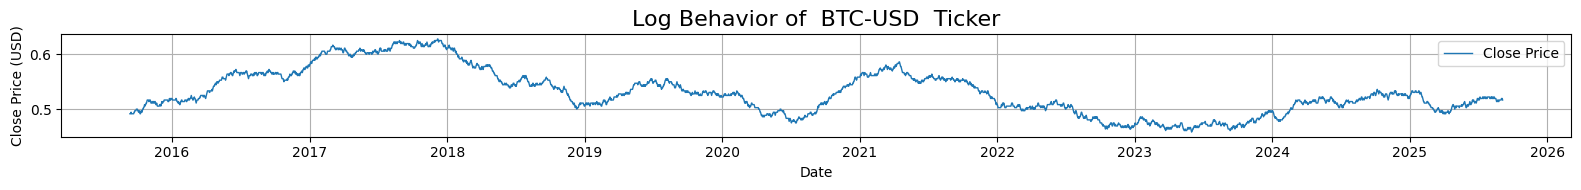

In [165]:
# === Plot Data ===
serie_to_plot=X_clean['dist_shape::p_up_w360']
plt.figure(figsize=(16, 2))
plt.plot(serie_to_plot.index, serie_to_plot, label='Close Price', linewidth=1)
#plt.plot(vix_df.index, np.log(vix_df['Close']), label='Close Price', linewidth=1)

# === Labels and Details ===
plt.title(f'Log Behavior of  {ticker}  Ticker', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Strategy Events Generation

In [ ]:
# Strategy Generation Signals
events_df, meta = run_strategy_engine_simple(X_clean.copy(), data.copy(), CONFIG_SE_SIMPLE)

Strategy: btc1d_simple_momentum_v1
Rows X: 4006, Cols X: 862
Side: long, Combiner: AND
------------------------------------------------------------
[Rule LONG] trend_basic::trend_slope_close_w90 > 0.0: 2298 barras True
[Rule LONG] trend_plus::efficiency_ratio_close_w90 > 0.1: 2384 barras True
Combined (raw) → long: 1660  short: 0
------------------------------------------------------------
Eventos generados: 1660
Recuento por side → long: 1660, short: 0
Gap (días) — mean: 2.225437010247137  median: 1.0  min: 1  max: 416
Primeras filas:


,t0,decision_time,execution_time,side,entry_ref_price,pt_mult,sl_mult,H_bars,sigma_method,sigma_span,sigma_value,features_hash
event_id,,,,,,,,,,,,
0a0e8e540296679b,2015-07-08,2015-07-08,2015-07-09,1,270.785004,2.5,2.0,60,atr,30,7.578503,5604df9fa77ec1fb
5cdfdf4d7ec597af,2015-07-09,2015-07-09,2015-07-10,1,269.227997,2.5,2.0,60,atr,30,7.741503,5604df9fa77ec1fb
b34c93bd990f2c28,2015-07-10,2015-07-10,2015-07-11,1,284.894012,2.5,2.0,60,atr,30,9.426717,5604df9fa77ec1fb
f5b5cea752d874cf,2015-07-11,2015-07-11,2015-07-12,1,293.114990,2.5,2.0,60,atr,30,9.909147,5604df9fa77ec1fb
1e6c3c6a505ba6f6,2015-07-12,2015-07-12,2015-07-13,1,310.867004,2.5,2.0,60,atr,30,11.205648,5604df9fa77ec1fb
0067df2101b4d369,2015-07-13,2015-07-13,2015-07-14,1,292.053986,2.5,2.0,60,atr,30,12.730291,5604df9fa77ec1fb
98e1087517e798ad,2015-07-14,2015-07-14,2015-07-15,1,287.463989,2.5,2.0,60,atr,30,12.558005,5604df9fa77ec1fb
27b70a576d7339df,2015-07-15,2015-07-15,2015-07-16,1,285.829010,2.5,2.0,60,atr,30,12.449647,5604df9fa77ec1fb
f719e404ae32adce,2015-07-16,2015-07-16,2015-07-17,1,278.088989,2.5,2.0,60,atr,30,13.051648,5604df9fa77ec1fb


------------------------------------------------------------
META: {'strategy_name': 'btc1d_simple_momentum_v1', 'rows_X': 4006, 'cols_X': 862, 'events': 1660, 'long_raw_true': 1660, 'short_raw_true': 0, 'max_active': 100, 'cooldown_bars': 0}


## Strategy Timeline Visualization

Ventanas activas: 12 | Cobertura activa: 64.68%


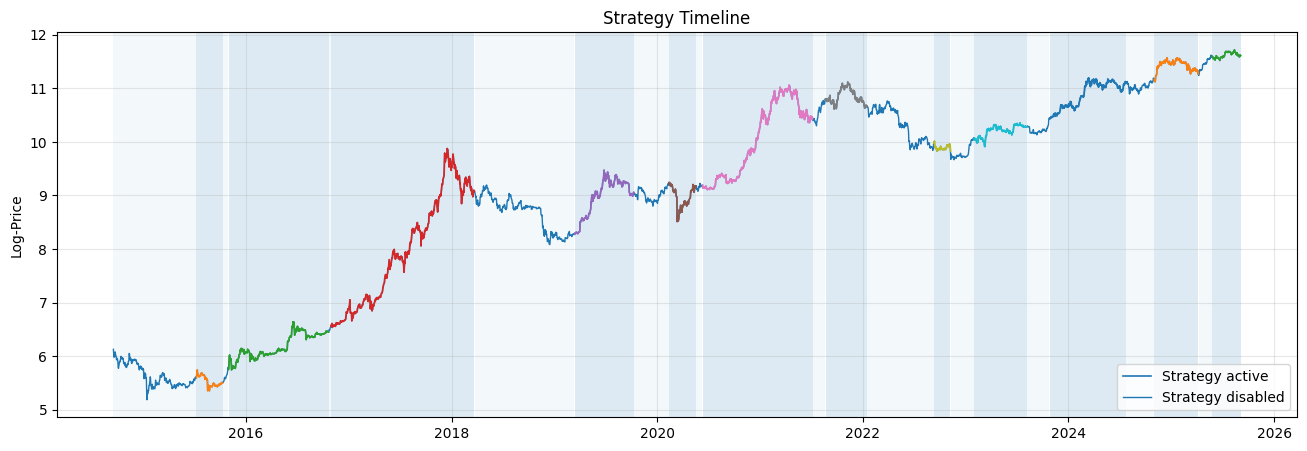

In [ ]:
plot_strategy_timeline(data.copy(), events_df.copy(), close_col="Close", title="Strategy Timeline")

## Apling Triple Barrier Method

In [ ]:
# Etiquetar con TB (usando tus 'data' y 'events_df'):
labels_df, tb_diag = label_with_triple_barrier(data.copy(), events_df.copy(), TB_CFG)

# Echa un vistazo
from IPython.display import display
display(labels_df.head(10))
print(tb_diag)

TB labeling → eventos etiquetados: 1660 (skipped=0)
Outcomes (pt/sl/t1): {'pt': 917, 'sl': 706, 't1': 37}
Pos class rate (y=1): 55.96% | holding_days median: 7 | ret_signed median: 0.0524


,t_start,t_end,which_barrier,p0,pt_level,sl_level,p_out,ret_raw,ret_signed,y_meta,holding_days,side,pt_mult,sl_mult,H_bars,sigma_method,sigma_value
event_id,,,,,,,,,,,,,,,,,
0a0e8e540296679b,2015-07-09,2015-07-10,pt,270.826996,289.773254,255.669989,289.773254,0.069957,0.069957,1,1,1,2.5,2.0,60,atr,7.578503
5cdfdf4d7ec597af,2015-07-10,2015-07-10,pt,269.156006,288.509763,253.673000,288.509763,0.071905,0.071905,1,0,1,2.5,2.0,60,atr,7.741503
b34c93bd990f2c28,2015-07-11,2015-07-12,pt,284.880005,308.446799,266.026570,308.446799,0.082725,0.082725,1,1,1,2.5,2.0,60,atr,9.426717
f5b5cea752d874cf,2015-07-12,2015-07-17,sl,293.140015,317.912882,273.321721,273.321721,-0.067607,-0.067607,0,5,1,2.5,2.0,60,atr,9.909147
1e6c3c6a505ba6f6,2015-07-13,2015-07-13,sl,310.826996,338.841116,288.415700,288.415700,-0.072102,-0.072102,0,0,1,2.5,2.0,60,atr,11.205648
0067df2101b4d369,2015-07-14,2015-08-08,sl,292.033997,323.859724,266.573414,266.573414,-0.087184,-0.087184,0,25,1,2.5,2.0,60,atr,12.730291
98e1087517e798ad,2015-07-15,2015-08-08,sl,288.045013,319.440026,262.929003,262.929003,-0.087195,-0.087195,0,24,1,2.5,2.0,60,atr,12.558005
27b70a576d7339df,2015-07-16,2015-08-08,sl,286.041992,317.166110,261.142698,261.142698,-0.087048,-0.087048,0,23,1,2.5,2.0,60,atr,12.449647
f719e404ae32adce,2015-07-17,2015-08-18,sl,278.091003,310.720123,251.987708,251.987708,-0.093866,-0.093866,0,32,1,2.5,2.0,60,atr,13.051648


{'events_in': 1660, 'events_labeled': 1660, 'skipped': 0, 'outcomes': {'pt': 917, 'sl': 706, 't1': 37}, 'pos_rate': 0.5596385542168675, 'holding_days_median': 7.0, 'ret_signed_median': 0.052412501360855845}


## Generating Filtered Training dataset

In [ ]:
# 1) Ganador/Perdedor en ±1, sin recorte temporal
X_train, y_train, ids_train, info = build_meta_training_view(
    X_clean, events_df, labels_df,
    start_date=None, end_date=None,
    y_kind="signed",       # +1/-1
    dropna_rows=True
)
'''
# 2) Mismo, pero acotado a un rango de fechas
X_train_win, y_train_win, ids_train_win, info_win = build_meta_training_view(
    X_clean, events_df, labels_df,
    start_date="2019-01-01", end_date="2022-12-31",
    y_kind="signed",
    dropna_rows=True
)
'''
print ("done!!!!")

[INFO] Filas con NaN en features descartadas: 255
---- META-VIEW SUMMARY ----
Eventos en labels_df: 1660
Eventos tras filtro fechas ± etiqueta: 1405
X_train shape: (1405, 862)
Distribución y: {1: 817, -1: 588}
done!!!!


## Generating (Train, Purge & Embargo, Test) datasets

In [ ]:
train, embargo, test, info = make_train_embargo_test(
    X_full=X_train,
    y_full=y_train,
    ids_full=ids_train,
    events_df=events_df,
    labels_df=labels_df,
    index_ref=data.index,
    train_frac=0.75,
    test_frac=0.20,
    embargo_mode="pct",   # "auto" usa median(holding)/2; puedes cambiar a "bars" o "pct"
    embargo_pct= 0.02,
    verbose=True
)

(X_tr, y_tr, ids_tr)   = train
(X_emb, y_emb, ids_emb)= embargo
(X_te, y_te, ids_te)   = test

print("Shapes →",
      X_tr.shape, len(y_tr), "|",
      X_emb.shape, len(y_emb), "|",
      X_te.shape, len(y_te))
print("Info:", info)



=== SPLIT RESUMEN (por t0) ===
Total eventos: 1405
TRAIN:   1042  | t0: 2016-10-28 00:00:00  →  2023-11-08 00:00:00
EMBARGO: 76 | barras: 3343..3422  (embargo_bars=80)
TEST:    281  | t0: 2024-01-30 00:00:00  →  2025-08-16 00:00:00
Rango barras TEST: [3423, 3994] | TRAIN purged hasta < 3343
y(TRAIN): {1: 623, -1: 419}
y(TEST): {-1: 152, 1: 129}
Shapes → (1042, 862) 1042 | (76, 862) 76 | (281, 862) 281
Info: {'n_total': 1405, 'n_train': 1042, 'n_embargo': 76, 'n_test': 281, 'test_lo_bar': 3423, 'test_hi_bar': 3994, 'embargo_bars': 80, 'emb_lo_bar': 3343, 'emb_hi_bar': 3422}


## Visualizating Splits (Train,Purge & Embargo,Test)

Rangos → TRAIN: (datetime.date(2016, 10, 28), datetime.date(2023, 11, 8), '2567d') | EMBARGO: (datetime.date(2023, 11, 12), datetime.date(2024, 1, 30), '79d') | TEST: (datetime.date(2024, 1, 30), datetime.date(2025, 8, 16), '564d')


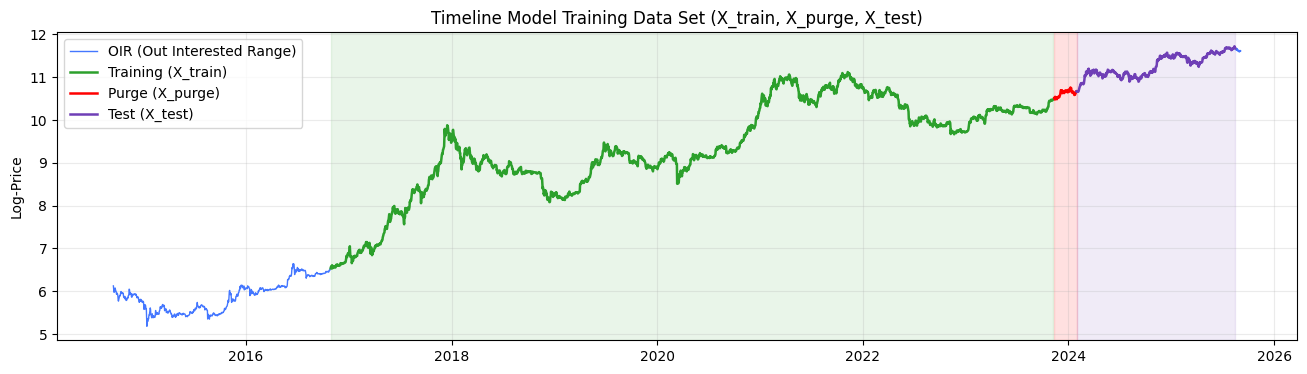

In [ ]:
# Con los splits que ya generaste:
# (X_tr, y_tr, ids_tr), (X_emb, y_emb, ids_emb), (X_te, y_te, ids_te), info = make_train_embargo_test(...)

plot_train_embargo_test(
    prices=data.copy(),
    events_df=events_df.copy(),
    ids_tr=ids_tr,
    ids_emb=ids_emb,
    ids_te=ids_te,
    split_info=info,            # opcional pero útil si no hubo eventos en el embargo
    close_col="Close",
    title="Timeline Model Training Data Set (X_train, X_purge, X_test)"
)


## Making Purged K fold + Embargo over TRAIN

In [ ]:
# 0) Prepara intervalos del TRAIN (ids_tr viene del split anterior)
train_idx = prepare_train_intervals(ids_tr=ids_tr,
                                    events_df=events_df,
                                    labels_df=labels_df,
                                    index_ref=data.index)

# 1) Genera K folds purged + embargo (auto = med(holding)/2)
folds = make_purged_folds_train(train_idx, n_splits=5, embargo_mode="auto", verbose=True)

[Fold 1] val=414 train=628 | val_bars=[773,1285] purge=[773,1288] | val_t0=2016-10-28 00:00:00→2018-01-21 00:00:00
[Fold 2] val=129 train=913 | val_bars=[1286,1799] purge=[1283,1802] | val_t0=2019-03-13 00:00:00→2019-08-11 00:00:00
[Fold 3] val=211 train=828 | val_bars=[1800,2312] purge=[1797,2315] | val_t0=2019-06-30 00:00:00→2021-01-14 00:00:00
[Fold 4] val=185 train=857 | val_bars=[2313,2826] purge=[2310,2829] | val_t0=2021-01-11 00:00:00→2021-11-16 00:00:00
[Fold 5] val=120 train=922 | val_bars=[2827,3340] purge=[2824,3340] | val_t0=2022-09-09 00:00:00→2023-11-08 00:00:00


## Plotting Purged_CV_Fold

[Fold 1] val_ids=414 train_ids=628
TRAIN: 2016-10-29 → 2023-11-09 (2567d)
TEST : 2016-10-29 → 2018-03-25 (512d)
t1max: 2018-02-02
PURGE left : —
PURGE right: (datetime.date(2018, 3, 26), datetime.date(2018, 3, 28))


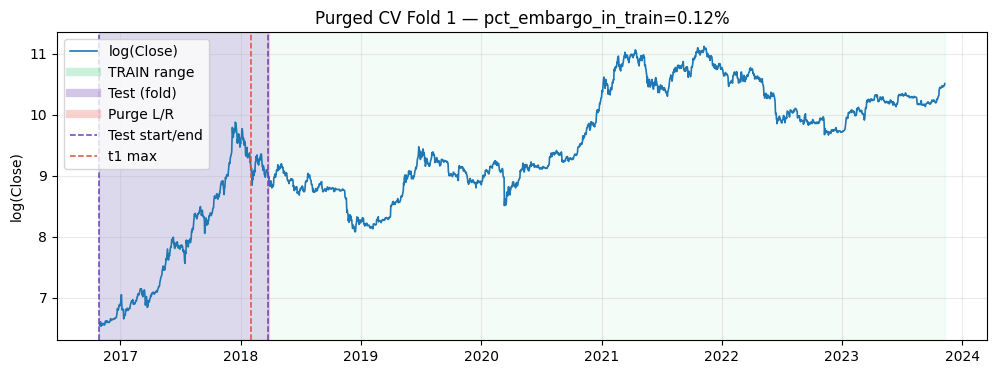

[Fold 1] val_ids=414 train_ids=628
TRAIN: 2016-10-29 → 2023-11-09 (2567d)
TEST : 2016-10-29 → 2018-03-25 (512d)
t1max: 2018-02-02
PURGE left : —
PURGE right: (datetime.date(2018, 3, 26), datetime.date(2018, 3, 28))


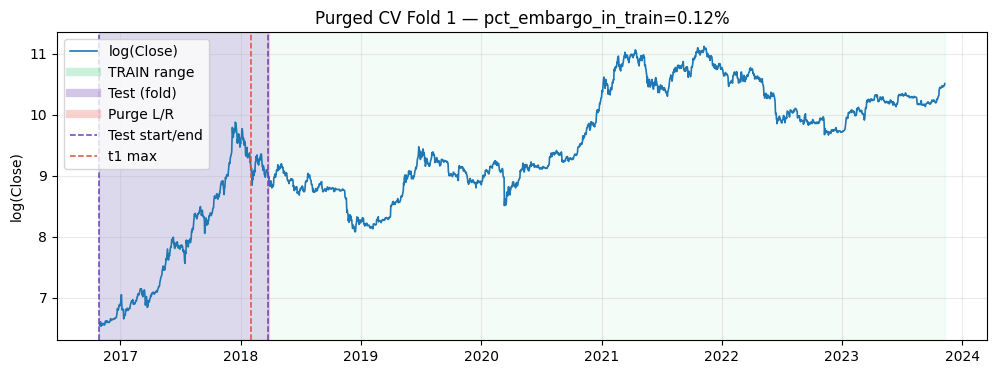

[Fold 2] val_ids=129 train_ids=913
TRAIN: 2016-10-29 → 2023-11-09 (2567d)
TEST : 2018-03-26 → 2019-08-21 (513d)
t1max: 2019-09-20
PURGE left : (datetime.date(2018, 3, 23), datetime.date(2018, 3, 25))
PURGE right: (datetime.date(2019, 8, 22), datetime.date(2019, 8, 24))


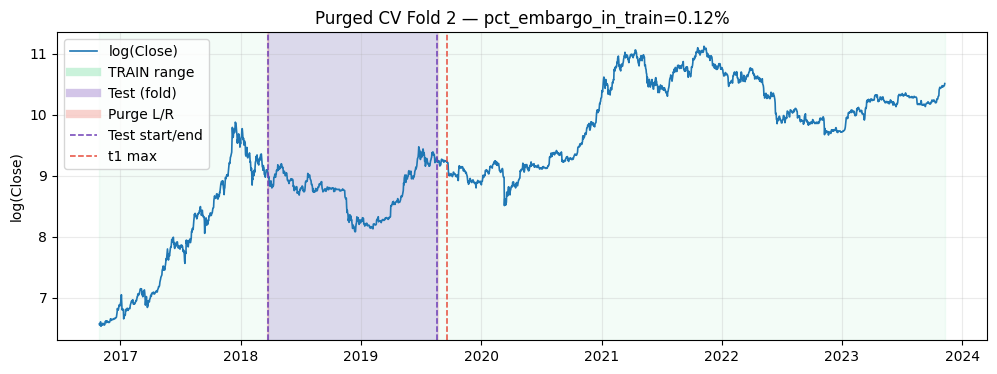

[Fold 3] val_ids=211 train_ids=828
TRAIN: 2016-10-29 → 2023-11-09 (2567d)
TEST : 2019-08-22 → 2021-01-15 (512d)
t1max: 2021-02-08
PURGE left : (datetime.date(2019, 8, 19), datetime.date(2019, 8, 21))
PURGE right: (datetime.date(2021, 1, 16), datetime.date(2021, 1, 18))


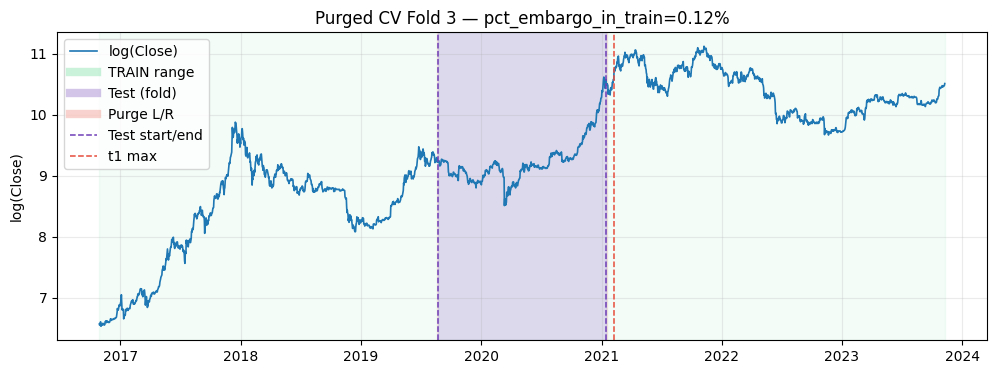

[Fold 4] val_ids=185 train_ids=857
TRAIN: 2016-10-29 → 2023-11-09 (2567d)
TEST : 2021-01-16 → 2022-06-13 (513d)
t1max: 2021-11-26
PURGE left : (datetime.date(2021, 1, 13), datetime.date(2021, 1, 15))
PURGE right: (datetime.date(2022, 6, 14), datetime.date(2022, 6, 16))


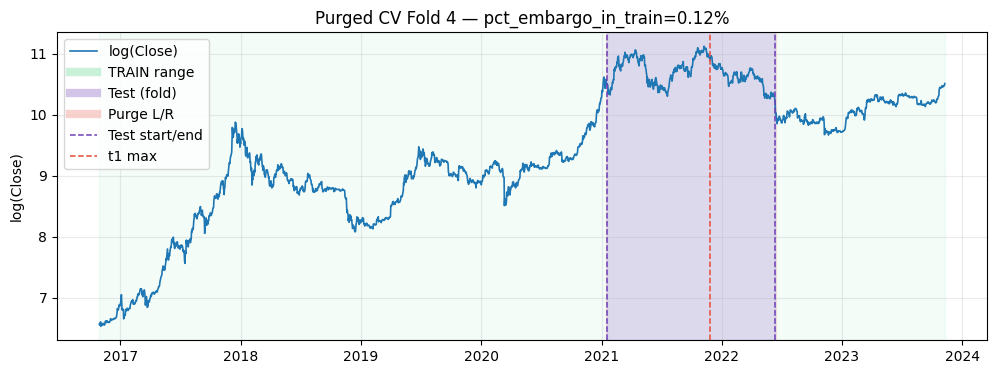

[Fold 5] val_ids=120 train_ids=922
TRAIN: 2016-10-29 → 2023-11-09 (2567d)
TEST : 2022-06-14 → 2023-11-09 (513d)
t1max: 2023-11-09
PURGE left : (datetime.date(2022, 6, 11), datetime.date(2022, 6, 13))
PURGE right: —


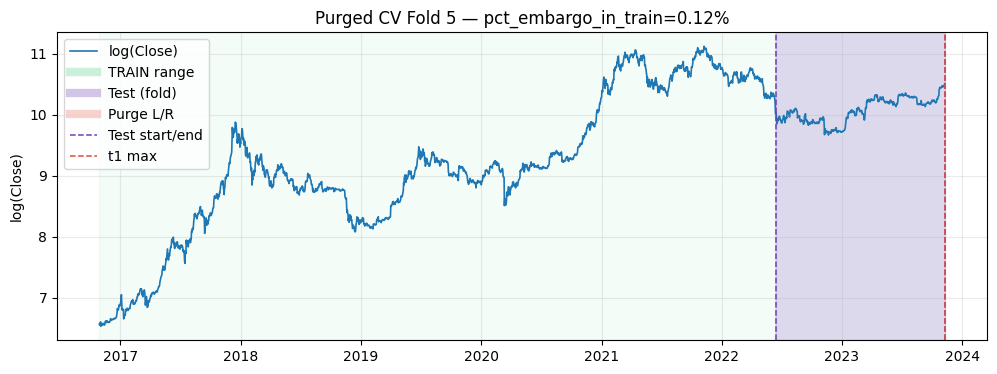

In [ ]:
# train_idx = prepare_train_intervals(...), folds = make_purged_folds_train(...)
_ = plot_purged_cv_fold_trainonly(
    prices=data.copy(),
    fold=folds[0],          # cambia 0..K-1
    train_idx=train_idx,
    close_col="Close"
)

# Ver todos los folds (uno a uno):
for f in folds:
    plot_purged_cv_fold_trainonly(data, f, train_idx, close_col="Close")



## Generating uniquenness weights

In [ ]:
# Construir intervals (si no los tienes ya)
labels_idx = _build_event_intervals(labels_df, data.index)

# Pesos globales en TRAIN (ids_tr viene de tu split TRAIN/EMBARGO/TEST)
w_uni_train = average_uniqueness_for_ids(
    labels_idx=labels_idx,
    ids_subset=ids_tr,
    index_len=len(data.index),
    normalize="mean1"   # media=1 (recomendado)
)

print("Unicidad TRAIN — min/med/mean/max:",
      float(w_uni_train.min()), float(w_uni_train.median()),
      float(w_uni_train.mean()), float(w_uni_train.max()))


Unicidad TRAIN — min/med/mean/max: 0.17091557166186575 0.6408194500175554 1.0 6.408194500175553


In [ ]:
# Pesos por Folds y validacion
w_train_by_fold = uniqueness_by_fold(folds, labels_idx, len(data.index), normalize="mean1")
w_val_by_fold   = uniqueness_val_by_fold(folds, labels_idx, len(data.index), normalize="mean1")

[Fold 1] w_uni — min/med/mean/max: 0.19334684945642086 0.6312480027673836 1.0000000000000002 7.249217875619406
[Fold 2] w_uni — min/med/mean/max: 0.17038404571466922 0.6685410204564373 1.0 6.388265820661998
[Fold 3] w_uni — min/med/mean/max: 0.21288879450140474 0.6398996558029209 0.9999999999999999 6.115531879780919
[Fold 4] w_uni — min/med/mean/max: 0.16096271520368272 0.6339024299817956 1.0000000000000002 6.035028735370077
[Fold 5] w_uni — min/med/mean/max: 0.16916594550684133 0.653891353357818 1.0 6.342595183536504


## Implementing Cluster MDA

In [ ]:
# SUPONE que ya tienes:
# - (X_tr, y_tr, ids_tr)  del split TRAIN/EMBARGO/TEST
# - folds                 de make_purged_folds_train(...)
# - (opcional) w_uni      Series de uniqueness por event_id (puedes omitirlo)

# 1) Mapa de clústeres macro a partir de columnas de X_tr
cluster_map = build_cluster_map(X_tr.columns, include=None, exclude=None, min_size=3)

# 2) Entrenar baseline por fold (con uniqueness si lo tienes)

fold_models, ap_bases = train_baseline_models_cv(
    X_tr, y_tr, ids_tr, folds,
    w_train_by_fold=w_train_by_fold,
    w_val_by_fold=w_val_by_fold,
    rf_params=CLUSTER_MDA_CFG["rf_params"]
)

# 3) Cluster MDA (permuta grupos en validación)
mda_results, mda_raw = cluster_mda_cv(
    X_tr, y_tr, folds, fold_models, cluster_map,
    n_perm=CLUSTER_MDA_CFG["n_perm"],
    random_state=CLUSTER_MDA_CFG["random_state"]
)

# 4) Vista resumida (whitelist candidata)
if len(mda_results):
    # criterio conservador: ΔAP_mean > 0 y ΔAP_q25 > 0
    wl = mda_results[(mda_results["dAP_mean"] > 0) & (mda_results["dAP_q25"] > 0)].copy()
    wl = wl.sort_values("dAP_mean", ascending=False)
    print("\n=== Whitelist macro-candidata (ΔAP_mean>0 & ΔAP_q25>0) ===")
    display(wl[["cluster","n_cols","dAP_mean","dAP_q25"]].head(15))
    print("Tamaño whitelist macro:", len(wl))
else:
    print("No hay resultados MDA para construir whitelist.")


[ClusterMap] grupos=16 | tamaño medio=53.9 | min=12 | max=190
Top tamaños: [('diag_failure', 190), ('vol_regime', 162), ('price_action_shape', 76), ('volume_activity', 70), ('extrema_distance', 60), ('indicator_enhanced', 47), ('trend_plus', 40), ('volume_flow', 39), ('time_position', 35), ('dist_shape', 34), ('info_entropy', 32), ('squeeze_breakout', 20)]
[Fold 1] baseline AP = 0.6320
[Fold 2] baseline AP = 0.6501
[Fold 3] baseline AP = 0.5318
[Fold 4] baseline AP = 0.4580
[Fold 5] baseline AP = 0.6776
Baseline CV AP → mean=0.5899 | median=0.6320
=== Cluster MDA (ΔAP = AP_base - AP_perm) — con unicidad en validación ===


,cluster,n_cols,dAP_mean,dAP_median,dAP_q25,dAP_q75,dAP_std,dAP_per_fold_mean
0,vol_regime,162,0.012019,-0.002420,-0.016336,0.019702,0.050667,"[0.008332512430731553, -0.006368862036360136, ..."
1,info_entropy,32,0.011443,0.009904,-0.008344,0.024244,0.026128,"[0.024536719644928887, -0.01348722488420129, 0..."
2,dist_shape,34,0.008964,0.002790,-0.003505,0.018768,0.023662,"[-0.011978925883743115, 0.00034835238325068516..."
3,trend_plus,40,0.007379,0.003936,-0.007453,0.013241,0.021863,"[-0.0034603903959496717, -0.016034568069975087..."
4,oscillators,12,0.005648,-0.000314,-0.002271,0.001794,0.015224,"[-0.00259163296957322, -3.535478351332833e-05,..."
5,fracdiff_core,16,0.004927,0.004391,0.001013,0.009534,0.007216,"[0.004882245573564597, 0.0009018072218828022, ..."
6,squeeze_breakout,20,0.002891,0.000603,-0.003202,0.005680,0.010821,"[0.003870660808575195, -0.006798275958013133, ..."
7,trend_basic,16,0.001907,-0.000347,-0.003154,0.004468,0.008793,"[-0.0013809056046915913, -0.001713426063305224..."
8,candle_anatomy,13,-0.000615,-0.000641,-0.002387,0.002026,0.004582,"[0.0041274781877436335, -0.001239264161964444,..."
9,extrema_distance,60,-0.001176,0.001381,-0.008336,0.009747,0.018733,"[-0.02859504133362929, 0.008642176542945294, 0..."


Top clusters por dAP_mean:
  -         vol_regime | n=162 | ΔAP_mean=0.0120 | ΔAP_q25=-0.0163
  -       info_entropy | n=32 | ΔAP_mean=0.0114 | ΔAP_q25=-0.0083
  -         dist_shape | n=34 | ΔAP_mean=0.0090 | ΔAP_q25=-0.0035
  -         trend_plus | n=40 | ΔAP_mean=0.0074 | ΔAP_q25=-0.0075
  -        oscillators | n=12 | ΔAP_mean=0.0056 | ΔAP_q25=-0.0023
  -      fracdiff_core | n=16 | ΔAP_mean=0.0049 | ΔAP_q25=0.0010
  -   squeeze_breakout | n=20 | ΔAP_mean=0.0029 | ΔAP_q25=-0.0032
  -        trend_basic | n=16 | ΔAP_mean=0.0019 | ΔAP_q25=-0.0032
  -     candle_anatomy | n=13 | ΔAP_mean=-0.0006 | ΔAP_q25=-0.0024
  -   extrema_distance | n=60 | ΔAP_mean=-0.0012 | ΔAP_q25=-0.0083

=== Whitelist macro-candidata (ΔAP_mean>0 & ΔAP_q25>0) ===


,cluster,n_cols,dAP_mean,dAP_q25
5,fracdiff_core,16,0.004927,0.001013


Tamaño whitelist macro: 1


## Macro → HAC → dendrograma → MDA micro

[HAC] cols=32 | micro_groups=19 | corr_cut=0.8 → d_cut=0.316
  tamaños: [(3, 3), (12, 3), (2, 3), (1, 3), (4, 3), (13, 3), (14, 2), (8, 1), (15, 1), (10, 1)]


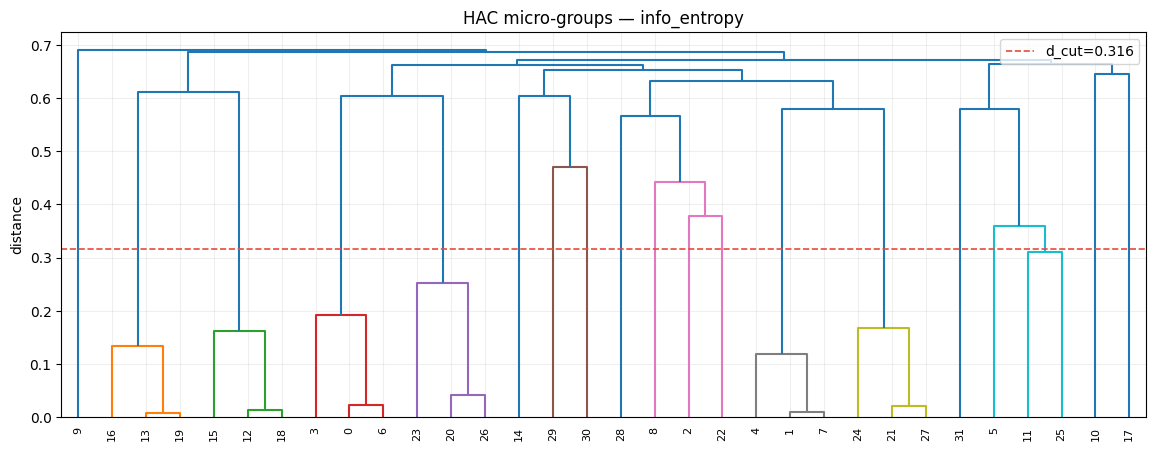

=== MDA micro (agregado por fold; métrica = ΔAP_fold) ===


,micro_id,n_cols,dAP_fold_mean,dAP_fold_median,dAP_fold_q25,dAP_fold_q75,dAP_fold_std,per_fold
0,15,1,0.006785,0.003844,0.001458,0.013983,0.006319,"[0.013982823309872005, -0.00010346203285155898..."
1,1,3,0.000597,0.003178,0.002535,0.003354,0.008175,"[0.0025348789612798127, -0.015076954634719336,..."
2,3,3,0.002553,0.001728,0.001091,0.003330,0.002878,"[0.0010914437841429204, -0.0009849594030029107..."
3,13,3,0.002265,0.001547,0.001366,0.003290,0.001411,"[0.0044848967475708875, 0.0015465556374797463,..."
4,2,3,0.001231,0.001132,0.000710,0.002177,0.001007,"[0.0007096373472322781, -0.0003182465161662873..."
5,10,1,-0.000090,0.000198,-0.000422,0.000894,0.001396,"[0.0014566299532115857, 0.00019789230992787733..."
6,18,1,0.000232,0.000136,0.000000,0.000190,0.000328,"[0.0001902610997337184, 0.00013557284805196246..."
7,8,1,0.000227,0.000102,-0.000227,0.000767,0.000477,"[0.00010181304013710535, -0.000312899709754932..."
8,4,3,0.000369,0.000089,-0.001449,0.000334,0.002337,"[-0.001855600827509235, -0.0014486914441253218..."
9,19,1,-0.003106,0.000038,-0.000009,0.000058,0.006288,"[3.818119320112556e-05, -8.571480438951395e-06..."



=== Whitelist micro (robusto por fold) ===


,micro_id,n_cols,dAP_fold_mean,dAP_fold_median,dAP_fold_q25,dAP_fold_q75,dAP_fold_std,per_fold
0,15,1,0.006785,0.003844,0.001458,0.013983,0.006319,"[0.013982823309872005, -0.00010346203285155898..."
1,1,3,0.000597,0.003178,0.002535,0.003354,0.008175,"[0.0025348789612798127, -0.015076954634719336,..."
2,3,3,0.002553,0.001728,0.001091,0.003330,0.002878,"[0.0010914437841429204, -0.0009849594030029107..."
3,13,3,0.002265,0.001547,0.001366,0.003290,0.001411,"[0.0044848967475708875, 0.0015465556374797463,..."
4,2,3,0.001231,0.001132,0.000710,0.002177,0.001007,"[0.0007096373472322781, -0.0003182465161662873..."


[Debug] per-fold ΔAP del micro 15: [0.013982823309872005, -0.00010346203285155898, 0.0014576676596046389, 0.003843935343008334, 0.014744954726928411]


In [ ]:
# Suponiendo que ya tienes:
# - cluster_map (macro → columnas) de la MDA macro
# - (X_tr, y_tr, ids_tr), folds, fold_models (con w_val)
# Escoge un macro “borderline”, p. ej. 'vol_regime' o 'info_entropy'

macro = "info_entropy"   # cambia por 'vol_regime', 'info_entropy', 'dist_shape', etc.
cols_macro = cluster_map[macro]

# 1) HAC interna y micro-grupos
micro_map, meta = hac_microgroups(
    X_tr=X_tr,
    cluster_cols=cols_macro,
    corr_method="spearman",
    use_abs=True,
    corr_cut=0.80,
    linkage_method="average"
)

# 2) Dendrograma del macro (opcional)
plot_hac_dendrogram(meta, title=f"HAC micro-groups — {macro}", max_leaves=120)

# 3) MDA micro (permuta subgrupos en validación, robusto por fold)
res_micro, raw_micro = mda_groups_fold_robust(
    X_tr=X_tr, y_tr=y_tr, folds=folds, fold_models=fold_models,
    group_map=micro_map,
    n_perm=20, random_state=42
)

# 4) Whitelist micro (criterio robusto): mediana>0 y q25>0
wl_micro = res_micro[(res_micro["dAP_fold_median"] > 0) & (res_micro["dAP_fold_q25"] > 0)].copy()
wl_micro = wl_micro.sort_values(["dAP_fold_median","dAP_fold_mean"], ascending=False)
print("\n=== Whitelist micro (robusto por fold) ===")
from IPython.display import display
display(wl_micro.head(12))

# (Opcional) ver per-fold de un micro concreto:
if len(res_micro):
    m_id = int(res_micro.iloc[0]["micro_id"])
    print(f"[Debug] per-fold ΔAP del micro {m_id}:", raw_micro["per_fold"][m_id])


## List the columns of the micros and propose the medoid of each one (representative) for your whitelist

In [ ]:
# --- Ejemplo de uso (tal cual) ---
# Si ya tienes 'raw_micro' (de mda_groups_fold_robust) y 'meta' (de hac_microgroups):
df_meds, whitelist_ie = list_micro_columns_and_medoids(
    selected_micro_ids=[15, 1, 3, 13, 2],
    group_cols=None,          # autodetecta raw_micro['group_cols'] o micro_map
    corr_matrix=None,         # autodetecta meta['corr']; si no, calcula desde X_tr (pásalo abajo)
    X_tr=None,                # si no tienes meta['corr'], pásale X_tr aquí
    use_abs=True
)

=== Medoides sugeridos (whitelist candidatos) ===
['info_entropy::absret_entropy_norm_w365', 'info_entropy::range_entropy_ratio_w30_365', 'info_entropy::absret_entropy_ratio_w14_120', 'info_entropy::ret_entropy_ratio_w30_365', 'info_entropy::range_entropy_ratio_w14_120']


,micro_id,n_cols,columns,medoid,medoid_rho_mean
0,1,3,"[info_entropy::range_entropy_delta_w30_365, in...",info_entropy::range_entropy_ratio_w30_365,0.982819
1,2,3,"[info_entropy::range_entropy_delta_w14_120, in...",info_entropy::range_entropy_ratio_w14_120,0.974984
2,3,3,"[info_entropy::absret_entropy_delta_w14_120, i...",info_entropy::absret_entropy_ratio_w14_120,0.965686
3,13,3,"[info_entropy::ret_entropy_delta_w30_365, info...",info_entropy::ret_entropy_ratio_w30_365,0.974222
4,15,1,[info_entropy::absret_entropy_norm_w365],info_entropy::absret_entropy_norm_w365,1.000000


## Automatic Cluster MDA

In [ ]:
# Asume que ya tienes:
# X_tr, y_tr, ids_tr              (TRAIN)
# folds                           (Purged K-Fold + embargo)
# labels_df, data.index           (para unicidad)
# Y definidas: train_baseline_models_cv, cluster_mda_cv, hac_microgroups, mda_groups_fold_robust,
#              y list_micro_columns_and_medoids o _medoid_by_corr_matrix

wl_final, rep = run_cluster_mda_auto(
    X_tr=X_tr, y_tr=y_tr, ids_tr=ids_tr,
    folds=folds,
    labels_df=labels_df,
    index_ref=data.index,
    config={
        "macro": {"n_perm": 100},
        "micro": {"do": True, "n_perm": 20, "corr_cut": 0.80, "reps_per_group": 1, "max_macros": 6},
        "dedup": {"corr_cap": 0.90},
        "weights": {"use_uniqueness": True, "normalize": "mean1"},
        "random_state": 42,
        "verbose": True
    }
)

# Te devuelve la 'wl_final' y un 'report' con tablas y selecciones intermedias.


[ClusterMap] grupos=16 | tamaño medio=53.9 | min=12 | max=190
Top tamaños: [('diag_failure', 190), ('vol_regime', 162), ('price_action_shape', 76), ('volume_activity', 70), ('extrema_distance', 60), ('indicator_enhanced', 47), ('trend_plus', 40), ('volume_flow', 39), ('time_position', 35), ('dist_shape', 34), ('info_entropy', 32), ('squeeze_breakout', 20)]
[Fold 1] baseline AP = 0.6320
[Fold 2] baseline AP = 0.6501
[Fold 3] baseline AP = 0.5318
[Fold 4] baseline AP = 0.4580
[Fold 5] baseline AP = 0.6776
Baseline CV AP → mean=0.5899 | median=0.6320
=== Cluster MDA (ΔAP = AP_base - AP_perm) — con unicidad en validación ===


,cluster,n_cols,dAP_mean,dAP_median,dAP_q25,dAP_q75,dAP_std,dAP_per_fold_mean
0,vol_regime,162,0.012019,-0.002420,-0.016336,0.019702,0.050667,"[0.008332512430731553, -0.006368862036360136, ..."
1,info_entropy,32,0.011443,0.009904,-0.008344,0.024244,0.026128,"[0.024536719644928887, -0.01348722488420129, 0..."
2,dist_shape,34,0.008964,0.002790,-0.003505,0.018768,0.023662,"[-0.011978925883743115, 0.00034835238325068516..."
3,trend_plus,40,0.007379,0.003936,-0.007453,0.013241,0.021863,"[-0.0034603903959496717, -0.016034568069975087..."
4,oscillators,12,0.005648,-0.000314,-0.002271,0.001794,0.015224,"[-0.00259163296957322, -3.535478351332833e-05,..."
5,fracdiff_core,16,0.004927,0.004391,0.001013,0.009534,0.007216,"[0.004882245573564597, 0.0009018072218828022, ..."
6,squeeze_breakout,20,0.002891,0.000603,-0.003202,0.005680,0.010821,"[0.003870660808575195, -0.006798275958013133, ..."
7,trend_basic,16,0.001907,-0.000347,-0.003154,0.004468,0.008793,"[-0.0013809056046915913, -0.001713426063305224..."
8,candle_anatomy,13,-0.000615,-0.000641,-0.002387,0.002026,0.004582,"[0.0041274781877436335, -0.001239264161964444,..."
9,extrema_distance,60,-0.001176,0.001381,-0.008336,0.009747,0.018733,"[-0.02859504133362929, 0.008642176542945294, 0..."


Top clusters por dAP_mean:
  -         vol_regime | n=162 | ΔAP_mean=0.0120 | ΔAP_q25=-0.0163
  -       info_entropy | n=32 | ΔAP_mean=0.0114 | ΔAP_q25=-0.0083
  -         dist_shape | n=34 | ΔAP_mean=0.0090 | ΔAP_q25=-0.0035
  -         trend_plus | n=40 | ΔAP_mean=0.0074 | ΔAP_q25=-0.0075
  -        oscillators | n=12 | ΔAP_mean=0.0056 | ΔAP_q25=-0.0023
  -      fracdiff_core | n=16 | ΔAP_mean=0.0049 | ΔAP_q25=0.0010
  -   squeeze_breakout | n=20 | ΔAP_mean=0.0029 | ΔAP_q25=-0.0032
  -        trend_basic | n=16 | ΔAP_mean=0.0019 | ΔAP_q25=-0.0032
  -     candle_anatomy | n=13 | ΔAP_mean=-0.0006 | ΔAP_q25=-0.0024
  -   extrema_distance | n=60 | ΔAP_mean=-0.0012 | ΔAP_q25=-0.0083

=== MDA macro (robusto por fold) ===


,cluster,n_cols,dAP_mean,dAP_median,dAPF_median,dAPF_q25
1,info_entropy,32,0.011443,0.009904,0.009544,-0.005773
9,extrema_distance,60,-0.001176,0.001381,0.006438,-0.004078
5,fracdiff_core,16,0.004927,0.004391,0.004882,0.000902
3,trend_plus,40,0.007379,0.003936,0.004713,-0.003460
6,squeeze_breakout,20,0.002891,0.000603,0.001885,-0.000870
2,dist_shape,34,0.008964,0.002790,0.000967,0.000348
4,oscillators,12,0.005648,-0.000314,-0.000563,-0.002313
11,volume_activity,70,-0.002186,-0.001509,-0.001141,-0.004296
8,candle_anatomy,13,-0.000615,-0.000641,-0.001239,-0.002628
13,time_position,35,-0.004139,-0.001995,-0.001276,-0.006910



Macros aprobados (macro): ['dist_shape', 'fracdiff_core']
Macros a procesar en MDA micro (hasta 6): ['dist_shape', 'fracdiff_core', 'vol_regime', 'info_entropy', 'trend_plus', 'oscillators']
[HAC] cols=34 | micro_groups=21 | corr_cut=0.8 → d_cut=0.316
  tamaños: [(16, 4), (6, 4), (20, 3), (19, 2), (18, 2), (10, 2), (1, 2), (11, 2), (21, 1), (3, 1)]
=== MDA micro (agregado por fold; métrica = ΔAP_fold) ===


,micro_id,n_cols,dAP_fold_mean,dAP_fold_median,dAP_fold_q25,dAP_fold_q75,dAP_fold_std,per_fold
0,2,1,0.004642,0.005754,-1.113920e-04,0.006432,0.004487,"[0.0057541226614607425, -0.0001113919876346292..."
1,18,2,0.002328,0.003722,-1.599770e-03,0.004048,0.003484,"[-0.0015997696830349795, 0.0037221833947744367..."
2,1,2,0.002666,0.001735,2.099163e-04,0.001956,0.006201,"[-0.004678549268324866, 0.00020991633623593242..."
3,10,2,0.002561,0.001468,9.024368e-04,0.002729,0.002986,"[-0.00046422573082707255, 0.001467819603301823..."
4,5,1,0.002425,0.001357,-7.373481e-04,0.001841,0.004697,"[0.0013574589688324866, -0.0007373481399740644..."
5,7,1,0.001297,0.000510,-5.279628e-05,0.001148,0.002003,"[0.0005101406049595692, -5.279627692242883e-05..."
6,14,1,0.001626,0.000403,-1.701397e-04,0.000945,0.003849,"[0.0009445777069701011, -0.002093787702417449,..."
7,11,2,0.001125,0.000200,-1.074352e-03,0.003555,0.008526,"[-0.011788533723449162, -0.0010743521344839136..."
8,3,1,0.000400,0.000134,-2.158437e-04,0.001048,0.001070,"[0.0010484700184797136, 0.00013444999520652036..."
9,13,1,-0.000231,0.000112,-1.139249e-05,0.000516,0.001072,"[0.0005164110056285698, -0.0023284792649817974..."



[dist_shape] → micro ganadores: 3; representantes propuestos: ['dist_shape::perc_asym_ratio_q0.05_0.95_w360', 'dist_shape::perc_asym_ratio_q0.05_0.95_w120', 'dist_shape::p_up_w360']
[HAC] cols=16 | micro_groups=4 | corr_cut=0.8 → d_cut=0.316
  tamaños: [(4, 6), (2, 4), (1, 4), (3, 2)]
=== MDA micro (agregado por fold; métrica = ΔAP_fold) ===


,micro_id,n_cols,dAP_fold_mean,dAP_fold_median,dAP_fold_q25,dAP_fold_q75,dAP_fold_std,per_fold
0,1,4,0.001889,0.002710,-0.001962,0.005282,0.003392,"[-0.0019622925025078396, -0.002194968853456641..."
1,2,4,0.003772,0.001303,0.000820,0.006293,0.004551,"[0.006292847903521586, 0.0013028600995994787, ..."
2,3,2,0.000909,0.000929,-0.000296,0.001811,0.001725,"[0.0035575406134765453, -0.0002956957913375913..."
3,4,6,-0.000346,-0.000090,-0.000931,0.000437,0.002109,"[-0.0009310035281001716, 0.0004369965906689421..."



[fracdiff_core] → micro ganadores: 1; representantes propuestos: ['fracdiff_core::ffd_logc_d035_tau1e-04_W332']
[HAC] cols=162 | micro_groups=85 | corr_cut=0.8 → d_cut=0.316
  tamaños: [(59, 12), (84, 9), (44, 8), (43, 8), (10, 5), (55, 4), (48, 4), (63, 4), (53, 3), (26, 2)]
=== MDA micro (agregado por fold; métrica = ΔAP_fold) ===


,micro_id,n_cols,dAP_fold_mean,dAP_fold_median,dAP_fold_q25,dAP_fold_q75,dAP_fold_std,per_fold
0,84,9,0.008975,0.011595,0.000291,0.015597,0.007661,"[0.011595111203859743, 0.00029108695855933897,..."
1,49,2,0.006531,0.005647,0.001257,0.012402,0.005486,"[0.005647077930679367, 6.4509626539494e-05, 0...."
2,24,2,0.014545,0.005545,-0.002247,0.009419,0.028329,"[-0.0022466574909815627, -0.009654938863154761..."
3,63,4,0.003251,0.005002,0.000272,0.005768,0.003023,"[0.005767953232705608, -0.0010400916690700367,..."
4,71,1,0.006081,0.002516,0.000177,0.004221,0.009429,"[-0.0010874459956537851, 0.0001766094967841802..."
5,44,8,0.003035,0.002512,0.000602,0.003569,0.004563,"[0.01112792754161696, 0.0006015510417311298, -..."
6,30,1,0.001617,0.001576,-0.000037,0.001806,0.001854,"[0.0018059725775223634, -3.731129899759433e-05..."
7,66,2,0.000922,0.001507,-0.000332,0.002102,0.003650,"[0.0021022338672828933, -0.0003324536037172809..."
8,37,1,0.001654,0.001489,0.000939,0.002346,0.001303,"[0.0036798119426544986, -0.0001809897825544193..."
9,11,1,0.000357,0.001275,0.000063,0.001278,0.001887,"[0.002310439811356918, 6.270667134850583e-05, ..."



[vol_regime] → micro ganadores: 12; representantes propuestos: ['vol_regime::rv_cc_over_range_w120', 'vol_regime::runlen_regime_low_w240', 'vol_regime::rv_cc_over_pk_w240', 'vol_regime::vol_of_vol_w30', 'vol_regime::rv_cc_w120']
[HAC] cols=32 | micro_groups=19 | corr_cut=0.8 → d_cut=0.316
  tamaños: [(3, 3), (12, 3), (2, 3), (1, 3), (4, 3), (13, 3), (14, 2), (8, 1), (15, 1), (10, 1)]
=== MDA micro (agregado por fold; métrica = ΔAP_fold) ===


,micro_id,n_cols,dAP_fold_mean,dAP_fold_median,dAP_fold_q25,dAP_fold_q75,dAP_fold_std,per_fold
0,15,1,0.006785,0.003844,0.001458,0.013983,0.006319,"[0.013982823309872005, -0.00010346203285155898..."
1,1,3,0.000597,0.003178,0.002535,0.003354,0.008175,"[0.0025348789612798127, -0.015076954634719336,..."
2,3,3,0.002553,0.001728,0.001091,0.003330,0.002878,"[0.0010914437841429204, -0.0009849594030029107..."
3,13,3,0.002265,0.001547,0.001366,0.003290,0.001411,"[0.0044848967475708875, 0.0015465556374797463,..."
4,2,3,0.001231,0.001132,0.000710,0.002177,0.001007,"[0.0007096373472322781, -0.0003182465161662873..."
5,10,1,-0.000090,0.000198,-0.000422,0.000894,0.001396,"[0.0014566299532115857, 0.00019789230992787733..."
6,18,1,0.000232,0.000136,0.000000,0.000190,0.000328,"[0.0001902610997337184, 0.00013557284805196246..."
7,8,1,0.000227,0.000102,-0.000227,0.000767,0.000477,"[0.00010181304013710535, -0.000312899709754932..."
8,4,3,0.000369,0.000089,-0.001449,0.000334,0.002337,"[-0.001855600827509235, -0.0014486914441253218..."
9,19,1,-0.003106,0.000038,-0.000009,0.000058,0.006288,"[3.818119320112556e-05, -8.571480438951395e-06..."



[info_entropy] → micro ganadores: 5; representantes propuestos: ['info_entropy::absret_entropy_norm_w365', 'info_entropy::range_entropy_ratio_w30_365', 'info_entropy::absret_entropy_ratio_w14_120', 'info_entropy::ret_entropy_ratio_w30_365', 'info_entropy::range_entropy_ratio_w14_120']
[HAC] cols=40 | micro_groups=20 | corr_cut=0.8 → d_cut=0.316
  tamaños: [(10, 6), (4, 5), (1, 4), (11, 4), (2, 3), (3, 2), (15, 2), (14, 2), (5, 1), (20, 1)]
=== MDA micro (agregado por fold; métrica = ΔAP_fold) ===


,micro_id,n_cols,dAP_fold_mean,dAP_fold_median,dAP_fold_q25,dAP_fold_q75,dAP_fold_std,per_fold
0,6,1,0.004490,0.002662,0.002214,0.005100,0.004425,"[0.0022136435295144197, -0.0002016767815928910..."
1,2,3,0.005958,0.002189,0.000327,0.003215,0.012080,"[0.00032731025392457867, -0.005328752232612888..."
2,10,6,0.001100,0.001468,0.000213,0.001543,0.002951,"[-0.003467246963523507, 0.00021256944298424506..."
3,9,1,0.000476,0.000777,0.000300,0.000779,0.000573,"[-0.0005556553183076185, 0.0007788950104162529..."
4,5,1,0.003005,0.000752,-0.000265,0.001083,0.006138,"[-0.0002651916224385764, -0.001676148009026817..."
5,8,1,0.000399,0.000559,-0.000653,0.001002,0.001006,"[0.00100187732272074, -0.000653346764817675, 0..."
6,11,4,0.000762,0.000368,-0.000383,0.000821,0.002070,"[0.0008211550976369774, -0.0003831180904851905..."
7,7,1,0.002486,0.000188,-0.000146,0.003354,0.003598,"[-0.0001455214470745314, -0.000147379492415483..."
8,16,1,0.000249,0.000000,0.000000,0.000000,0.000497,"[0.0, 0.0, 0.0, 0.0, 0.001243099932106695]"
9,15,2,0.000090,0.000000,0.000000,0.000000,0.000179,"[0.0, 0.0, 0.0, -2.133357412947845e-09, 0.0004..."



[trend_plus] → micro ganadores: 4; representantes propuestos: ['trend_plus::convexity_close_poly2_w90', 'trend_plus::ma_order_21_gt_100', 'trend_plus::close_percentile_w90', 'trend_plus::efficiency_ratio_close_w90']
[HAC] cols=12 | micro_groups=7 | corr_cut=0.8 → d_cut=0.316
  tamaños: [(3, 4), (4, 3), (1, 1), (6, 1), (5, 1), (7, 1), (2, 1)]
=== MDA micro (agregado por fold; métrica = ΔAP_fold) ===


,micro_id,n_cols,dAP_fold_mean,dAP_fold_median,dAP_fold_q25,dAP_fold_q75,dAP_fold_std,per_fold
0,6,1,0.003084,0.000557,0.000058,0.006649,0.003568,"[0.006648747441112446, 5.7697536026024565e-05,..."
1,4,3,0.000452,0.000081,-0.000570,0.000158,0.001733,"[-0.0011865375330434359, 0.0001579835208012414..."
2,3,4,0.001212,0.000051,-0.000245,0.000131,0.005409,"[-0.0051496046996279245, 0.0001307238502696983..."
3,1,1,0.000356,-0.000019,-0.000086,0.000334,0.000680,"[0.00033378695661577805, -8.642576773871258e-0..."
4,5,1,-0.000285,-0.000069,-0.000462,0.000488,0.000904,"[-0.0019317129560307178, -6.943902029783455e-0..."
5,7,1,0.003374,-0.000201,-0.000715,-0.000047,0.007658,"[-4.651493845486687e-05, -0.000715211401927734..."
6,2,1,-0.000240,-0.000812,-0.000847,0.000139,0.001744,"[0.002810572058906191, -0.0008120693765169939,..."



[oscillators] → micro ganadores: 1; representantes propuestos: ['oscillators::rsi_slope_w14']

=== Whitelist FINAL (tras deduplicación por |ρ|) ===
['vol_regime::rv_cc_over_range_w120', 'vol_regime::runlen_regime_low_w240', 'vol_regime::rv_cc_over_pk_w240', 'info_entropy::absret_entropy_norm_w365', 'info_entropy::range_entropy_ratio_w30_365', 'trend_plus::convexity_close_poly2_w90', 'vol_regime::vol_of_vol_w30', 'vol_regime::rv_cc_w120', 'trend_plus::ma_order_21_gt_100', 'dist_shape::perc_asym_ratio_q0.05_0.95_w360', 'info_entropy::absret_entropy_ratio_w14_120', 'info_entropy::ret_entropy_ratio_w30_365', 'vol_regime::corr_absr_dlogV_w30', 'trend_plus::close_percentile_w90', 'dist_shape::perc_asym_ratio_q0.05_0.95_w120', 'fracdiff_core::ffd_logc_d035_tau1e-04_W332', 'vol_regime::exceed_count_k2.0_w30', 'info_entropy::range_entropy_ratio_w14_120', 'trend_plus::efficiency_ratio_close_w90', 'vol_regime::acf_absr_lag14_w120', 'vol_regime::acf_absr_lag5_w120', 'vol_regime::semi_up_over_down

In [109]:
List_test=['vol_regime::rv_cc_over_range_w120', 'vol_regime::runlen_regime_low_w240', 'vol_regime::rv_cc_over_pk_w240', 'info_entropy::absret_entropy_norm_w365', 'info_entropy::range_entropy_ratio_w30_365', 'trend_plus::convexity_close_poly2_w90', 'vol_regime::vol_of_vol_w30', 'vol_regime::rv_cc_w120', 'trend_plus::ma_order_21_gt_100', 'dist_shape::perc_asym_ratio_q0.05_0.95_w360', 'info_entropy::absret_entropy_ratio_w14_120', 'info_entropy::ret_entropy_ratio_w30_365', 'vol_regime::corr_absr_dlogV_w30', 'trend_plus::close_percentile_w90', 'dist_shape::perc_asym_ratio_q0.05_0.95_w120', 'fracdiff_core::ffd_logc_d035_tau1e-04_W332', 'vol_regime::exceed_count_k2.0_w30', 'info_entropy::range_entropy_ratio_w14_120', 'trend_plus::efficiency_ratio_close_w90', 'vol_regime::acf_absr_lag14_w120', 'vol_regime::acf_absr_lag5_w120', 'vol_regime::semi_up_over_down_w120', 'oscillators::rsi_slope_w14', 'vol_regime::peak_shock_over_sigma_w120', 'vol_regime::runlen_regime_med_w120', 'dist_shape::p_up_w360']

In [111]:
wl_final

['vol_regime::rv_cc_over_range_w120',
 'vol_regime::runlen_regime_low_w240',
 'vol_regime::rv_cc_over_pk_w240',
 'info_entropy::absret_entropy_norm_w365',
 'info_entropy::range_entropy_ratio_w30_365',
 'trend_plus::convexity_close_poly2_w90',
 'vol_regime::vol_of_vol_w30',
 'vol_regime::rv_cc_w120',
 'trend_plus::ma_order_21_gt_100',
 'dist_shape::perc_asym_ratio_q0.05_0.95_w360',
 'info_entropy::absret_entropy_ratio_w14_120',
 'info_entropy::ret_entropy_ratio_w30_365',
 'vol_regime::corr_absr_dlogV_w30',
 'trend_plus::close_percentile_w90',
 'dist_shape::perc_asym_ratio_q0.05_0.95_w120',
 'fracdiff_core::ffd_logc_d035_tau1e-04_W332',
 'vol_regime::exceed_count_k2.0_w30',
 'info_entropy::range_entropy_ratio_w14_120',
 'trend_plus::efficiency_ratio_close_w90',
 'vol_regime::acf_absr_lag14_w120',
 'vol_regime::acf_absr_lag5_w120',
 'vol_regime::semi_up_over_down_w120',
 'oscillators::rsi_slope_w14',
 'vol_regime::peak_shock_over_sigma_w120',
 'vol_regime::runlen_regime_med_w120',
 'dist_

## Automatic MDA by Features

[Fold 1] baseline AP = 0.6320
[Fold 2] baseline AP = 0.6501
[Fold 3] baseline AP = 0.5318
[Fold 4] baseline AP = 0.4580
[Fold 5] baseline AP = 0.6776
Baseline CV AP → mean=0.5899 | median=0.6320
[Fold 1] procesado. n_features=862
[Fold 2] procesado. n_features=862
[Fold 3] procesado. n_features=862
[Fold 4] procesado. n_features=862
[Fold 5] procesado. n_features=862
=== Feature MDA (n_perm=3) — agregado por fold ===


,feature,dAPF_median,dAPF_q25,dAPF_mean,dAPF_std,hit_rate,k_support,per_fold
0,diag_failure::perm_entropy_slope_w120,0.005775,-0.000315,0.005774,0.006739,0.6,5,"[0.005775103111084645, -0.00031516198313837524..."
1,info_entropy::absret_entropy_norm_w365,0.004957,0.000977,0.006485,0.005753,1.0,5,"[0.012917378524587889, 3.2313112500033846e-05,..."
2,dist_shape::med_mean_diff_w360,0.004836,-0.000085,0.003658,0.003489,0.6,5,"[0.005144308902705785, -8.514175070399126e-05,..."
3,dist_shape::skew_r_w360,0.004735,0.001181,0.003417,0.002930,0.8,5,"[-0.001167566335559959, 0.006307613296523777, ..."
4,vol_regime::sigma_drawdown_from_max_w240,0.003770,0.001079,0.003303,0.002493,1.0,5,"[0.003769616681505291, 0.0010787432836707467, ..."
5,vol_regime::acf_r2_lag14_w30,0.003753,0.002394,0.010843,0.015847,0.8,5,"[0.0023944536935557315, -0.004388314309239176,..."
6,diag_failure::vr_m20_w60,0.003370,0.000927,0.011270,0.017607,0.8,5,"[0.003370155609990951, -7.885970883329356e-05,..."
7,vol_regime::sigma_runup_from_min_w240,0.003124,0.000139,0.005860,0.005958,0.8,5,"[0.003124260559148717, 0.00013949014482180408,..."
8,vol_regime::rv_bv_w30,0.002997,0.000124,0.002286,0.002580,0.8,5,"[0.006275352308072857, 0.0001236687449316006, ..."
9,fracdiff_core::ffd_logc_d035_tau1e-04_W332__st...,0.002820,0.000859,0.002257,0.001601,1.0,5,"[0.004473266187196678, 3.785514782073118e-05, ..."



[Stage-1] Pasa umbrales: 109 | TopM: 250 | Shortlist total: 256
[Fold 1] procesado. n_features=256
[Fold 2] procesado. n_features=256
[Fold 3] procesado. n_features=256
[Fold 4] procesado. n_features=256
[Fold 5] procesado. n_features=256
=== Feature MDA (n_perm=2) — agregado por fold ===


,feature,dAPF_median,dAPF_q25,dAPF_mean,dAPF_std,hit_rate,k_support,per_fold
0,vol_regime::acf_r2_lag14_w30,0.006352,0.002823,0.012940,0.018902,0.8,5,"[0.0028233719744993335, -0.004938153594699457,..."
1,diag_failure::volofvol_x_weakbreadth_w240,0.005374,0.002316,0.004455,0.002236,1.0,5,"[0.0013681841670567518, 0.005374408879794068, ..."
2,dist_shape::skew_r_w360,0.005374,-0.001946,0.001838,0.005935,0.6,5,"[-0.0019460871838889449, 0.007648646215334232,..."
3,price_action_shape::pa_width_local_atr_w12,0.005272,0.000504,0.003701,0.003633,0.8,5,"[0.005272128214131477, -0.0015276848890869998,..."
4,vol_regime::sigma_runup_from_min_w240,0.004408,0.000031,0.006549,0.006542,0.8,5,"[0.004408111267858172, -0.00011406071838881982..."
5,diag_failure::vr_m20_w60,0.003347,0.001397,0.008757,0.013155,0.8,5,"[0.0033468482078023998, -0.0003744123041997671..."
6,trend_plus::convexity_close_poly2_w90,0.003125,0.002849,0.006493,0.007564,1.0,5,"[0.0031253612360983007, 0.00017998395267659895..."
7,indicator_enhanced::roc_slope_h30_w60,0.002668,0.000236,0.001477,0.002266,0.8,5,"[0.002667707646182571, -0.0023478324058530675,..."
8,info_entropy::absret_entropy_norm_w365,0.002585,0.000820,0.005310,0.005327,1.0,5,"[0.00944860426896238, 4.9263339291560904e-05, ..."
9,fracdiff_core::ffd_logc_d035_tau1e-04_W332__sl...,0.002360,-0.000609,0.001694,0.002371,0.6,5,"[0.002758868413797466, -0.000608787960946322, ..."



=== Ranking (post Stage-2, pre-dedup) ===


,feature,dAPF_median,dAPF_q25,dAPF_mean,dAPF_std,hit_rate,k_support,per_fold
0,vol_regime::acf_r2_lag14_w30,0.006352,0.002823,0.012940,0.018902,0.8,5,"[0.0028233719744993335, -0.004938153594699457,..."
1,diag_failure::volofvol_x_weakbreadth_w240,0.005374,0.002316,0.004455,0.002236,1.0,5,"[0.0013681841670567518, 0.005374408879794068, ..."
2,dist_shape::skew_r_w360,0.005374,-0.001946,0.001838,0.005935,0.6,5,"[-0.0019460871838889449, 0.007648646215334232,..."
3,price_action_shape::pa_width_local_atr_w12,0.005272,0.000504,0.003701,0.003633,0.8,5,"[0.005272128214131477, -0.0015276848890869998,..."
4,vol_regime::sigma_runup_from_min_w240,0.004408,0.000031,0.006549,0.006542,0.8,5,"[0.004408111267858172, -0.00011406071838881982..."
5,diag_failure::vr_m20_w60,0.003347,0.001397,0.008757,0.013155,0.8,5,"[0.0033468482078023998, -0.0003744123041997671..."
6,trend_plus::convexity_close_poly2_w90,0.003125,0.002849,0.006493,0.007564,1.0,5,"[0.0031253612360983007, 0.00017998395267659895..."
7,indicator_enhanced::roc_slope_h30_w60,0.002668,0.000236,0.001477,0.002266,0.8,5,"[0.002667707646182571, -0.0023478324058530675,..."
8,info_entropy::absret_entropy_norm_w365,0.002585,0.000820,0.005310,0.005327,1.0,5,"[0.00944860426896238, 4.9263339291560904e-05, ..."
9,fracdiff_core::ffd_logc_d035_tau1e-04_W332__sl...,0.002360,-0.000609,0.001694,0.002371,0.6,5,"[0.002758868413797466, -0.000608787960946322, ..."



=== Whitelist tras deduplicación por |ρ| ===
Tamaño antes: 256 → después: 195  (corr_cap=0.9)


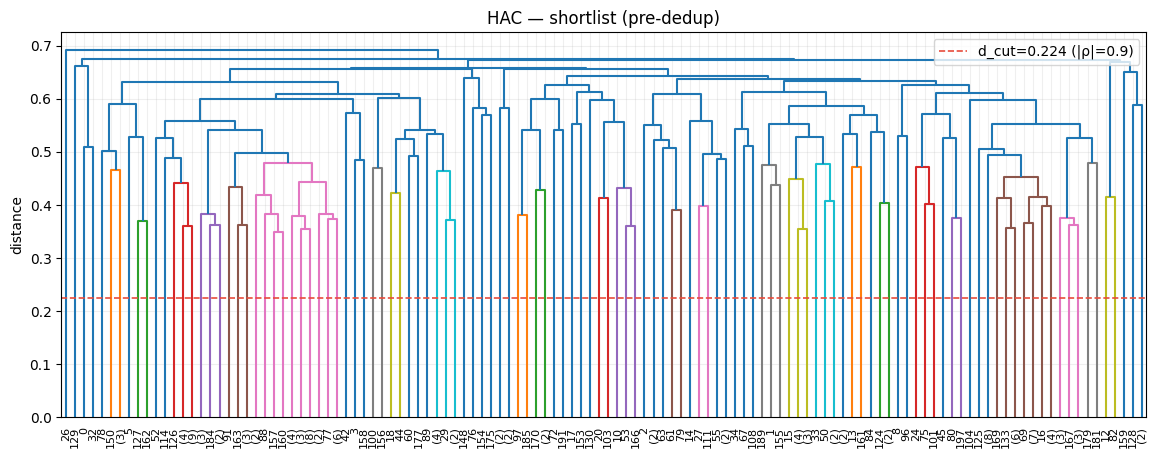


=== WHITELIST FINAL (parsimoniosa) ===
['vol_regime::acf_r2_lag14_w30', 'diag_failure::volofvol_x_weakbreadth_w240', 'dist_shape::skew_r_w360', 'price_action_shape::pa_width_local_atr_w12', 'vol_regime::sigma_runup_from_min_w240', 'diag_failure::vr_m20_w60', 'trend_plus::convexity_close_poly2_w90', 'indicator_enhanced::roc_slope_h30_w60', 'info_entropy::absret_entropy_norm_w365', 'vol_regime::tail_heaviness_ratio_w240', 'fracdiff_core::ffd_logc_d035_tau1e-04_W332__std_w30', 'diag_failure::perm_entropy_slope_w120', 'vol_regime::vol_of_vol_w30', 'diag_failure::acf_r_lag14_w120', 'vol_regime::acf_absr_lag5_w120', 'dist_shape::ulcer_index_w120', 'vol_regime::corr_absr_dlogV_w30', 'diag_failure::mfe_intra_mean_w60', 'diag_failure::clv_x_neg_rangeSlope_w240', 'vol_regime::cusum_abs_log_sigma_w120', 'vol_regime::rv_pk_w120', 'trend_plus::ma_order_50_gt_100', 'info_entropy::ret_entropy_norm_w30', 'dist_shape::med_mean_diff_w360', 'diag_failure::bb_touch_upper_frac_w120', 'info_entropy::absret

In [134]:
'''
wl_feat_final, rep_feat = run_feature_mda_auto(
    X_tr=X_tr, y_tr=y_tr, ids_tr=ids_tr,
    folds=folds,
    labels_df=labels_df,
    index_ref=data.index,
    config={
        "mda": {"stage1_n_perm": 3, "stage2_n_perm": 2, "topM": 250,
                "median_gt": 0.0, "q25_gt": 0.0, "hit_rate_min": 0.6},
        "dedup": {"do": True, "corr_cap": 0.90, "plot_dendrogram": True},
        "weights": {"use_uniqueness": True, "normalize": "mean1"},
        "baseline": {"rf_params": dict(n_estimators=300, max_features="sqrt",
                                       min_samples_leaf=5, n_jobs=-1, random_state=42)},
        "random_state": 42,
        "verbose": True
    }
)
'''
print("done!!!")

## Training the model

In [137]:
#feat_list_ap=feat_final
rf = RandomForestClassifier(n_estimators=450,  random_state=42, class_weight=None)
#rf = RandomForestClassifier(n_estimators=400, max_depth= 5, min_samples_leaf=1, max_features='sqrt', bootstrap=True, max_samples=0.4,  random_state=20, class_weight=None)
#rf = RandomForestClassifier(n_estimators=400,  random_state=42, class_weight='balanced')
#rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', criterion='entropy')
#rf = RandomForestClassifier(n_estimators=195, random_state=42)

#rf.fit(X_train, y_train)
#y_pred_show = rf.predict(X_test)

rf.fit(X_tr[wl_final], y_tr, sample_weight=w_uni_train)
y_pred_show = rf.predict(X_te[wl_final])

## Analyzing Training Results

Accuracy: 0.6476868327402135
Cassification Report:
              precision    recall  f1-score   support

          -1       0.63      0.86      0.72       152
           1       0.70      0.40      0.51       129

    accuracy                           0.65       281
   macro avg       0.67      0.63      0.62       281
weighted avg       0.66      0.65      0.63       281



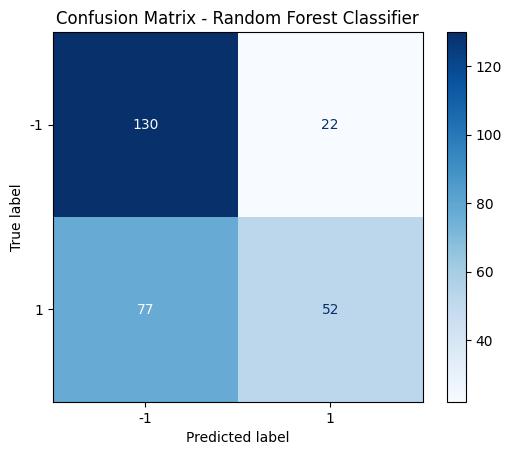

In [138]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
# ..........................Evaluating Results........................................
#y_test_var=y_train
y_test_var=y_te
y_pred_var= y_pred_show

print("Accuracy:", accuracy_score(y_test_var, y_pred_var))
print("Cassification Report:")
print(classification_report(y_test_var, y_pred_var))

# ..........................Generate the confusion matrix.............................
cm = confusion_matrix(y_test_var, y_pred_var)
# ...........................Show confusion matrix......................................
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

# RESET ALL VARIABLES

In [ ]:
#%reset -f